# Exercise 1: Coding exercise of the week
---

This exercise will walk you through the basics of PyTorch. The goal is for you to become familiar with:
- What is a computational graph
- How to define a pytorch data loader
- How to build a neural network in pytorch
- How to define a pytorch optimizer
- How to train a neural network in pytorch


We will assume the following software versions, but other versions may also work:
- Python 3.8 (at least 3.6 should also work)
- PyTorch 1.7.1


In addition to this exercise, we recommend you to have a look at the official tutorials on pytorch.org

https://pytorch.org/tutorials/index.html

## Play with MNIST Fashion and PyTorch

---
Your task is to use PyTorch to build a model and train a neural network on the MNIST Fashion dataset. Before you can start, you need to have access to the MNIST Fashion dataset. If you use an IFI computer, the default path given in this Jupyter Notebook file will root you to the data. If you work on any other computer, you will need to download the MNIST Fashion dataset. You can download the files from: https://github.com/zalandoresearch/fashion-mnist/tree/master/data/fashion

MINST Fashion files:
- t10k-images-idx3-ubyte.gz
- t10k-labels-idx1-ubyte.gz
- train-images-idx3-ubyte.gz
- train-labels-idx1-ubyte.gz

Do not download the files with rightclick-save as in GitHub, but e.g. with left clicking and using the download button. If you get shape errors in the Dataset and your images files are only as few KBytes small, then you have not successfully downloaded the files.

The MNIST Fashion dataset have 10 classes: ['T-shirt / top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'].  

The training set consists of 60,000 images and the test set consists of 10,000 images. The images are of size [28,28].


**Important!**
You will need to add code only at locations where a NotImplementedError is raised.

<b>"%matplotlib inline"</b> is used to plot figures within Jupyter Notebook.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from utils.utility_functions import datasetFashionMNIST
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics

%matplotlib inline

---
### Step 1: Handling of the data

The following cell creates two instances of "datasetFashionMNIST". The "datasetFashionMNIST" is a "torch.utils.data.Dataset" written for the MNIST Fashion dataset.

If you do not use an IFI computer, edit the "dataPath" to the location of the MNIST Fashion dataset.


In [2]:
#Path to the MNIST Fashion files
dataPath = 'data/'
# dataPath = '/projects/in5400/MNIST_fashion/'

# Create dataset objects
train_dataset = datasetFashionMNIST(dataPath=dataPath, train=True)
val_dataset   = datasetFashionMNIST(dataPath=dataPath, train=False)

data/train-labels-idx1-ubyte.gz (60000,)
data/train-images-idx3-ubyte.gz (47040000,)
data/t10k-labels-idx1-ubyte.gz (10000,)
data/t10k-images-idx3-ubyte.gz (7840000,)


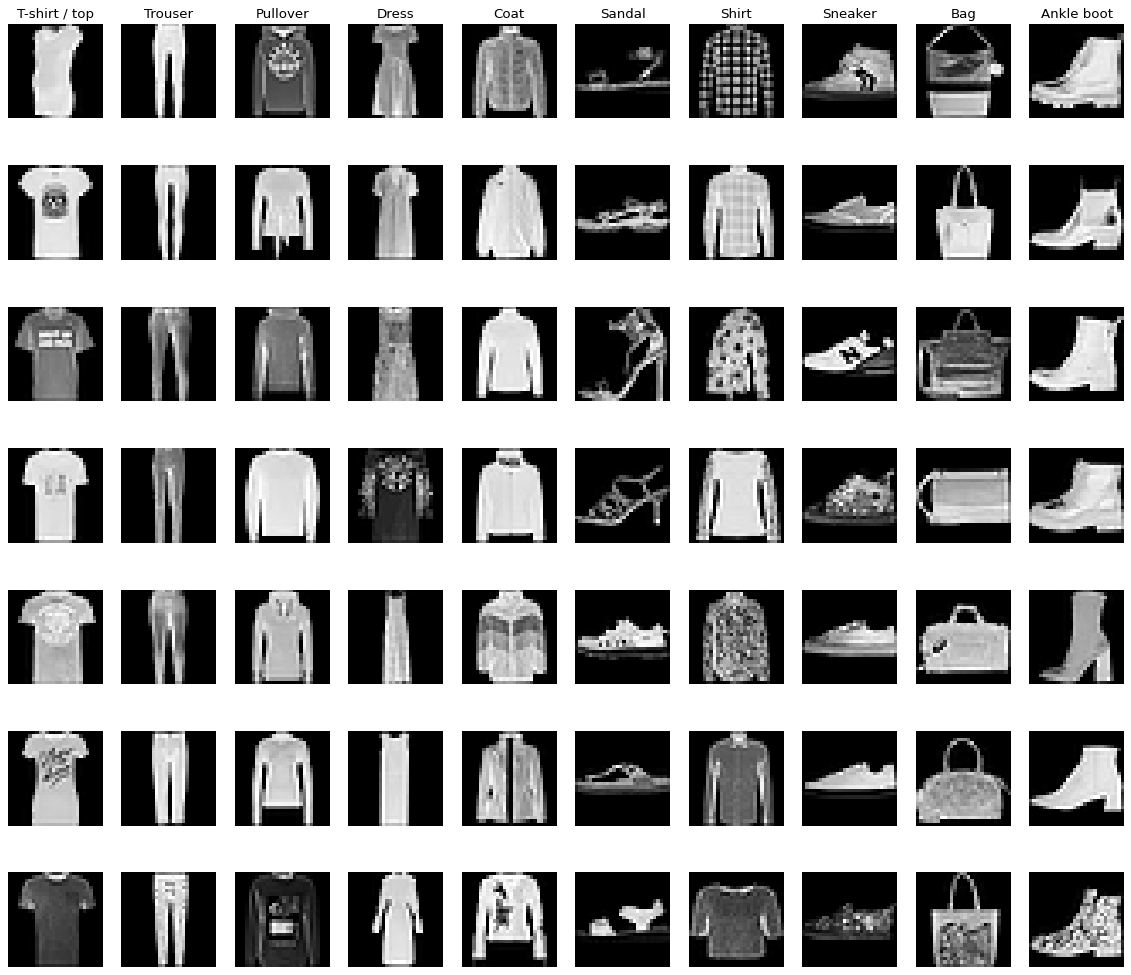

In [3]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['T-shirt / top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
num_classes = len(classes)
samples_per_class = 7
plt.figure(figsize=(18, 16), dpi=80)
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(np.array(train_dataset.labels) == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        img = (train_dataset.images[idx,:]).astype(np.uint8)
        img = np.resize(img, (28, 28))   # reshape to 28x28
        plt.imshow(img, cmap='gray')
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

---
To keep track of important parameters, we use dictionary "config". When you are done implementing the NotImplementedError's below, you may find it interesting to experiment with different values for the batch size, learning rate and number of epochs trained. 

In [4]:
config = {
          'batch_size': 128,
          'use_cuda': False,      #True=use Nvidia GPU | False use CPU
          'log_interval': 20,     #How often to display (batch) loss during training
          'epochs': 20,           #Number of epochs
          'learningRate': 0.001
         }

We can iterate through the data with the instances of "datasetFashionMNIST". However, we will for convenience use PyTorch's "torch.utils.data.DataLoader" class as it helps us with batching and shuffling of the data. It also makes it possible to use multiple CPU cores/threads to speed up data preprocessing. Your task is to instantiate two data loaders (one for each of the training and validation dataset objects), using PyTorch's dataloader "torch.utils.data.DataLoader". Consider if you will use multiple workers and shuffling of data.

In [5]:
# DataLoaders
train_loader = torch.utils.data.DataLoader(train_dataset)
val_loader = torch.utils.data.DataLoader(val_dataset)

---
### Step 2: Build the model

You are now to define the network architecture. The code provided below defines a fully connected neural network (dense neural network) with two hidden layer of size 128 and 64. However, we encourage you to play with the network configuration.

The input has shape [batch size, 28x28]. The 28x28 image size are being concatenated in "datasetFashionMNIST". Try to change:
- The number of layers
- The size of the hidden layers
- The activation functions


Note that the model inherits from "torch.nn.Module", which requires the two class methods "__init__" and "forward". The former defines the layers used by the model, while the latter defines how the layers are stacked inside the model.


In [6]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [7]:
# Create an instance of Model
model = Model()
if config['use_cuda'] == True:
    model.to('cuda')

---
### Step 3: Define optimizer and loss function

Instantiate an optimizer, e.g. stochastic gradient descent, from the "torch.optim" module (https://pytorch.org/docs/stable/optim.html) with your model. Remember that we have defined "learning rate" inside the config-dictionary.


In [8]:
# Create an instance of "torch.optim.SGD"
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4)

---
Here we want to define the loss function (often called criterion). As we are dealing with a classification problem, the softmax cross entropy loss is an appropriate choice.

Hint, have a look here: (https://pytorch.org/docs/stable/nn.html#torch-nn-functional)

In [9]:
def loss_fn(prediction, labels):
    """Returns softmax cross entropy loss."""
    return -(torch.sum(labels * torch.log(prediction)))

---
### Step 4: Set up the training process and train the model

You now have all the building blocks needed to set up the training process. You will implement the function "run_epoch" which shall loop though a dataset and train the model.


In [ ]:
def run_epoch(model, epoch, data_loader, optimizer, is_training, config):
    """
    Args:
        model        (obj): The neural network model
        epoch        (int): The current epoch
        data_loader  (obj): A pytorch data loader "torch.utils.data.DataLoader"
        optimizer    (obj): A pytorch optimizer "torch.optim"
        is_training (bool): Whether to use train (update) the model/weights or not. 
        config      (dict): Configuration parameters

    Intermediate:
        totalLoss: (float): The accumulated loss from all batches. 
                            Hint: Should be a numpy scalar and not a pytorch scalar

    Returns:
        loss_avg         (float): The average loss of the dataset
        accuracy         (float): The average accuracy of the dataset
        confusion_matrix (float): A 10x10 matrix
    """
    
    if is_training==True: 
        model.train()
    else:
        model.eval()

    criterion = torch.nn.CrossEntropyLoss()
        
    total_loss       = 0 
    correct          = 0 
    confusion_matrix = np.zeros(shape=(10,10))
    labels_list      = [0,1,2,3,4,5,6,7,8,9]

    for batch_idx, data_batch in enumerate(data_loader):
        if config['use_cuda'] == True:
            images = data_batch[0].to('cuda') # send data to GPU
            labels = data_batch[1].to('cuda') # send data to GPU
        else:
            images = data_batch[0]
            labels = data_batch[1]

        if not is_training:
            with torch.no_grad():
                prediction = model(images)
#                 loss = loss_fn(y_pred, labels)
                loss = criterion(prediction, labels)
                total_loss += loss
                
        elif is_training:
            prediction = model(images)
#             print("prediction:", prediction)
#             print("", )
#             print("log_prediction:", torch.log(prediction))
#             multiples = labels * torch.log(prediction)
#             print(multiples)
            loss = criterion(prediction, labels)
#             loss = loss_fn(prediction, labels)
#             print(loss)
            loss.backward()
            total_loss += loss
            optimizer.zero_grad()
            optimizer.step()

        # Update the number of correct classifications and the confusion matrix
        predicted_label  = prediction.max(1, keepdim=True)[1][:,0]
        correct          += predicted_label.eq(labels).cpu().sum().numpy()
        confusion_matrix += metrics.confusion_matrix(labels.cpu().numpy(), predicted_label.cpu().numpy(), labels=labels_list)

        # Print statistics
        #batchSize = len(labels)
        if batch_idx % config['log_interval'] == 0:
            print(f'Epoch={epoch} | {(batch_idx+1)/len(data_loader)*100:.2f}% | loss = {loss}')

    loss_avg         = total_loss / len(data_loader)
    accuracy         = correct / len(data_loader.dataset)
    confusion_matrix = confusion_matrix / len(data_loader.dataset)

    return loss_avg, accuracy, confusion_matrix


# train the model
train_loss = np.zeros(shape=config['epochs'])
train_acc  = np.zeros(shape=config['epochs'])
val_loss   = np.zeros(shape=config['epochs'])
val_acc    = np.zeros(shape=config['epochs'])
train_confusion_matrix = np.zeros(shape=(10,10,config['epochs']))
val_confusion_matrix   = np.zeros(shape=(10,10,config['epochs']))

for epoch in range(config['epochs']):
    train_loss[epoch], train_acc[epoch], train_confusion_matrix[:,:,epoch] = \
                               run_epoch(model, epoch, train_loader, optimizer, is_training=True, config=config)

    val_loss[epoch], val_acc[epoch], val_confusion_matrix[:,:,epoch]     = \
                               run_epoch(model, epoch, val_loader, optimizer, is_training=False, config=config)

Epoch=0 | 0.00% | loss = 2.562562942504883
Epoch=0 | 0.03% | loss = 1.9960466623306274
Epoch=0 | 0.07% | loss = 2.2284271717071533
Epoch=0 | 0.10% | loss = 2.3879408836364746
Epoch=0 | 0.14% | loss = 2.4270405769348145
Epoch=0 | 0.17% | loss = 2.3204550743103027
Epoch=0 | 0.20% | loss = 2.4798989295959473
Epoch=0 | 0.24% | loss = 2.2653040885925293
Epoch=0 | 0.27% | loss = 2.3371737003326416
Epoch=0 | 0.30% | loss = 2.0739777088165283
Epoch=0 | 0.34% | loss = 2.3813610076904297
Epoch=0 | 0.37% | loss = 2.8660287857055664
Epoch=0 | 0.40% | loss = 2.4588370323181152
Epoch=0 | 0.43% | loss = 2.206705331802368
Epoch=0 | 0.47% | loss = 2.235023260116577
Epoch=0 | 0.50% | loss = 2.3859403133392334
Epoch=0 | 0.53% | loss = 2.402829647064209
Epoch=0 | 0.57% | loss = 2.0088374614715576
Epoch=0 | 0.60% | loss = 2.6761081218719482
Epoch=0 | 0.64% | loss = 3.227741003036499
Epoch=0 | 0.67% | loss = 2.1120874881744385
Epoch=0 | 0.70% | loss = 2.49711537361145
Epoch=0 | 0.73% | loss = 2.133075237274

Epoch=0 | 6.37% | loss = 2.406954288482666
Epoch=0 | 6.40% | loss = 2.1599371433258057
Epoch=0 | 6.44% | loss = 2.164318084716797
Epoch=0 | 6.47% | loss = 2.1620349884033203
Epoch=0 | 6.50% | loss = 2.066406011581421
Epoch=0 | 6.54% | loss = 2.129354953765869
Epoch=0 | 6.57% | loss = 2.3739800453186035
Epoch=0 | 6.60% | loss = 2.1636545658111572
Epoch=0 | 6.64% | loss = 2.380516767501831
Epoch=0 | 6.67% | loss = 2.2028043270111084
Epoch=0 | 6.70% | loss = 2.171278238296509
Epoch=0 | 6.73% | loss = 2.42907977104187
Epoch=0 | 6.77% | loss = 2.06479549407959
Epoch=0 | 6.80% | loss = 2.568321704864502
Epoch=0 | 6.83% | loss = 2.6062605381011963
Epoch=0 | 6.87% | loss = 2.08150053024292
Epoch=0 | 6.90% | loss = 2.547954559326172
Epoch=0 | 6.93% | loss = 2.5175366401672363
Epoch=0 | 6.97% | loss = 2.1338858604431152
Epoch=0 | 7.00% | loss = 2.2281436920166016
Epoch=0 | 7.03% | loss = 2.322920322418213
Epoch=0 | 7.07% | loss = 2.3917675018310547
Epoch=0 | 7.10% | loss = 2.2157371044158936
Epo

Epoch=0 | 12.63% | loss = 3.06781005859375
Epoch=0 | 12.67% | loss = 2.3544631004333496
Epoch=0 | 12.70% | loss = 2.111879825592041
Epoch=0 | 12.73% | loss = 2.3962295055389404
Epoch=0 | 12.77% | loss = 2.580289363861084
Epoch=0 | 12.80% | loss = 2.339618682861328
Epoch=0 | 12.83% | loss = 2.547880172729492
Epoch=0 | 12.87% | loss = 2.5921692848205566
Epoch=0 | 12.90% | loss = 2.471933603286743
Epoch=0 | 12.93% | loss = 3.955298900604248
Epoch=0 | 12.97% | loss = 2.3183884620666504
Epoch=0 | 13.00% | loss = 2.371239185333252
Epoch=0 | 13.04% | loss = 2.4429538249969482
Epoch=0 | 13.07% | loss = 2.3526430130004883
Epoch=0 | 13.10% | loss = 2.093040704727173
Epoch=0 | 13.13% | loss = 1.7086875438690186
Epoch=0 | 13.17% | loss = 2.4440577030181885
Epoch=0 | 13.20% | loss = 2.046588897705078
Epoch=0 | 13.23% | loss = 2.360626220703125
Epoch=0 | 13.27% | loss = 2.4894309043884277
Epoch=0 | 13.30% | loss = 9.057175636291504
Epoch=0 | 13.33% | loss = 2.4290127754211426
Epoch=0 | 13.37% | loss

Epoch=0 | 18.97% | loss = 2.6412272453308105
Epoch=0 | 19.00% | loss = 2.87133526802063
Epoch=0 | 19.04% | loss = 2.381119728088379
Epoch=0 | 19.07% | loss = 2.188736915588379
Epoch=0 | 19.10% | loss = 2.4156529903411865
Epoch=0 | 19.13% | loss = 2.3112945556640625
Epoch=0 | 19.17% | loss = 2.4452459812164307
Epoch=0 | 19.20% | loss = 2.0968968868255615
Epoch=0 | 19.23% | loss = 2.895071268081665
Epoch=0 | 19.27% | loss = 2.014920234680176
Epoch=0 | 19.30% | loss = 2.0546350479125977
Epoch=0 | 19.34% | loss = 2.3637619018554688
Epoch=0 | 19.37% | loss = 2.6381030082702637
Epoch=0 | 19.40% | loss = 2.4915106296539307
Epoch=0 | 19.43% | loss = 2.061166286468506
Epoch=0 | 19.47% | loss = 2.4506518840789795
Epoch=0 | 19.50% | loss = 2.1559669971466064
Epoch=0 | 19.54% | loss = 2.0768067836761475
Epoch=0 | 19.57% | loss = 2.423856735229492
Epoch=0 | 19.60% | loss = 4.111262321472168
Epoch=0 | 19.63% | loss = 2.3683671951293945
Epoch=0 | 19.67% | loss = 2.0014443397521973
Epoch=0 | 19.70% | 

Epoch=0 | 25.24% | loss = 2.476250171661377
Epoch=0 | 25.27% | loss = 2.0747861862182617
Epoch=0 | 25.30% | loss = 2.497438907623291
Epoch=0 | 25.34% | loss = 2.698061466217041
Epoch=0 | 25.37% | loss = 2.38437557220459
Epoch=0 | 25.40% | loss = 2.4181277751922607
Epoch=0 | 25.44% | loss = 2.4503824710845947
Epoch=0 | 25.47% | loss = 2.4568777084350586
Epoch=0 | 25.50% | loss = 2.4224019050598145
Epoch=0 | 25.54% | loss = 2.3461384773254395
Epoch=0 | 25.57% | loss = 2.5441782474517822
Epoch=0 | 25.60% | loss = 2.3163368701934814
Epoch=0 | 25.64% | loss = 3.3303062915802
Epoch=0 | 25.67% | loss = 2.3514726161956787
Epoch=0 | 25.70% | loss = 2.2500553131103516
Epoch=0 | 25.74% | loss = 2.045971155166626
Epoch=0 | 25.77% | loss = 2.9063806533813477
Epoch=0 | 25.80% | loss = 2.150827646255493
Epoch=0 | 25.84% | loss = 1.6966753005981445
Epoch=0 | 25.87% | loss = 2.416551351547241
Epoch=0 | 25.90% | loss = 2.135272264480591
Epoch=0 | 25.94% | loss = 2.147134304046631
Epoch=0 | 25.97% | loss

Epoch=0 | 31.60% | loss = 2.222245693206787
Epoch=0 | 31.64% | loss = 2.355407238006592
Epoch=0 | 31.67% | loss = 2.1331799030303955
Epoch=0 | 31.70% | loss = 2.4540975093841553
Epoch=0 | 31.74% | loss = 2.4555747509002686
Epoch=0 | 31.77% | loss = 1.9099889993667603
Epoch=0 | 31.80% | loss = 2.4244141578674316
Epoch=0 | 31.84% | loss = 2.241029977798462
Epoch=0 | 31.87% | loss = 2.3772904872894287
Epoch=0 | 31.90% | loss = 2.2971999645233154
Epoch=0 | 31.94% | loss = 2.031714916229248
Epoch=0 | 31.97% | loss = 2.3343517780303955
Epoch=0 | 32.00% | loss = 2.437694549560547
Epoch=0 | 32.04% | loss = 2.0977964401245117
Epoch=0 | 32.07% | loss = 2.4186978340148926
Epoch=0 | 32.10% | loss = 2.3749492168426514
Epoch=0 | 32.14% | loss = 2.7169618606567383
Epoch=0 | 32.17% | loss = 3.4038591384887695
Epoch=0 | 32.20% | loss = 2.4775071144104004
Epoch=0 | 32.23% | loss = 2.468278646469116
Epoch=0 | 32.27% | loss = 2.7037582397460938
Epoch=0 | 32.30% | loss = 2.5963950157165527
Epoch=0 | 32.34%

Epoch=0 | 37.73% | loss = 2.3845603466033936
Epoch=0 | 37.77% | loss = 2.448420286178589
Epoch=0 | 37.80% | loss = 2.1046767234802246
Epoch=0 | 37.84% | loss = 2.438061237335205
Epoch=0 | 37.87% | loss = 2.280806541442871
Epoch=0 | 37.90% | loss = 2.344160795211792
Epoch=0 | 37.94% | loss = 2.0971736907958984
Epoch=0 | 37.97% | loss = 2.4340782165527344
Epoch=0 | 38.00% | loss = 2.455479860305786
Epoch=0 | 38.04% | loss = 2.493993043899536
Epoch=0 | 38.07% | loss = 2.109830379486084
Epoch=0 | 38.10% | loss = 2.6008598804473877
Epoch=0 | 38.14% | loss = 2.1030936241149902
Epoch=0 | 38.17% | loss = 2.240631103515625
Epoch=0 | 38.20% | loss = 2.8490285873413086
Epoch=0 | 38.23% | loss = 2.4372165203094482
Epoch=0 | 38.27% | loss = 2.3616154193878174
Epoch=0 | 38.30% | loss = 2.368584156036377
Epoch=0 | 38.34% | loss = 2.4322593212127686
Epoch=0 | 38.37% | loss = 2.315877914428711
Epoch=0 | 38.40% | loss = 2.6430563926696777
Epoch=0 | 38.44% | loss = 2.3291053771972656
Epoch=0 | 38.47% | l

Epoch=0 | 44.00% | loss = 2.098907470703125
Epoch=0 | 44.04% | loss = 2.384068012237549
Epoch=0 | 44.07% | loss = 2.369537591934204
Epoch=0 | 44.10% | loss = 2.562333583831787
Epoch=0 | 44.14% | loss = 2.4851956367492676
Epoch=0 | 44.17% | loss = 1.7311275005340576
Epoch=0 | 44.20% | loss = 3.837491989135742
Epoch=0 | 44.23% | loss = 2.100938320159912
Epoch=0 | 44.27% | loss = 2.3223071098327637
Epoch=0 | 44.30% | loss = 2.1505866050720215
Epoch=0 | 44.34% | loss = 2.5984232425689697
Epoch=0 | 44.37% | loss = 2.2937915325164795
Epoch=0 | 44.40% | loss = 2.3844141960144043
Epoch=0 | 44.44% | loss = 2.5352115631103516
Epoch=0 | 44.47% | loss = 2.4950711727142334
Epoch=0 | 44.50% | loss = 2.3501222133636475
Epoch=0 | 44.54% | loss = 2.117457389831543
Epoch=0 | 44.57% | loss = 2.062727451324463
Epoch=0 | 44.60% | loss = 2.0597827434539795
Epoch=0 | 44.64% | loss = 2.335510730743408
Epoch=0 | 44.67% | loss = 2.249478340148926
Epoch=0 | 44.70% | loss = 2.3446590900421143
Epoch=0 | 44.73% | l

Epoch=0 | 50.23% | loss = 2.1919949054718018
Epoch=0 | 50.27% | loss = 2.458897352218628
Epoch=0 | 50.30% | loss = 3.1575257778167725
Epoch=0 | 50.33% | loss = 2.450319290161133
Epoch=0 | 50.37% | loss = 2.5480129718780518
Epoch=0 | 50.40% | loss = 2.2383668422698975
Epoch=0 | 50.43% | loss = 2.4935197830200195
Epoch=0 | 50.47% | loss = 2.4243013858795166
Epoch=0 | 50.50% | loss = 2.347478151321411
Epoch=0 | 50.53% | loss = 2.008445978164673
Epoch=0 | 50.57% | loss = 3.574831962585449
Epoch=0 | 50.60% | loss = 2.39971923828125
Epoch=0 | 50.63% | loss = 3.241948366165161
Epoch=0 | 50.67% | loss = 2.4290480613708496
Epoch=0 | 50.70% | loss = 2.290196180343628
Epoch=0 | 50.73% | loss = 2.4547858238220215
Epoch=0 | 50.77% | loss = 2.4458305835723877
Epoch=0 | 50.80% | loss = 2.2745935916900635
Epoch=0 | 50.83% | loss = 2.489375114440918
Epoch=0 | 50.87% | loss = 2.082416296005249
Epoch=0 | 50.90% | loss = 2.0492217540740967
Epoch=0 | 50.93% | loss = 2.6702966690063477
Epoch=0 | 50.97% | lo

Epoch=0 | 56.57% | loss = 2.0578601360321045
Epoch=0 | 56.60% | loss = 2.4836525917053223
Epoch=0 | 56.64% | loss = 2.059034824371338
Epoch=0 | 56.67% | loss = 2.340127468109131
Epoch=0 | 56.70% | loss = 2.606412649154663
Epoch=0 | 56.73% | loss = 2.4081528186798096
Epoch=0 | 56.77% | loss = 2.6238768100738525
Epoch=0 | 56.80% | loss = 2.337911367416382
Epoch=0 | 56.84% | loss = 2.705655336380005
Epoch=0 | 56.87% | loss = 2.4596917629241943
Epoch=0 | 56.90% | loss = 2.641120672225952
Epoch=0 | 56.94% | loss = 2.0629608631134033
Epoch=0 | 56.97% | loss = 2.427929162979126
Epoch=0 | 57.00% | loss = 2.5617928504943848
Epoch=0 | 57.04% | loss = 2.4454421997070312
Epoch=0 | 57.07% | loss = 3.99886155128479
Epoch=0 | 57.10% | loss = 2.2566277980804443
Epoch=0 | 57.14% | loss = 2.3647496700286865
Epoch=0 | 57.17% | loss = 2.4675633907318115
Epoch=0 | 57.20% | loss = 2.43839955329895
Epoch=0 | 57.23% | loss = 2.07470703125
Epoch=0 | 57.27% | loss = 2.1089508533477783
Epoch=0 | 57.30% | loss = 

Epoch=0 | 62.90% | loss = 2.3399503231048584
Epoch=0 | 62.93% | loss = 2.3950729370117188
Epoch=0 | 62.97% | loss = 2.139228343963623
Epoch=0 | 63.00% | loss = 2.0718789100646973
Epoch=0 | 63.03% | loss = 2.1803030967712402
Epoch=0 | 63.07% | loss = 2.486402988433838
Epoch=0 | 63.10% | loss = 1.7148326635360718
Epoch=0 | 63.13% | loss = 2.0014753341674805
Epoch=0 | 63.17% | loss = 2.626553535461426
Epoch=0 | 63.20% | loss = 2.4863975048065186
Epoch=0 | 63.23% | loss = 1.9137619733810425
Epoch=0 | 63.27% | loss = 2.3896307945251465
Epoch=0 | 63.30% | loss = 2.2698748111724854
Epoch=0 | 63.33% | loss = 2.4200503826141357
Epoch=0 | 63.37% | loss = 2.1359994411468506
Epoch=0 | 63.40% | loss = 2.499876022338867
Epoch=0 | 63.43% | loss = 2.444742441177368
Epoch=0 | 63.47% | loss = 2.3507988452911377
Epoch=0 | 63.50% | loss = 2.4652557373046875
Epoch=0 | 63.53% | loss = 2.557508945465088
Epoch=0 | 63.57% | loss = 2.569805145263672
Epoch=0 | 63.60% | loss = 2.3946242332458496
Epoch=0 | 63.63% 

Epoch=0 | 69.17% | loss = 2.6635804176330566
Epoch=0 | 69.20% | loss = 2.1427688598632812
Epoch=0 | 69.23% | loss = 2.50761342048645
Epoch=0 | 69.27% | loss = 2.115818500518799
Epoch=0 | 69.30% | loss = 2.3848061561584473
Epoch=0 | 69.34% | loss = 2.120814561843872
Epoch=0 | 69.37% | loss = 2.3595023155212402
Epoch=0 | 69.40% | loss = 2.36099910736084
Epoch=0 | 69.44% | loss = 2.16414475440979
Epoch=0 | 69.47% | loss = 2.0951223373413086
Epoch=0 | 69.50% | loss = 2.446779251098633
Epoch=0 | 69.53% | loss = 2.0247128009796143
Epoch=0 | 69.57% | loss = 2.5384743213653564
Epoch=0 | 69.60% | loss = 2.440059185028076
Epoch=0 | 69.64% | loss = 2.2683305740356445
Epoch=0 | 69.67% | loss = 2.1269948482513428
Epoch=0 | 69.70% | loss = 2.4724905490875244
Epoch=0 | 69.73% | loss = 2.486049175262451
Epoch=0 | 69.77% | loss = 2.0024592876434326
Epoch=0 | 69.80% | loss = 2.1031715869903564
Epoch=0 | 69.84% | loss = 2.037656307220459
Epoch=0 | 69.87% | loss = 2.4160332679748535
Epoch=0 | 69.90% | los

Epoch=0 | 75.47% | loss = 2.8278400897979736
Epoch=0 | 75.50% | loss = 3.3394463062286377
Epoch=0 | 75.53% | loss = 2.1421098709106445
Epoch=0 | 75.57% | loss = 3.1631648540496826
Epoch=0 | 75.60% | loss = 2.6111838817596436
Epoch=0 | 75.63% | loss = 2.384913921356201
Epoch=0 | 75.67% | loss = 2.5672712326049805
Epoch=0 | 75.70% | loss = 2.4737720489501953
Epoch=0 | 75.73% | loss = 2.4178383350372314
Epoch=0 | 75.77% | loss = 2.5681586265563965
Epoch=0 | 75.80% | loss = 2.514195442199707
Epoch=0 | 75.83% | loss = 2.483860969543457
Epoch=0 | 75.87% | loss = 2.609374761581421
Epoch=0 | 75.90% | loss = 2.836677074432373
Epoch=0 | 75.94% | loss = 2.186640739440918
Epoch=0 | 75.97% | loss = 2.477842092514038
Epoch=0 | 76.00% | loss = 2.4096741676330566
Epoch=0 | 76.03% | loss = 2.310235023498535
Epoch=0 | 76.07% | loss = 2.378511428833008
Epoch=0 | 76.10% | loss = 2.319981336593628
Epoch=0 | 76.13% | loss = 2.0069689750671387
Epoch=0 | 76.17% | loss = 2.3957390785217285
Epoch=0 | 76.20% | l

Epoch=0 | 81.67% | loss = 2.471423864364624
Epoch=0 | 81.70% | loss = 2.6702349185943604
Epoch=0 | 81.73% | loss = 2.1638686656951904
Epoch=0 | 81.77% | loss = 1.9477427005767822
Epoch=0 | 81.80% | loss = 2.8036534786224365
Epoch=0 | 81.84% | loss = 2.437530517578125
Epoch=0 | 81.87% | loss = 2.3945345878601074
Epoch=0 | 81.90% | loss = 2.1743862628936768
Epoch=0 | 81.94% | loss = 2.344651460647583
Epoch=0 | 81.97% | loss = 2.385849952697754
Epoch=0 | 82.00% | loss = 2.485487699508667
Epoch=0 | 82.03% | loss = 2.5421905517578125
Epoch=0 | 82.07% | loss = 2.3385276794433594
Epoch=0 | 82.10% | loss = 2.2261176109313965
Epoch=0 | 82.14% | loss = 2.116119861602783
Epoch=0 | 82.17% | loss = 2.2990822792053223
Epoch=0 | 82.20% | loss = 2.6682169437408447
Epoch=0 | 82.23% | loss = 2.2930922508239746
Epoch=0 | 82.27% | loss = 2.6102607250213623
Epoch=0 | 82.30% | loss = 4.953641414642334
Epoch=0 | 82.34% | loss = 2.4049415588378906
Epoch=0 | 82.37% | loss = 2.5111677646636963
Epoch=0 | 82.40% 

Epoch=0 | 87.83% | loss = 2.575671911239624
Epoch=0 | 87.87% | loss = 2.650639295578003
Epoch=0 | 87.90% | loss = 2.402517557144165
Epoch=0 | 87.94% | loss = 2.536256790161133
Epoch=0 | 87.97% | loss = 2.4623618125915527
Epoch=0 | 88.00% | loss = 2.0688393115997314
Epoch=0 | 88.03% | loss = 2.4069664478302
Epoch=0 | 88.07% | loss = 2.4434967041015625
Epoch=0 | 88.10% | loss = 2.314850091934204
Epoch=0 | 88.13% | loss = 2.484221935272217
Epoch=0 | 88.17% | loss = 2.6439645290374756
Epoch=0 | 88.20% | loss = 2.3340189456939697
Epoch=0 | 88.23% | loss = 2.3393566608428955
Epoch=0 | 88.27% | loss = 2.1170711517333984
Epoch=0 | 88.30% | loss = 2.3506243228912354
Epoch=0 | 88.33% | loss = 2.3972437381744385
Epoch=0 | 88.37% | loss = 2.4874348640441895
Epoch=0 | 88.40% | loss = 2.5238656997680664
Epoch=0 | 88.44% | loss = 2.5016884803771973
Epoch=0 | 88.47% | loss = 2.4636805057525635
Epoch=0 | 88.50% | loss = 2.3654677867889404
Epoch=0 | 88.53% | loss = 2.042508602142334
Epoch=0 | 88.57% | l

Epoch=0 | 94.00% | loss = 2.2764456272125244
Epoch=0 | 94.03% | loss = 2.4084672927856445
Epoch=0 | 94.07% | loss = 2.1897780895233154
Epoch=0 | 94.10% | loss = 3.3744993209838867
Epoch=0 | 94.14% | loss = 2.3623809814453125
Epoch=0 | 94.17% | loss = 2.280099868774414
Epoch=0 | 94.20% | loss = 2.408703565597534
Epoch=0 | 94.23% | loss = 2.0089151859283447
Epoch=0 | 94.27% | loss = 2.6277823448181152
Epoch=0 | 94.30% | loss = 2.5365231037139893
Epoch=0 | 94.34% | loss = 2.2227861881256104
Epoch=0 | 94.37% | loss = 2.4305195808410645
Epoch=0 | 94.40% | loss = 2.347587823867798
Epoch=0 | 94.44% | loss = 2.360711097717285
Epoch=0 | 94.47% | loss = 2.1403467655181885
Epoch=0 | 94.50% | loss = 2.054539918899536
Epoch=0 | 94.53% | loss = 2.0848374366760254
Epoch=0 | 94.57% | loss = 2.518428087234497
Epoch=0 | 94.60% | loss = 2.455059051513672
Epoch=0 | 94.64% | loss = 2.5795557498931885
Epoch=0 | 94.67% | loss = 2.461428642272949
Epoch=0 | 94.70% | loss = 2.5337295532226562
Epoch=0 | 94.73% |

Epoch=0 | 2.01% | loss = 2.3780503273010254
Epoch=0 | 2.21% | loss = 2.674600839614868
Epoch=0 | 2.41% | loss = 2.4597251415252686
Epoch=0 | 2.61% | loss = 2.3631255626678467
Epoch=0 | 2.81% | loss = 2.387104034423828
Epoch=0 | 3.01% | loss = 2.0891475677490234
Epoch=0 | 3.21% | loss = 1.8200739622116089
Epoch=0 | 3.41% | loss = 2.5534873008728027
Epoch=0 | 3.61% | loss = 2.4133284091949463
Epoch=0 | 3.81% | loss = 2.270202159881592
Epoch=0 | 4.01% | loss = 2.5560617446899414
Epoch=0 | 4.21% | loss = 2.364262580871582
Epoch=0 | 4.41% | loss = 2.355471134185791
Epoch=0 | 4.61% | loss = 2.0633645057678223
Epoch=0 | 4.81% | loss = 2.3818256855010986
Epoch=0 | 5.01% | loss = 2.212742328643799
Epoch=0 | 5.21% | loss = 2.1954121589660645
Epoch=0 | 5.41% | loss = 2.4449820518493652
Epoch=0 | 5.61% | loss = 2.0786995887756348
Epoch=0 | 5.81% | loss = 2.077045202255249
Epoch=0 | 6.01% | loss = 2.192047595977783
Epoch=0 | 6.21% | loss = 1.9720916748046875
Epoch=0 | 6.41% | loss = 2.1137745380401

Epoch=0 | 40.21% | loss = 2.137559652328491
Epoch=0 | 40.41% | loss = 2.430988073348999
Epoch=0 | 40.61% | loss = 2.415581703186035
Epoch=0 | 40.81% | loss = 2.577582836151123
Epoch=0 | 41.01% | loss = 2.1666510105133057
Epoch=0 | 41.21% | loss = 3.573092460632324
Epoch=0 | 41.41% | loss = 2.3878891468048096
Epoch=0 | 41.61% | loss = 2.2030670642852783
Epoch=0 | 41.81% | loss = 2.4174282550811768
Epoch=0 | 42.01% | loss = 2.462048053741455
Epoch=0 | 42.21% | loss = 2.5255908966064453
Epoch=0 | 42.41% | loss = 2.581590175628662
Epoch=0 | 42.61% | loss = 2.167931318283081
Epoch=0 | 42.81% | loss = 2.5199639797210693
Epoch=0 | 43.01% | loss = 2.1603822708129883
Epoch=0 | 43.21% | loss = 2.667257785797119
Epoch=0 | 43.41% | loss = 2.3442223072052
Epoch=0 | 43.61% | loss = 2.467350959777832
Epoch=0 | 43.81% | loss = 2.3396434783935547
Epoch=0 | 44.01% | loss = 3.2114319801330566
Epoch=0 | 44.21% | loss = 8.679350852966309
Epoch=0 | 44.41% | loss = 2.3261640071868896
Epoch=0 | 44.61% | loss 

Epoch=0 | 78.41% | loss = 2.31667160987854
Epoch=0 | 78.61% | loss = 3.632981777191162
Epoch=0 | 78.81% | loss = 2.0621068477630615
Epoch=0 | 79.01% | loss = 2.4532957077026367
Epoch=0 | 79.21% | loss = 2.5091421604156494
Epoch=0 | 79.41% | loss = 2.4802613258361816
Epoch=0 | 79.61% | loss = 2.1043522357940674
Epoch=0 | 79.81% | loss = 2.4256224632263184
Epoch=0 | 80.01% | loss = 2.1007559299468994
Epoch=0 | 80.21% | loss = 2.800764560699463
Epoch=0 | 80.41% | loss = 2.4454541206359863
Epoch=0 | 80.61% | loss = 2.345160961151123
Epoch=0 | 80.81% | loss = 2.4767165184020996
Epoch=0 | 81.01% | loss = 2.4631590843200684
Epoch=0 | 81.21% | loss = 2.078497886657715
Epoch=0 | 81.41% | loss = 2.506058931350708
Epoch=0 | 81.61% | loss = 2.1326801776885986
Epoch=0 | 81.81% | loss = 2.3508574962615967
Epoch=0 | 82.01% | loss = 2.3330037593841553
Epoch=0 | 82.21% | loss = 2.3779003620147705
Epoch=0 | 82.41% | loss = 2.402548313140869
Epoch=0 | 82.61% | loss = 2.3502285480499268
Epoch=0 | 82.81% |

Epoch=1 | 2.60% | loss = 2.5252301692962646
Epoch=1 | 2.63% | loss = 2.105919361114502
Epoch=1 | 2.67% | loss = 1.9717761278152466
Epoch=1 | 2.70% | loss = 2.0494768619537354
Epoch=1 | 2.73% | loss = 2.5296974182128906
Epoch=1 | 2.77% | loss = 2.459968328475952
Epoch=1 | 2.80% | loss = 2.4307284355163574
Epoch=1 | 2.83% | loss = 2.762127637863159
Epoch=1 | 2.87% | loss = 2.0860369205474854
Epoch=1 | 2.90% | loss = 3.2692208290100098
Epoch=1 | 2.94% | loss = 2.1480414867401123
Epoch=1 | 2.97% | loss = 2.4936957359313965
Epoch=1 | 3.00% | loss = 2.354612112045288
Epoch=1 | 3.03% | loss = 2.072430372238159
Epoch=1 | 3.07% | loss = 2.314852237701416
Epoch=1 | 3.10% | loss = 2.8290927410125732
Epoch=1 | 3.14% | loss = 2.3068108558654785
Epoch=1 | 3.17% | loss = 2.410841464996338
Epoch=1 | 3.20% | loss = 2.619847297668457
Epoch=1 | 3.23% | loss = 2.4552321434020996
Epoch=1 | 3.27% | loss = 2.1029093265533447
Epoch=1 | 3.30% | loss = 2.396667003631592
Epoch=1 | 3.33% | loss = 2.42920470237731

Epoch=1 | 8.90% | loss = 2.125762462615967
Epoch=1 | 8.94% | loss = 2.036888837814331
Epoch=1 | 8.97% | loss = 2.07448410987854
Epoch=1 | 9.00% | loss = 2.3714969158172607
Epoch=1 | 9.04% | loss = 2.49074649810791
Epoch=1 | 9.07% | loss = 2.4368088245391846
Epoch=1 | 9.10% | loss = 2.9563803672790527
Epoch=1 | 9.13% | loss = 2.290379762649536
Epoch=1 | 9.17% | loss = 2.1353325843811035
Epoch=1 | 9.20% | loss = 2.08286452293396
Epoch=1 | 9.23% | loss = 2.653806686401367
Epoch=1 | 9.27% | loss = 2.327665328979492
Epoch=1 | 9.30% | loss = 2.067209482192993
Epoch=1 | 9.34% | loss = 2.577548027038574
Epoch=1 | 9.37% | loss = 2.079796075820923
Epoch=1 | 9.40% | loss = 2.4956021308898926
Epoch=1 | 9.44% | loss = 2.540530204772949
Epoch=1 | 9.47% | loss = 2.7913057804107666
Epoch=1 | 9.50% | loss = 2.3270933628082275
Epoch=1 | 9.54% | loss = 8.635650634765625
Epoch=1 | 9.57% | loss = 3.101917266845703
Epoch=1 | 9.60% | loss = 2.1309211254119873
Epoch=1 | 9.63% | loss = 2.432772159576416
Epoch=

Epoch=1 | 15.10% | loss = 2.035463809967041
Epoch=1 | 15.14% | loss = 2.3111939430236816
Epoch=1 | 15.17% | loss = 2.952871322631836
Epoch=1 | 15.20% | loss = 2.352440357208252
Epoch=1 | 15.24% | loss = 2.0605108737945557
Epoch=1 | 15.27% | loss = 2.364243507385254
Epoch=1 | 15.30% | loss = 2.548231601715088
Epoch=1 | 15.33% | loss = 2.535627603530884
Epoch=1 | 15.37% | loss = 2.0778439044952393
Epoch=1 | 15.40% | loss = 2.0769541263580322
Epoch=1 | 15.43% | loss = 2.660411834716797
Epoch=1 | 15.47% | loss = 2.6169986724853516
Epoch=1 | 15.50% | loss = 2.3666954040527344
Epoch=1 | 15.53% | loss = 2.5550360679626465
Epoch=1 | 15.57% | loss = 2.2913334369659424
Epoch=1 | 15.60% | loss = 2.0435659885406494
Epoch=1 | 15.63% | loss = 2.6925814151763916
Epoch=1 | 15.67% | loss = 2.0180861949920654
Epoch=1 | 15.70% | loss = 2.427189826965332
Epoch=1 | 15.73% | loss = 2.3808395862579346
Epoch=1 | 15.77% | loss = 2.0829405784606934
Epoch=1 | 15.80% | loss = 2.1877620220184326
Epoch=1 | 15.83% |

Epoch=1 | 21.34% | loss = 2.412299156188965
Epoch=1 | 21.37% | loss = 2.29842472076416
Epoch=1 | 21.40% | loss = 2.075178384780884
Epoch=1 | 21.44% | loss = 2.3913888931274414
Epoch=1 | 21.47% | loss = 2.437443494796753
Epoch=1 | 21.50% | loss = 2.607383966445923
Epoch=1 | 21.54% | loss = 2.340160608291626
Epoch=1 | 21.57% | loss = 2.5355873107910156
Epoch=1 | 21.60% | loss = 2.056046724319458
Epoch=1 | 21.63% | loss = 2.0764288902282715
Epoch=1 | 21.67% | loss = 2.7429401874542236
Epoch=1 | 21.70% | loss = 2.437361001968384
Epoch=1 | 21.73% | loss = 2.7878286838531494
Epoch=1 | 21.77% | loss = 2.150688409805298
Epoch=1 | 21.80% | loss = 2.367661237716675
Epoch=1 | 21.83% | loss = 2.0836915969848633
Epoch=1 | 21.87% | loss = 3.2272191047668457
Epoch=1 | 21.90% | loss = 2.451361894607544
Epoch=1 | 21.93% | loss = 2.0784013271331787
Epoch=1 | 21.97% | loss = 2.555485963821411
Epoch=1 | 22.00% | loss = 3.1866836547851562
Epoch=1 | 22.04% | loss = 2.17225980758667
Epoch=1 | 22.07% | loss =

Epoch=1 | 27.50% | loss = 2.0797102451324463
Epoch=1 | 27.53% | loss = 2.4700021743774414
Epoch=1 | 27.57% | loss = 2.0761380195617676
Epoch=1 | 27.60% | loss = 2.1381726264953613
Epoch=1 | 27.63% | loss = 2.0530974864959717
Epoch=1 | 27.67% | loss = 2.466350793838501
Epoch=1 | 27.70% | loss = 2.465862274169922
Epoch=1 | 27.73% | loss = 2.3574440479278564
Epoch=1 | 27.77% | loss = 2.590268850326538
Epoch=1 | 27.80% | loss = 2.782620906829834
Epoch=1 | 27.83% | loss = 2.4110851287841797
Epoch=1 | 27.87% | loss = 2.2902369499206543
Epoch=1 | 27.90% | loss = 2.3556106090545654
Epoch=1 | 27.93% | loss = 3.1428987979888916
Epoch=1 | 27.97% | loss = 2.441673517227173
Epoch=1 | 28.00% | loss = 2.6458652019500732
Epoch=1 | 28.04% | loss = 2.447266101837158
Epoch=1 | 28.07% | loss = 2.5567593574523926
Epoch=1 | 28.10% | loss = 2.808029890060425
Epoch=1 | 28.13% | loss = 2.2002437114715576
Epoch=1 | 28.17% | loss = 2.4014647006988525
Epoch=1 | 28.20% | loss = 2.158414602279663
Epoch=1 | 28.23% |

Epoch=1 | 33.67% | loss = 2.562023639678955
Epoch=1 | 33.70% | loss = 2.2914326190948486
Epoch=1 | 33.73% | loss = 2.943939685821533
Epoch=1 | 33.77% | loss = 2.351346254348755
Epoch=1 | 33.80% | loss = 2.448922872543335
Epoch=1 | 33.84% | loss = 2.0940804481506348
Epoch=1 | 33.87% | loss = 2.44262957572937
Epoch=1 | 33.90% | loss = 2.472083330154419
Epoch=1 | 33.93% | loss = 2.3492584228515625
Epoch=1 | 33.97% | loss = 2.1074330806732178
Epoch=1 | 34.00% | loss = 2.3245465755462646
Epoch=1 | 34.03% | loss = 2.4450788497924805
Epoch=1 | 34.07% | loss = 2.6968488693237305
Epoch=1 | 34.10% | loss = 2.0761654376983643
Epoch=1 | 34.13% | loss = 2.009368896484375
Epoch=1 | 34.17% | loss = 2.199207067489624
Epoch=1 | 34.20% | loss = 2.146517515182495
Epoch=1 | 34.23% | loss = 1.9593908786773682
Epoch=1 | 34.27% | loss = 2.7075419425964355
Epoch=1 | 34.30% | loss = 2.6173596382141113
Epoch=1 | 34.34% | loss = 2.4196901321411133
Epoch=1 | 34.37% | loss = 2.5687756538391113
Epoch=1 | 34.40% | l

Epoch=1 | 39.90% | loss = 2.0882716178894043
Epoch=1 | 39.93% | loss = 2.4425437450408936
Epoch=1 | 39.97% | loss = 3.031083106994629
Epoch=1 | 40.00% | loss = 2.7773056030273438
Epoch=1 | 40.03% | loss = 2.0305368900299072
Epoch=1 | 40.07% | loss = 31.459135055541992
Epoch=1 | 40.10% | loss = 2.1768198013305664
Epoch=1 | 40.13% | loss = 1.805107593536377
Epoch=1 | 40.17% | loss = 2.1953771114349365
Epoch=1 | 40.20% | loss = 2.2995104789733887
Epoch=1 | 40.23% | loss = 2.0859222412109375
Epoch=1 | 40.27% | loss = 2.047553300857544
Epoch=1 | 40.30% | loss = 2.4175167083740234
Epoch=1 | 40.34% | loss = 2.5056264400482178
Epoch=1 | 40.37% | loss = 2.4507994651794434
Epoch=1 | 40.40% | loss = 2.3453681468963623
Epoch=1 | 40.44% | loss = 2.4247708320617676
Epoch=1 | 40.47% | loss = 2.137528419494629
Epoch=1 | 40.50% | loss = 2.39396595954895
Epoch=1 | 40.53% | loss = 2.1074001789093018
Epoch=1 | 40.57% | loss = 2.193629264831543
Epoch=1 | 40.60% | loss = 2.4635891914367676
Epoch=1 | 40.63% 

Epoch=1 | 46.07% | loss = 2.098663330078125
Epoch=1 | 46.10% | loss = 2.4710988998413086
Epoch=1 | 46.13% | loss = 2.3570830821990967
Epoch=1 | 46.17% | loss = 2.15791654586792
Epoch=1 | 46.20% | loss = 2.123795509338379
Epoch=1 | 46.23% | loss = 2.519495725631714
Epoch=1 | 46.27% | loss = 2.0642035007476807
Epoch=1 | 46.30% | loss = 2.5494585037231445
Epoch=1 | 46.34% | loss = 2.3685100078582764
Epoch=1 | 46.37% | loss = 2.3764495849609375
Epoch=1 | 46.40% | loss = 2.2905492782592773
Epoch=1 | 46.43% | loss = 2.4060897827148438
Epoch=1 | 46.47% | loss = 2.3698458671569824
Epoch=1 | 46.50% | loss = 2.0915110111236572
Epoch=1 | 46.53% | loss = 2.364072322845459
Epoch=1 | 46.57% | loss = 2.6866893768310547
Epoch=1 | 46.60% | loss = 2.461578130722046
Epoch=1 | 46.63% | loss = 2.0565898418426514
Epoch=1 | 46.67% | loss = 2.1413395404815674
Epoch=1 | 46.70% | loss = 2.08267879486084
Epoch=1 | 46.73% | loss = 2.3881473541259766
Epoch=1 | 46.77% | loss = 2.1750824451446533
Epoch=1 | 46.80% | 

Epoch=1 | 52.30% | loss = 2.5094950199127197
Epoch=1 | 52.34% | loss = 2.5543148517608643
Epoch=1 | 52.37% | loss = 2.395145893096924
Epoch=1 | 52.40% | loss = 2.4555716514587402
Epoch=1 | 52.43% | loss = 2.3550148010253906
Epoch=1 | 52.47% | loss = 2.3394296169281006
Epoch=1 | 52.50% | loss = 2.4423022270202637
Epoch=1 | 52.53% | loss = 2.08860445022583
Epoch=1 | 52.57% | loss = 2.095214366912842
Epoch=1 | 52.60% | loss = 2.102750062942505
Epoch=1 | 52.63% | loss = 2.5189390182495117
Epoch=1 | 52.67% | loss = 2.4255738258361816
Epoch=1 | 52.70% | loss = 2.4506139755249023
Epoch=1 | 52.73% | loss = 1.8666131496429443
Epoch=1 | 52.77% | loss = 2.4173693656921387
Epoch=1 | 52.80% | loss = 2.099555492401123
Epoch=1 | 52.84% | loss = 2.057311773300171
Epoch=1 | 52.87% | loss = 2.4537534713745117
Epoch=1 | 52.90% | loss = 2.408876895904541
Epoch=1 | 52.94% | loss = 2.502963066101074
Epoch=1 | 52.97% | loss = 2.450899839401245
Epoch=1 | 53.00% | loss = 2.0586140155792236
Epoch=1 | 53.03% | l

Epoch=1 | 58.50% | loss = 2.372537612915039
Epoch=1 | 58.54% | loss = 2.3784992694854736
Epoch=1 | 58.57% | loss = 2.4699740409851074
Epoch=1 | 58.60% | loss = 2.2346644401550293
Epoch=1 | 58.64% | loss = 2.423283576965332
Epoch=1 | 58.67% | loss = 2.3793580532073975
Epoch=1 | 58.70% | loss = 2.796566963195801
Epoch=1 | 58.74% | loss = 2.2156710624694824
Epoch=1 | 58.77% | loss = 2.385737180709839
Epoch=1 | 58.80% | loss = 2.3617634773254395
Epoch=1 | 58.84% | loss = 2.7658395767211914
Epoch=1 | 58.87% | loss = 2.3138883113861084
Epoch=1 | 58.90% | loss = 2.1834232807159424
Epoch=1 | 58.94% | loss = 2.3604886531829834
Epoch=1 | 58.97% | loss = 2.120096445083618
Epoch=1 | 59.00% | loss = 2.122960090637207
Epoch=1 | 59.04% | loss = 2.7622103691101074
Epoch=1 | 59.07% | loss = 2.3603060245513916
Epoch=1 | 59.10% | loss = 2.355319023132324
Epoch=1 | 59.14% | loss = 2.792322874069214
Epoch=1 | 59.17% | loss = 2.448476791381836
Epoch=1 | 59.20% | loss = 2.112758159637451
Epoch=1 | 59.24% | l

Epoch=1 | 64.73% | loss = 2.474053144454956
Epoch=1 | 64.77% | loss = 2.440182685852051
Epoch=1 | 64.80% | loss = 2.437830924987793
Epoch=1 | 64.83% | loss = 2.1489319801330566
Epoch=1 | 64.87% | loss = 2.456864356994629
Epoch=1 | 64.90% | loss = 2.0848639011383057
Epoch=1 | 64.94% | loss = 2.4384615421295166
Epoch=1 | 64.97% | loss = 2.4895739555358887
Epoch=1 | 65.00% | loss = 2.2146451473236084
Epoch=1 | 65.03% | loss = 2.3084871768951416
Epoch=1 | 65.07% | loss = 2.0684115886688232
Epoch=1 | 65.10% | loss = 2.374856472015381
Epoch=1 | 65.14% | loss = 2.194091796875
Epoch=1 | 65.17% | loss = 2.376487970352173
Epoch=1 | 65.20% | loss = 2.481961727142334
Epoch=1 | 65.23% | loss = 2.4341864585876465
Epoch=1 | 65.27% | loss = 2.4754528999328613
Epoch=1 | 65.30% | loss = 2.3388497829437256
Epoch=1 | 65.33% | loss = 2.5069596767425537
Epoch=1 | 65.37% | loss = 2.2611889839172363
Epoch=1 | 65.40% | loss = 2.2810070514678955
Epoch=1 | 65.44% | loss = 2.149242401123047
Epoch=1 | 65.47% | los

Epoch=1 | 71.00% | loss = 2.420898914337158
Epoch=1 | 71.03% | loss = 2.5006914138793945
Epoch=1 | 71.07% | loss = 2.3542935848236084
Epoch=1 | 71.10% | loss = 2.3426923751831055
Epoch=1 | 71.14% | loss = 2.6785595417022705
Epoch=1 | 71.17% | loss = 2.0346360206604004
Epoch=1 | 71.20% | loss = 2.157759666442871
Epoch=1 | 71.23% | loss = 2.2710156440734863
Epoch=1 | 71.27% | loss = 2.15602707862854
Epoch=1 | 71.30% | loss = 2.257107734680176
Epoch=1 | 71.34% | loss = 2.4349875450134277
Epoch=1 | 71.37% | loss = 2.602663993835449
Epoch=1 | 71.40% | loss = 2.1658523082733154
Epoch=1 | 71.44% | loss = 2.4064197540283203
Epoch=1 | 71.47% | loss = 2.078002691268921
Epoch=1 | 71.50% | loss = 2.91324520111084
Epoch=1 | 71.54% | loss = 2.3642160892486572
Epoch=1 | 71.57% | loss = 2.3341493606567383
Epoch=1 | 71.60% | loss = 2.3619866371154785
Epoch=1 | 71.64% | loss = 2.3686294555664062
Epoch=1 | 71.67% | loss = 2.033550977706909
Epoch=1 | 71.70% | loss = 2.405635118484497
Epoch=1 | 71.73% | lo

Epoch=1 | 77.23% | loss = 2.438826560974121
Epoch=1 | 77.27% | loss = 2.37438702583313
Epoch=1 | 77.30% | loss = 2.6570963859558105
Epoch=1 | 77.33% | loss = 2.791876792907715
Epoch=1 | 77.37% | loss = 2.295841693878174
Epoch=1 | 77.40% | loss = 1.861142873764038
Epoch=1 | 77.44% | loss = 2.0288641452789307
Epoch=1 | 77.47% | loss = 2.1686649322509766
Epoch=1 | 77.50% | loss = 2.3895492553710938
Epoch=1 | 77.53% | loss = 2.4959797859191895
Epoch=1 | 77.57% | loss = 2.3949856758117676
Epoch=1 | 77.60% | loss = 2.1688332557678223
Epoch=1 | 77.64% | loss = 2.3222897052764893
Epoch=1 | 77.67% | loss = 2.4968814849853516
Epoch=1 | 77.70% | loss = 2.09175181388855
Epoch=1 | 77.73% | loss = 2.5338757038116455
Epoch=1 | 77.77% | loss = 2.739516258239746
Epoch=1 | 77.80% | loss = 2.416335105895996
Epoch=1 | 77.83% | loss = 2.0554497241973877
Epoch=1 | 77.87% | loss = 2.3752994537353516
Epoch=1 | 77.90% | loss = 2.437030553817749
Epoch=1 | 77.94% | loss = 2.430131435394287
Epoch=1 | 77.97% | los

Epoch=1 | 83.57% | loss = 2.121161460876465
Epoch=1 | 83.60% | loss = 2.3699889183044434
Epoch=1 | 83.64% | loss = 2.0289955139160156
Epoch=1 | 83.67% | loss = 2.4166860580444336
Epoch=1 | 83.70% | loss = 2.322225332260132
Epoch=1 | 83.73% | loss = 2.2941672801971436
Epoch=1 | 83.77% | loss = 2.365708351135254
Epoch=1 | 83.80% | loss = 2.4137470722198486
Epoch=1 | 83.84% | loss = 2.148254632949829
Epoch=1 | 83.87% | loss = 2.3520565032958984
Epoch=1 | 83.90% | loss = 2.067715644836426
Epoch=1 | 83.94% | loss = 3.00125789642334
Epoch=1 | 83.97% | loss = 2.636655807495117
Epoch=1 | 84.00% | loss = 2.0725626945495605
Epoch=1 | 84.04% | loss = 2.8048179149627686
Epoch=1 | 84.07% | loss = 2.030858278274536
Epoch=1 | 84.10% | loss = 2.1102702617645264
Epoch=1 | 84.14% | loss = 2.0303051471710205
Epoch=1 | 84.17% | loss = 2.5064187049865723
Epoch=1 | 84.20% | loss = 2.130686044692993
Epoch=1 | 84.23% | loss = 2.3525257110595703
Epoch=1 | 84.27% | loss = 2.4187657833099365
Epoch=1 | 84.30% | l

Epoch=1 | 89.90% | loss = 2.164607524871826
Epoch=1 | 89.94% | loss = 2.1092934608459473
Epoch=1 | 89.97% | loss = 3.9253573417663574
Epoch=1 | 90.00% | loss = 2.090880870819092
Epoch=1 | 90.03% | loss = 2.1616532802581787
Epoch=1 | 90.07% | loss = 2.1831183433532715
Epoch=1 | 90.10% | loss = 2.107231855392456
Epoch=1 | 90.14% | loss = 2.076265811920166
Epoch=1 | 90.17% | loss = 2.4359335899353027
Epoch=1 | 90.20% | loss = 2.0963025093078613
Epoch=1 | 90.23% | loss = 2.8026821613311768
Epoch=1 | 90.27% | loss = 2.501844882965088
Epoch=1 | 90.30% | loss = 2.1287293434143066
Epoch=1 | 90.33% | loss = 2.421510696411133
Epoch=1 | 90.37% | loss = 2.1407556533813477
Epoch=1 | 90.40% | loss = 2.0353167057037354
Epoch=1 | 90.44% | loss = 3.8650026321411133
Epoch=1 | 90.47% | loss = 2.3869597911834717
Epoch=1 | 90.50% | loss = 2.432469367980957
Epoch=1 | 90.53% | loss = 2.1361067295074463
Epoch=1 | 90.57% | loss = 2.410552740097046
Epoch=1 | 90.60% | loss = 2.3309311866760254
Epoch=1 | 90.64% |

Epoch=1 | 96.07% | loss = 2.122433662414551
Epoch=1 | 96.10% | loss = 2.2119479179382324
Epoch=1 | 96.14% | loss = 2.126695156097412
Epoch=1 | 96.17% | loss = 2.154776096343994
Epoch=1 | 96.20% | loss = 2.287480115890503
Epoch=1 | 96.23% | loss = 2.6466927528381348
Epoch=1 | 96.27% | loss = 2.2482151985168457
Epoch=1 | 96.30% | loss = 2.776961326599121
Epoch=1 | 96.34% | loss = 2.658816337585449
Epoch=1 | 96.37% | loss = 2.1348040103912354
Epoch=1 | 96.40% | loss = 2.365372896194458
Epoch=1 | 96.44% | loss = 2.64377498626709
Epoch=1 | 96.47% | loss = 2.6235177516937256
Epoch=1 | 96.50% | loss = 2.501108169555664
Epoch=1 | 96.54% | loss = 2.6997389793395996
Epoch=1 | 96.57% | loss = 2.299403667449951
Epoch=1 | 96.60% | loss = 2.4092252254486084
Epoch=1 | 96.64% | loss = 2.1432580947875977
Epoch=1 | 96.67% | loss = 1.949568748474121
Epoch=1 | 96.70% | loss = 2.0609562397003174
Epoch=1 | 96.73% | loss = 2.461841583251953
Epoch=1 | 96.77% | loss = 2.1954078674316406
Epoch=1 | 96.80% | loss

Epoch=1 | 14.01% | loss = 2.5111422538757324
Epoch=1 | 14.21% | loss = 2.413132667541504
Epoch=1 | 14.41% | loss = 3.012484073638916
Epoch=1 | 14.61% | loss = 2.4962754249572754
Epoch=1 | 14.81% | loss = 2.3261516094207764
Epoch=1 | 15.01% | loss = 2.1176469326019287
Epoch=1 | 15.21% | loss = 2.1347544193267822
Epoch=1 | 15.41% | loss = 2.1229264736175537
Epoch=1 | 15.61% | loss = 2.4848384857177734
Epoch=1 | 15.81% | loss = 2.3793816566467285
Epoch=1 | 16.01% | loss = 2.125420570373535
Epoch=1 | 16.21% | loss = 2.508643627166748
Epoch=1 | 16.41% | loss = 2.1522722244262695
Epoch=1 | 16.61% | loss = 2.0714645385742188
Epoch=1 | 16.81% | loss = 2.3512914180755615
Epoch=1 | 17.01% | loss = 2.526728630065918
Epoch=1 | 17.21% | loss = 1.24039888381958
Epoch=1 | 17.41% | loss = 2.382093906402588
Epoch=1 | 17.61% | loss = 2.1621205806732178
Epoch=1 | 17.81% | loss = 2.180575370788574
Epoch=1 | 18.01% | loss = 2.5216803550720215
Epoch=1 | 18.21% | loss = 2.1214590072631836
Epoch=1 | 18.41% | 

Epoch=1 | 51.61% | loss = 2.6258769035339355
Epoch=1 | 51.81% | loss = 2.4547364711761475
Epoch=1 | 52.01% | loss = 2.4252333641052246
Epoch=1 | 52.21% | loss = 2.480339288711548
Epoch=1 | 52.41% | loss = 2.284661293029785
Epoch=1 | 52.61% | loss = 2.452859401702881
Epoch=1 | 52.81% | loss = 2.360535144805908
Epoch=1 | 53.01% | loss = 2.391238212585449
Epoch=1 | 53.21% | loss = 2.7101147174835205
Epoch=1 | 53.41% | loss = 2.792635202407837
Epoch=1 | 53.61% | loss = 2.270380973815918
Epoch=1 | 53.81% | loss = 2.4208767414093018
Epoch=1 | 54.01% | loss = 2.323033332824707
Epoch=1 | 54.21% | loss = 2.606548547744751
Epoch=1 | 54.41% | loss = 2.353414535522461
Epoch=1 | 54.61% | loss = 2.401850700378418
Epoch=1 | 54.81% | loss = 2.3850791454315186
Epoch=1 | 55.01% | loss = 2.034407138824463
Epoch=1 | 55.21% | loss = 2.105039596557617
Epoch=1 | 55.41% | loss = 2.2639148235321045
Epoch=1 | 55.61% | loss = 2.9122581481933594
Epoch=1 | 55.81% | loss = 2.1393253803253174
Epoch=1 | 56.01% | loss

Epoch=1 | 90.21% | loss = 2.544344186782837
Epoch=1 | 90.41% | loss = 2.3817222118377686
Epoch=1 | 90.61% | loss = 2.5061986446380615
Epoch=1 | 90.81% | loss = 2.786397695541382
Epoch=1 | 91.01% | loss = 2.363694667816162
Epoch=1 | 91.21% | loss = 2.014010429382324
Epoch=1 | 91.41% | loss = 2.4106593132019043
Epoch=1 | 91.61% | loss = 2.3828885555267334
Epoch=1 | 91.81% | loss = 2.4970834255218506
Epoch=1 | 92.01% | loss = 2.3136391639709473
Epoch=1 | 92.21% | loss = 2.0538392066955566
Epoch=1 | 92.41% | loss = 2.1744697093963623
Epoch=1 | 92.61% | loss = 2.057966709136963
Epoch=1 | 92.81% | loss = 2.395169258117676
Epoch=1 | 93.01% | loss = 2.198474168777466
Epoch=1 | 93.21% | loss = 2.4237241744995117
Epoch=1 | 93.41% | loss = 2.10518741607666
Epoch=1 | 93.61% | loss = 2.3972835540771484
Epoch=1 | 93.81% | loss = 2.4179282188415527
Epoch=1 | 94.01% | loss = 2.29764461517334
Epoch=1 | 94.21% | loss = 2.256265640258789
Epoch=1 | 94.41% | loss = 2.5364115238189697
Epoch=1 | 94.61% | los

Epoch=2 | 4.70% | loss = 2.105466365814209
Epoch=2 | 4.74% | loss = 2.361321449279785
Epoch=2 | 4.77% | loss = 2.662776231765747
Epoch=2 | 4.80% | loss = 2.469503402709961
Epoch=2 | 4.83% | loss = 2.2939460277557373
Epoch=2 | 4.87% | loss = 2.3666012287139893
Epoch=2 | 4.90% | loss = 2.429236650466919
Epoch=2 | 4.93% | loss = 2.3589768409729004
Epoch=2 | 4.97% | loss = 2.53212308883667
Epoch=2 | 5.00% | loss = 2.3309783935546875
Epoch=2 | 5.04% | loss = 2.076184034347534
Epoch=2 | 5.07% | loss = 2.4750664234161377
Epoch=2 | 5.10% | loss = 2.49007511138916
Epoch=2 | 5.13% | loss = 2.4292221069335938
Epoch=2 | 5.17% | loss = 2.443300724029541
Epoch=2 | 5.20% | loss = 2.0193440914154053
Epoch=2 | 5.24% | loss = 2.170811176300049
Epoch=2 | 5.27% | loss = 2.4063005447387695
Epoch=2 | 5.30% | loss = 2.2044715881347656
Epoch=2 | 5.33% | loss = 2.1297943592071533
Epoch=2 | 5.37% | loss = 2.5475494861602783
Epoch=2 | 5.40% | loss = 4.287855625152588
Epoch=2 | 5.44% | loss = 2.3892834186553955
E

Epoch=2 | 11.07% | loss = 2.1284878253936768
Epoch=2 | 11.10% | loss = 2.375595808029175
Epoch=2 | 11.13% | loss = 2.377626895904541
Epoch=2 | 11.17% | loss = 2.7703166007995605
Epoch=2 | 11.20% | loss = 2.674755573272705
Epoch=2 | 11.24% | loss = 2.5135498046875
Epoch=2 | 11.27% | loss = 2.2644941806793213
Epoch=2 | 11.30% | loss = 2.4560937881469727
Epoch=2 | 11.34% | loss = 2.4615890979766846
Epoch=2 | 11.37% | loss = 2.5442230701446533
Epoch=2 | 11.40% | loss = 2.7722489833831787
Epoch=2 | 11.43% | loss = 2.4085700511932373
Epoch=2 | 11.47% | loss = 1.9153976440429688
Epoch=2 | 11.50% | loss = 2.4257450103759766
Epoch=2 | 11.54% | loss = 2.5511715412139893
Epoch=2 | 11.57% | loss = 2.072638988494873
Epoch=2 | 11.60% | loss = 2.145716667175293
Epoch=2 | 11.63% | loss = 2.4832921028137207
Epoch=2 | 11.67% | loss = 2.9819068908691406
Epoch=2 | 11.70% | loss = 2.4313323497772217
Epoch=2 | 11.73% | loss = 2.034271478652954
Epoch=2 | 11.77% | loss = 2.06571102142334
Epoch=2 | 11.80% | lo

Epoch=2 | 17.30% | loss = 2.5006115436553955
Epoch=2 | 17.34% | loss = 2.8038811683654785
Epoch=2 | 17.37% | loss = 2.377686023712158
Epoch=2 | 17.40% | loss = 2.2828965187072754
Epoch=2 | 17.44% | loss = 2.048597812652588
Epoch=2 | 17.47% | loss = 2.275230646133423
Epoch=2 | 17.50% | loss = 2.1035754680633545
Epoch=2 | 17.54% | loss = 2.3923122882843018
Epoch=2 | 17.57% | loss = 2.421238422393799
Epoch=2 | 17.60% | loss = 2.743800640106201
Epoch=2 | 17.64% | loss = 2.3651835918426514
Epoch=2 | 17.67% | loss = 2.440906524658203
Epoch=2 | 17.70% | loss = 2.489924907684326
Epoch=2 | 17.73% | loss = 2.0310935974121094
Epoch=2 | 17.77% | loss = 2.527898073196411
Epoch=2 | 17.80% | loss = 2.0975241661071777
Epoch=2 | 17.84% | loss = 2.0293173789978027
Epoch=2 | 17.87% | loss = 2.705456018447876
Epoch=2 | 17.90% | loss = 2.6081013679504395
Epoch=2 | 17.94% | loss = 2.0615222454071045
Epoch=2 | 17.97% | loss = 2.623883008956909
Epoch=2 | 18.00% | loss = 2.102710485458374
Epoch=2 | 18.04% | lo

Epoch=2 | 23.47% | loss = 2.317960500717163
Epoch=2 | 23.50% | loss = 2.4292356967926025
Epoch=2 | 23.54% | loss = 3.815122365951538
Epoch=2 | 23.57% | loss = 2.5717504024505615
Epoch=2 | 23.60% | loss = 2.416508913040161
Epoch=2 | 23.64% | loss = 2.4865307807922363
Epoch=2 | 23.67% | loss = 9.507047653198242
Epoch=2 | 23.70% | loss = 2.1027050018310547
Epoch=2 | 23.73% | loss = 2.1761908531188965
Epoch=2 | 23.77% | loss = 2.449554443359375
Epoch=2 | 23.80% | loss = 2.395303726196289
Epoch=2 | 23.84% | loss = 2.5396294593811035
Epoch=2 | 23.87% | loss = 1.962563157081604
Epoch=2 | 23.90% | loss = 2.2939910888671875
Epoch=2 | 23.94% | loss = 2.3468992710113525
Epoch=2 | 23.97% | loss = 2.504176378250122
Epoch=2 | 24.00% | loss = 2.381917953491211
Epoch=2 | 24.04% | loss = 2.4433436393737793
Epoch=2 | 24.07% | loss = 2.6990370750427246
Epoch=2 | 24.10% | loss = 2.3744406700134277
Epoch=2 | 24.14% | loss = 2.5249993801116943
Epoch=2 | 24.17% | loss = 1.8876659870147705
Epoch=2 | 24.20% | 

Epoch=2 | 29.73% | loss = 1.6465781927108765
Epoch=2 | 29.77% | loss = 2.42946720123291
Epoch=2 | 29.80% | loss = 2.4046363830566406
Epoch=2 | 29.84% | loss = 2.452000856399536
Epoch=2 | 29.87% | loss = 2.434743881225586
Epoch=2 | 29.90% | loss = 2.48689603805542
Epoch=2 | 29.94% | loss = 2.1986465454101562
Epoch=2 | 29.97% | loss = 2.104114532470703
Epoch=2 | 30.00% | loss = 2.265334129333496
Epoch=2 | 30.04% | loss = 2.8846380710601807
Epoch=2 | 30.07% | loss = 2.5722241401672363
Epoch=2 | 30.10% | loss = 2.166947841644287
Epoch=2 | 30.14% | loss = 2.7678494453430176
Epoch=2 | 30.17% | loss = 2.183244466781616
Epoch=2 | 30.20% | loss = 2.0969765186309814
Epoch=2 | 30.23% | loss = 2.578063488006592
Epoch=2 | 30.27% | loss = 2.158053159713745
Epoch=2 | 30.30% | loss = 2.4985620975494385
Epoch=2 | 30.34% | loss = 2.0377557277679443
Epoch=2 | 30.37% | loss = 2.39078426361084
Epoch=2 | 30.40% | loss = 2.375356674194336
Epoch=2 | 30.44% | loss = 2.180723190307617
Epoch=2 | 30.47% | loss = 

Epoch=2 | 35.97% | loss = 3.473302125930786
Epoch=2 | 36.00% | loss = 2.4845476150512695
Epoch=2 | 36.04% | loss = 2.396667003631592
Epoch=2 | 36.07% | loss = 2.6301116943359375
Epoch=2 | 36.10% | loss = 1.7141749858856201
Epoch=2 | 36.13% | loss = 2.137092113494873
Epoch=2 | 36.17% | loss = 2.396308660507202
Epoch=2 | 36.20% | loss = 2.178264856338501
Epoch=2 | 36.23% | loss = 2.5765719413757324
Epoch=2 | 36.27% | loss = 2.299203395843506
Epoch=2 | 36.30% | loss = 2.509085178375244
Epoch=2 | 36.34% | loss = 2.1461968421936035
Epoch=2 | 36.37% | loss = 2.3187732696533203
Epoch=2 | 36.40% | loss = 2.507753610610962
Epoch=2 | 36.44% | loss = 2.1115341186523438
Epoch=2 | 36.47% | loss = 2.1737136840820312
Epoch=2 | 36.50% | loss = 2.045424461364746
Epoch=2 | 36.54% | loss = 2.025238275527954
Epoch=2 | 36.57% | loss = 2.1629176139831543
Epoch=2 | 36.60% | loss = 1.963447093963623
Epoch=2 | 36.63% | loss = 2.5517592430114746
Epoch=2 | 36.67% | loss = 2.0534660816192627
Epoch=2 | 36.70% | lo

Epoch=2 | 42.23% | loss = 2.491792678833008
Epoch=2 | 42.27% | loss = 2.0525457859039307
Epoch=2 | 42.30% | loss = 2.319664716720581
Epoch=2 | 42.34% | loss = 2.3407344818115234
Epoch=2 | 42.37% | loss = 2.6900155544281006
Epoch=2 | 42.40% | loss = 3.0403308868408203
Epoch=2 | 42.44% | loss = 2.3842806816101074
Epoch=2 | 42.47% | loss = 2.385654926300049
Epoch=2 | 42.50% | loss = 2.4023561477661133
Epoch=2 | 42.54% | loss = 2.432983160018921
Epoch=2 | 42.57% | loss = 2.5009360313415527
Epoch=2 | 42.60% | loss = 2.4396615028381348
Epoch=2 | 42.63% | loss = 2.145803213119507
Epoch=2 | 42.67% | loss = 8.4179105758667
Epoch=2 | 42.70% | loss = 2.303142547607422
Epoch=2 | 42.73% | loss = 2.414067506790161
Epoch=2 | 42.77% | loss = 2.5502991676330566
Epoch=2 | 42.80% | loss = 2.3644371032714844
Epoch=2 | 42.84% | loss = 2.060502052307129
Epoch=2 | 42.87% | loss = 2.6740739345550537
Epoch=2 | 42.90% | loss = 2.353982448577881
Epoch=2 | 42.94% | loss = 2.382084369659424
Epoch=2 | 42.97% | loss

Epoch=2 | 48.40% | loss = 2.4582271575927734
Epoch=2 | 48.44% | loss = 2.26247501373291
Epoch=2 | 48.47% | loss = 2.3449206352233887
Epoch=2 | 48.50% | loss = 2.318253517150879
Epoch=2 | 48.54% | loss = 2.608910083770752
Epoch=2 | 48.57% | loss = 2.262136220932007
Epoch=2 | 48.60% | loss = 2.3372116088867188
Epoch=2 | 48.63% | loss = 2.345395565032959
Epoch=2 | 48.67% | loss = 2.774761915206909
Epoch=2 | 48.70% | loss = 2.3558707237243652
Epoch=2 | 48.73% | loss = 2.079087734222412
Epoch=2 | 48.77% | loss = 2.413433074951172
Epoch=2 | 48.80% | loss = 2.447824478149414
Epoch=2 | 48.84% | loss = 2.659562110900879
Epoch=2 | 48.87% | loss = 2.082529306411743
Epoch=2 | 48.90% | loss = 4.202191352844238
Epoch=2 | 48.94% | loss = 2.5247292518615723
Epoch=2 | 48.97% | loss = 2.5495784282684326
Epoch=2 | 49.00% | loss = 2.152129650115967
Epoch=2 | 49.04% | loss = 2.1435234546661377
Epoch=2 | 49.07% | loss = 2.380316734313965
Epoch=2 | 49.10% | loss = 2.1038119792938232
Epoch=2 | 49.13% | loss =

Epoch=2 | 54.60% | loss = 3.119537353515625
Epoch=2 | 54.63% | loss = 4.007979393005371
Epoch=2 | 54.67% | loss = 2.089360237121582
Epoch=2 | 54.70% | loss = 2.0836265087127686
Epoch=2 | 54.73% | loss = 2.491095542907715
Epoch=2 | 54.77% | loss = 4.0903801918029785
Epoch=2 | 54.80% | loss = 2.71966552734375
Epoch=2 | 54.84% | loss = 2.1228981018066406
Epoch=2 | 54.87% | loss = 2.5106561183929443
Epoch=2 | 54.90% | loss = 2.361057996749878
Epoch=2 | 54.94% | loss = 2.2639400959014893
Epoch=2 | 54.97% | loss = 2.381937265396118
Epoch=2 | 55.00% | loss = 2.384432554244995
Epoch=2 | 55.04% | loss = 2.1161956787109375
Epoch=2 | 55.07% | loss = 2.5153353214263916
Epoch=2 | 55.10% | loss = 2.4588351249694824
Epoch=2 | 55.13% | loss = 2.1981287002563477
Epoch=2 | 55.17% | loss = 3.803403854370117
Epoch=2 | 55.20% | loss = 2.5360095500946045
Epoch=2 | 55.23% | loss = 2.4804909229278564
Epoch=2 | 55.27% | loss = 2.127793312072754
Epoch=2 | 55.30% | loss = 2.488004207611084
Epoch=2 | 55.34% | los

Epoch=2 | 60.80% | loss = 2.0814075469970703
Epoch=2 | 60.83% | loss = 2.5837345123291016
Epoch=2 | 60.87% | loss = 2.3066272735595703
Epoch=2 | 60.90% | loss = 2.501011371612549
Epoch=2 | 60.93% | loss = 2.127502679824829
Epoch=2 | 60.97% | loss = 2.3594062328338623
Epoch=2 | 61.00% | loss = 2.6355814933776855
Epoch=2 | 61.03% | loss = 2.0694668292999268
Epoch=2 | 61.07% | loss = 2.1914710998535156
Epoch=2 | 61.10% | loss = 3.1839334964752197
Epoch=2 | 61.13% | loss = 2.0175321102142334
Epoch=2 | 61.17% | loss = 5.003602027893066
Epoch=2 | 61.20% | loss = 2.380206823348999
Epoch=2 | 61.23% | loss = 2.3836164474487305
Epoch=2 | 61.27% | loss = 2.385430097579956
Epoch=2 | 61.30% | loss = 2.4139511585235596
Epoch=2 | 61.33% | loss = 2.4724276065826416
Epoch=2 | 61.37% | loss = 2.4157562255859375
Epoch=2 | 61.40% | loss = 2.499418258666992
Epoch=2 | 61.43% | loss = 2.238184928894043
Epoch=2 | 61.47% | loss = 2.4691243171691895
Epoch=2 | 61.50% | loss = 2.02022123336792
Epoch=2 | 61.53% | 

Epoch=2 | 66.97% | loss = 2.4208641052246094
Epoch=2 | 67.00% | loss = 2.5824851989746094
Epoch=2 | 67.03% | loss = 2.2942893505096436
Epoch=2 | 67.07% | loss = 2.4304325580596924
Epoch=2 | 67.10% | loss = 2.366562843322754
Epoch=2 | 67.14% | loss = 2.434295654296875
Epoch=2 | 67.17% | loss = 2.352860927581787
Epoch=2 | 67.20% | loss = 2.147566080093384
Epoch=2 | 67.23% | loss = 2.4883949756622314
Epoch=2 | 67.27% | loss = 2.3784902095794678
Epoch=2 | 67.30% | loss = 2.342740058898926
Epoch=2 | 67.33% | loss = 2.5301427841186523
Epoch=2 | 67.37% | loss = 2.703275442123413
Epoch=2 | 67.40% | loss = 2.4658823013305664
Epoch=2 | 67.44% | loss = 2.4093570709228516
Epoch=2 | 67.47% | loss = 2.641036033630371
Epoch=2 | 67.50% | loss = 2.120692253112793
Epoch=2 | 67.53% | loss = 2.488165855407715
Epoch=2 | 67.57% | loss = 3.544886350631714
Epoch=2 | 67.60% | loss = 2.4903435707092285
Epoch=2 | 67.64% | loss = 1.9338103532791138
Epoch=2 | 67.67% | loss = 2.436444044113159
Epoch=2 | 67.70% | lo

Epoch=2 | 73.17% | loss = 2.4818336963653564
Epoch=2 | 73.20% | loss = 2.4664087295532227
Epoch=2 | 73.23% | loss = 1.6421550512313843
Epoch=2 | 73.27% | loss = 2.079512596130371
Epoch=2 | 73.30% | loss = 2.403453826904297
Epoch=2 | 73.33% | loss = 2.2098660469055176
Epoch=2 | 73.37% | loss = 2.354783058166504
Epoch=2 | 73.40% | loss = 2.1033430099487305
Epoch=2 | 73.43% | loss = 2.494506359100342
Epoch=2 | 73.47% | loss = 2.4722235202789307
Epoch=2 | 73.50% | loss = 2.409553050994873
Epoch=2 | 73.53% | loss = 1.9690552949905396
Epoch=2 | 73.57% | loss = 2.398756504058838
Epoch=2 | 73.60% | loss = 2.5533742904663086
Epoch=2 | 73.63% | loss = 2.4246668815612793
Epoch=2 | 73.67% | loss = 2.531500816345215
Epoch=2 | 73.70% | loss = 2.40057110786438
Epoch=2 | 73.73% | loss = 2.2463788986206055
Epoch=2 | 73.77% | loss = 2.432846784591675
Epoch=2 | 73.80% | loss = 2.4091060161590576
Epoch=2 | 73.83% | loss = 2.3769145011901855
Epoch=2 | 73.87% | loss = 2.5126094818115234
Epoch=2 | 73.90% | l

Epoch=2 | 79.37% | loss = 2.242790699005127
Epoch=2 | 79.40% | loss = 2.176386833190918
Epoch=2 | 79.44% | loss = 2.3555517196655273
Epoch=2 | 79.47% | loss = 2.720637321472168
Epoch=2 | 79.50% | loss = 2.5212247371673584
Epoch=2 | 79.53% | loss = 2.4229624271392822
Epoch=2 | 79.57% | loss = 2.4502995014190674
Epoch=2 | 79.60% | loss = 2.008934736251831
Epoch=2 | 79.64% | loss = 2.5720419883728027
Epoch=2 | 79.67% | loss = 2.05961275100708
Epoch=2 | 79.70% | loss = 2.0689966678619385
Epoch=2 | 79.73% | loss = 2.19049072265625
Epoch=2 | 79.77% | loss = 2.2090394496917725
Epoch=2 | 79.80% | loss = 2.5456316471099854
Epoch=2 | 79.83% | loss = 2.1245272159576416
Epoch=2 | 79.87% | loss = 2.2913219928741455
Epoch=2 | 79.90% | loss = 2.480607032775879
Epoch=2 | 79.94% | loss = 2.4861412048339844
Epoch=2 | 79.97% | loss = 2.2561821937561035
Epoch=2 | 80.00% | loss = 2.392733097076416
Epoch=2 | 80.03% | loss = 2.0212936401367188
Epoch=2 | 80.07% | loss = 2.465758800506592
Epoch=2 | 80.10% | lo

Epoch=2 | 85.67% | loss = 2.527625560760498
Epoch=2 | 85.70% | loss = 2.1340396404266357
Epoch=2 | 85.73% | loss = 2.1215293407440186
Epoch=2 | 85.77% | loss = 2.068591594696045
Epoch=2 | 85.80% | loss = 2.380617380142212
Epoch=2 | 85.83% | loss = 2.633634090423584
Epoch=2 | 85.87% | loss = 2.528900384902954
Epoch=2 | 85.90% | loss = 2.628976821899414
Epoch=2 | 85.93% | loss = 2.604686975479126
Epoch=2 | 85.97% | loss = 2.3853352069854736
Epoch=2 | 86.00% | loss = 2.0503153800964355
Epoch=2 | 86.03% | loss = 2.1866774559020996
Epoch=2 | 86.07% | loss = 2.4526777267456055
Epoch=2 | 86.10% | loss = 2.5548064708709717
Epoch=2 | 86.13% | loss = 2.29821515083313
Epoch=2 | 86.17% | loss = 2.4038150310516357
Epoch=2 | 86.20% | loss = 2.4605026245117188
Epoch=2 | 86.23% | loss = 2.273919105529785
Epoch=2 | 86.27% | loss = 2.3655877113342285
Epoch=2 | 86.30% | loss = 2.3429641723632812
Epoch=2 | 86.33% | loss = 2.0852322578430176
Epoch=2 | 86.37% | loss = 2.130697011947632
Epoch=2 | 86.40% | lo

Epoch=2 | 91.90% | loss = 2.4221153259277344
Epoch=2 | 91.94% | loss = 2.625596523284912
Epoch=2 | 91.97% | loss = 2.0977091789245605
Epoch=2 | 92.00% | loss = 2.4198737144470215
Epoch=2 | 92.03% | loss = 2.649350643157959
Epoch=2 | 92.07% | loss = 2.5537960529327393
Epoch=2 | 92.10% | loss = 2.082512617111206
Epoch=2 | 92.14% | loss = 2.074241876602173
Epoch=2 | 92.17% | loss = 2.6121814250946045
Epoch=2 | 92.20% | loss = 2.3787190914154053
Epoch=2 | 92.23% | loss = 2.4038734436035156
Epoch=2 | 92.27% | loss = 2.535616397857666
Epoch=2 | 92.30% | loss = 2.0970242023468018
Epoch=2 | 92.33% | loss = 2.567596673965454
Epoch=2 | 92.37% | loss = 2.6303439140319824
Epoch=2 | 92.40% | loss = 2.35009503364563
Epoch=2 | 92.44% | loss = 2.161536693572998
Epoch=2 | 92.47% | loss = 2.3633041381835938
Epoch=2 | 92.50% | loss = 2.747347116470337
Epoch=2 | 92.53% | loss = 2.0907771587371826
Epoch=2 | 92.57% | loss = 2.366788625717163
Epoch=2 | 92.60% | loss = 1.9625916481018066
Epoch=2 | 92.64% | lo

Epoch=2 | 98.10% | loss = 2.196955680847168
Epoch=2 | 98.13% | loss = 2.035902500152588
Epoch=2 | 98.17% | loss = 2.4900853633880615
Epoch=2 | 98.20% | loss = 2.3819570541381836
Epoch=2 | 98.23% | loss = 1.9989593029022217
Epoch=2 | 98.27% | loss = 2.0606529712677
Epoch=2 | 98.30% | loss = 2.009322166442871
Epoch=2 | 98.33% | loss = 2.322605848312378
Epoch=2 | 98.37% | loss = 2.922557830810547
Epoch=2 | 98.40% | loss = 2.1744232177734375
Epoch=2 | 98.43% | loss = 2.199471950531006
Epoch=2 | 98.47% | loss = 2.488812208175659
Epoch=2 | 98.50% | loss = 2.4973716735839844
Epoch=2 | 98.53% | loss = 2.3769681453704834
Epoch=2 | 98.57% | loss = 2.399819850921631
Epoch=2 | 98.60% | loss = 2.5432746410369873
Epoch=2 | 98.63% | loss = 2.2983882427215576
Epoch=2 | 98.67% | loss = 2.0523931980133057
Epoch=2 | 98.70% | loss = 2.219090461730957
Epoch=2 | 98.73% | loss = 2.249769926071167
Epoch=2 | 98.77% | loss = 2.1269328594207764
Epoch=2 | 98.80% | loss = 2.2339415550231934
Epoch=2 | 98.83% | loss

Epoch=2 | 27.41% | loss = 2.5488739013671875
Epoch=2 | 27.61% | loss = 2.0923659801483154
Epoch=2 | 27.81% | loss = 2.498073101043701
Epoch=2 | 28.01% | loss = 2.393894910812378
Epoch=2 | 28.21% | loss = 2.3615336418151855
Epoch=2 | 28.41% | loss = 2.2673146724700928
Epoch=2 | 28.61% | loss = 2.074697971343994
Epoch=2 | 28.81% | loss = 2.312420606613159
Epoch=2 | 29.01% | loss = 2.0077881813049316
Epoch=2 | 29.21% | loss = 2.2120285034179688
Epoch=2 | 29.41% | loss = 2.3916983604431152
Epoch=2 | 29.61% | loss = 2.1793875694274902
Epoch=2 | 29.81% | loss = 2.0203301906585693
Epoch=2 | 30.01% | loss = 2.495239496231079
Epoch=2 | 30.21% | loss = 2.3543319702148438
Epoch=2 | 30.41% | loss = 2.292541742324829
Epoch=2 | 30.61% | loss = 2.474353313446045
Epoch=2 | 30.81% | loss = 2.5691401958465576
Epoch=2 | 31.01% | loss = 2.4498839378356934
Epoch=2 | 31.21% | loss = 2.111980438232422
Epoch=2 | 31.41% | loss = 1.9777408838272095
Epoch=2 | 31.61% | loss = 5.808946132659912
Epoch=2 | 31.81% | 

Epoch=2 | 65.01% | loss = 2.5195419788360596
Epoch=2 | 65.21% | loss = 2.3021059036254883
Epoch=2 | 65.41% | loss = 2.282244920730591
Epoch=2 | 65.61% | loss = 2.4540486335754395
Epoch=2 | 65.81% | loss = 2.4590463638305664
Epoch=2 | 66.01% | loss = 2.416674852371216
Epoch=2 | 66.21% | loss = 2.3553779125213623
Epoch=2 | 66.41% | loss = 2.2981667518615723
Epoch=2 | 66.61% | loss = 2.3679776191711426
Epoch=2 | 66.81% | loss = 2.175217866897583
Epoch=2 | 67.01% | loss = 2.4531972408294678
Epoch=2 | 67.21% | loss = 2.234492540359497
Epoch=2 | 67.41% | loss = 2.5165367126464844
Epoch=2 | 67.61% | loss = 2.6220688819885254
Epoch=2 | 67.81% | loss = 2.33371639251709
Epoch=2 | 68.01% | loss = 1.9542808532714844
Epoch=2 | 68.21% | loss = 2.169297695159912
Epoch=2 | 68.41% | loss = 2.591243028640747
Epoch=2 | 68.61% | loss = 2.4640746116638184
Epoch=2 | 68.81% | loss = 2.4224274158477783
Epoch=2 | 69.01% | loss = 3.3416500091552734
Epoch=2 | 69.21% | loss = 2.1929636001586914
Epoch=2 | 69.41% |

Epoch=3 | 0.40% | loss = 2.4588370323181152
Epoch=3 | 0.43% | loss = 2.206705331802368
Epoch=3 | 0.47% | loss = 2.235023260116577
Epoch=3 | 0.50% | loss = 2.3859403133392334
Epoch=3 | 0.53% | loss = 2.402829647064209
Epoch=3 | 0.57% | loss = 2.0088374614715576
Epoch=3 | 0.60% | loss = 2.6761081218719482
Epoch=3 | 0.64% | loss = 3.227741003036499
Epoch=3 | 0.67% | loss = 2.1120874881744385
Epoch=3 | 0.70% | loss = 2.49711537361145
Epoch=3 | 0.73% | loss = 2.13307523727417
Epoch=3 | 0.77% | loss = 2.5029375553131104
Epoch=3 | 0.80% | loss = 2.365440845489502
Epoch=3 | 0.83% | loss = 1.9817198514938354
Epoch=3 | 0.87% | loss = 2.4252777099609375
Epoch=3 | 0.90% | loss = 2.5035250186920166
Epoch=3 | 0.94% | loss = 2.3840534687042236
Epoch=3 | 0.97% | loss = 2.1300253868103027
Epoch=3 | 1.00% | loss = 2.3778083324432373
Epoch=3 | 1.03% | loss = 2.3771092891693115
Epoch=3 | 1.07% | loss = 2.3675172328948975
Epoch=3 | 1.10% | loss = 2.3133246898651123
Epoch=3 | 1.14% | loss = 2.79545354843139

Epoch=3 | 6.83% | loss = 2.6062605381011963
Epoch=3 | 6.87% | loss = 2.08150053024292
Epoch=3 | 6.90% | loss = 2.547954559326172
Epoch=3 | 6.93% | loss = 2.5175366401672363
Epoch=3 | 6.97% | loss = 2.1338858604431152
Epoch=3 | 7.00% | loss = 2.2281436920166016
Epoch=3 | 7.03% | loss = 2.322920322418213
Epoch=3 | 7.07% | loss = 2.3917675018310547
Epoch=3 | 7.10% | loss = 2.2157371044158936
Epoch=3 | 7.13% | loss = 2.465606927871704
Epoch=3 | 7.17% | loss = 2.4634604454040527
Epoch=3 | 7.20% | loss = 2.1226277351379395
Epoch=3 | 7.23% | loss = 2.3307838439941406
Epoch=3 | 7.27% | loss = 2.299800157546997
Epoch=3 | 7.30% | loss = 2.3457000255584717
Epoch=3 | 7.33% | loss = 2.38066029548645
Epoch=3 | 7.37% | loss = 2.4941458702087402
Epoch=3 | 7.40% | loss = 2.365501642227173
Epoch=3 | 7.43% | loss = 2.475949287414551
Epoch=3 | 7.47% | loss = 2.1422157287597656
Epoch=3 | 7.50% | loss = 2.17797589302063
Epoch=3 | 7.54% | loss = 3.016984701156616
Epoch=3 | 7.57% | loss = 2.5187723636627197
E

Epoch=3 | 13.13% | loss = 1.7086875438690186
Epoch=3 | 13.17% | loss = 2.4440577030181885
Epoch=3 | 13.20% | loss = 2.046588897705078
Epoch=3 | 13.23% | loss = 2.360626220703125
Epoch=3 | 13.27% | loss = 2.4894309043884277
Epoch=3 | 13.30% | loss = 9.057175636291504
Epoch=3 | 13.33% | loss = 2.4290127754211426
Epoch=3 | 13.37% | loss = 2.3871073722839355
Epoch=3 | 13.40% | loss = 2.528883218765259
Epoch=3 | 13.44% | loss = 2.484018325805664
Epoch=3 | 13.47% | loss = 3.707144260406494
Epoch=3 | 13.50% | loss = 2.51780104637146
Epoch=3 | 13.54% | loss = 2.590113401412964
Epoch=3 | 13.57% | loss = 2.449679374694824
Epoch=3 | 13.60% | loss = 2.4434781074523926
Epoch=3 | 13.63% | loss = 2.577813148498535
Epoch=3 | 13.67% | loss = 2.0980849266052246
Epoch=3 | 13.70% | loss = 2.1969356536865234
Epoch=3 | 13.73% | loss = 2.5075783729553223
Epoch=3 | 13.77% | loss = 5.418216228485107
Epoch=3 | 13.80% | loss = 1.657475233078003
Epoch=3 | 13.84% | loss = 2.1874043941497803
Epoch=3 | 13.87% | loss

Epoch=3 | 19.40% | loss = 2.4915106296539307
Epoch=3 | 19.43% | loss = 2.061166286468506
Epoch=3 | 19.47% | loss = 2.4506518840789795
Epoch=3 | 19.50% | loss = 2.1559669971466064
Epoch=3 | 19.54% | loss = 2.0768067836761475
Epoch=3 | 19.57% | loss = 2.423856735229492
Epoch=3 | 19.60% | loss = 4.111262321472168
Epoch=3 | 19.63% | loss = 2.3683671951293945
Epoch=3 | 19.67% | loss = 2.0014443397521973
Epoch=3 | 19.70% | loss = 2.2157747745513916
Epoch=3 | 19.73% | loss = 2.494016647338867
Epoch=3 | 19.77% | loss = 2.428524971008301
Epoch=3 | 19.80% | loss = 2.0793635845184326
Epoch=3 | 19.84% | loss = 2.4771006107330322
Epoch=3 | 19.87% | loss = 2.8528892993927
Epoch=3 | 19.90% | loss = 2.578066825866699
Epoch=3 | 19.93% | loss = 2.1293981075286865
Epoch=3 | 19.97% | loss = 2.279351234436035
Epoch=3 | 20.00% | loss = 2.3645572662353516
Epoch=3 | 20.04% | loss = 2.1765756607055664
Epoch=3 | 20.07% | loss = 1.9826698303222656
Epoch=3 | 20.10% | loss = 2.06290864944458
Epoch=3 | 20.14% | los

Epoch=3 | 25.64% | loss = 3.3303062915802
Epoch=3 | 25.67% | loss = 2.3514726161956787
Epoch=3 | 25.70% | loss = 2.2500553131103516
Epoch=3 | 25.74% | loss = 2.045971155166626
Epoch=3 | 25.77% | loss = 2.9063806533813477
Epoch=3 | 25.80% | loss = 2.150827646255493
Epoch=3 | 25.84% | loss = 1.6966753005981445
Epoch=3 | 25.87% | loss = 2.416551351547241
Epoch=3 | 25.90% | loss = 2.135272264480591
Epoch=3 | 25.94% | loss = 2.147134304046631
Epoch=3 | 25.97% | loss = 2.055304765701294
Epoch=3 | 26.00% | loss = 2.8034214973449707
Epoch=3 | 26.04% | loss = 2.320213794708252
Epoch=3 | 26.07% | loss = 2.508897304534912
Epoch=3 | 26.10% | loss = 2.5273332595825195
Epoch=3 | 26.14% | loss = 2.2803778648376465
Epoch=3 | 26.17% | loss = 2.182002067565918
Epoch=3 | 26.20% | loss = 2.4246273040771484
Epoch=3 | 26.24% | loss = 3.3795583248138428
Epoch=3 | 26.27% | loss = 2.4235000610351562
Epoch=3 | 26.30% | loss = 2.4485645294189453
Epoch=3 | 26.33% | loss = 2.7792396545410156
Epoch=3 | 26.37% | los

Epoch=3 | 31.90% | loss = 2.2971999645233154
Epoch=3 | 31.94% | loss = 2.031714916229248
Epoch=3 | 31.97% | loss = 2.3343517780303955
Epoch=3 | 32.00% | loss = 2.437694549560547
Epoch=3 | 32.04% | loss = 2.0977964401245117
Epoch=3 | 32.07% | loss = 2.4186978340148926
Epoch=3 | 32.10% | loss = 2.3749492168426514
Epoch=3 | 32.14% | loss = 2.7169618606567383
Epoch=3 | 32.17% | loss = 3.4038591384887695
Epoch=3 | 32.20% | loss = 2.4775071144104004
Epoch=3 | 32.23% | loss = 2.468278646469116
Epoch=3 | 32.27% | loss = 2.7037582397460938
Epoch=3 | 32.30% | loss = 2.5963950157165527
Epoch=3 | 32.34% | loss = 2.611745834350586
Epoch=3 | 32.37% | loss = 2.4529290199279785
Epoch=3 | 32.40% | loss = 2.519066095352173
Epoch=3 | 32.44% | loss = 2.3947784900665283
Epoch=3 | 32.47% | loss = 2.2599713802337646
Epoch=3 | 32.50% | loss = 2.4719033241271973
Epoch=3 | 32.53% | loss = 1.9947328567504883
Epoch=3 | 32.57% | loss = 2.0531206130981445
Epoch=3 | 32.60% | loss = 2.351900339126587
Epoch=3 | 32.63%

Epoch=3 | 38.14% | loss = 2.1030936241149902
Epoch=3 | 38.17% | loss = 2.240631103515625
Epoch=3 | 38.20% | loss = 2.8490285873413086
Epoch=3 | 38.23% | loss = 2.4372165203094482
Epoch=3 | 38.27% | loss = 2.3616154193878174
Epoch=3 | 38.30% | loss = 2.368584156036377
Epoch=3 | 38.34% | loss = 2.4322593212127686
Epoch=3 | 38.37% | loss = 2.315877914428711
Epoch=3 | 38.40% | loss = 2.6430563926696777
Epoch=3 | 38.44% | loss = 2.3291053771972656
Epoch=3 | 38.47% | loss = 2.4120514392852783
Epoch=3 | 38.50% | loss = 2.183312177658081
Epoch=3 | 38.54% | loss = 2.449984550476074
Epoch=3 | 38.57% | loss = 2.2927584648132324
Epoch=3 | 38.60% | loss = 2.1479177474975586
Epoch=3 | 38.64% | loss = 2.641871929168701
Epoch=3 | 38.67% | loss = 2.0850038528442383
Epoch=3 | 38.70% | loss = 2.646287441253662
Epoch=3 | 38.73% | loss = 2.1599771976470947
Epoch=3 | 38.77% | loss = 2.1207797527313232
Epoch=3 | 38.80% | loss = 2.381770610809326
Epoch=3 | 38.83% | loss = 2.603201389312744
Epoch=3 | 38.87% | 

Epoch=3 | 44.37% | loss = 2.2937915325164795
Epoch=3 | 44.40% | loss = 2.3844141960144043
Epoch=3 | 44.44% | loss = 2.5352115631103516
Epoch=3 | 44.47% | loss = 2.4950711727142334
Epoch=3 | 44.50% | loss = 2.3501222133636475
Epoch=3 | 44.54% | loss = 2.117457389831543
Epoch=3 | 44.57% | loss = 2.062727451324463
Epoch=3 | 44.60% | loss = 2.0597827434539795
Epoch=3 | 44.64% | loss = 2.335510730743408
Epoch=3 | 44.67% | loss = 2.249478340148926
Epoch=3 | 44.70% | loss = 2.3446590900421143
Epoch=3 | 44.73% | loss = 2.5569591522216797
Epoch=3 | 44.77% | loss = 2.068495273590088
Epoch=3 | 44.80% | loss = 2.067410707473755
Epoch=3 | 44.84% | loss = 2.080946445465088
Epoch=3 | 44.87% | loss = 2.441289186477661
Epoch=3 | 44.90% | loss = 2.145218849182129
Epoch=3 | 44.94% | loss = 2.654477834701538
Epoch=3 | 44.97% | loss = 2.7458887100219727
Epoch=3 | 45.00% | loss = 2.1031041145324707
Epoch=3 | 45.03% | loss = 2.0214741230010986
Epoch=3 | 45.07% | loss = 2.1466801166534424
Epoch=3 | 45.10% | l

Epoch=3 | 50.67% | loss = 2.4290480613708496
Epoch=3 | 50.70% | loss = 2.290196180343628
Epoch=3 | 50.73% | loss = 2.4547858238220215
Epoch=3 | 50.77% | loss = 2.4458305835723877
Epoch=3 | 50.80% | loss = 2.2745935916900635
Epoch=3 | 50.83% | loss = 2.489375114440918
Epoch=3 | 50.87% | loss = 2.082416296005249
Epoch=3 | 50.90% | loss = 2.0492217540740967
Epoch=3 | 50.93% | loss = 2.6702966690063477
Epoch=3 | 50.97% | loss = 2.0613596439361572
Epoch=3 | 51.00% | loss = 2.098529815673828
Epoch=3 | 51.03% | loss = 2.058865547180176
Epoch=3 | 51.07% | loss = 2.2906742095947266
Epoch=3 | 51.10% | loss = 2.317145824432373
Epoch=3 | 51.13% | loss = 2.0954949855804443
Epoch=3 | 51.17% | loss = 2.4460251331329346
Epoch=3 | 51.20% | loss = 2.4654765129089355
Epoch=3 | 51.23% | loss = 2.091644287109375
Epoch=3 | 51.27% | loss = 2.5170557498931885
Epoch=3 | 51.30% | loss = 2.373966693878174
Epoch=3 | 51.33% | loss = 2.69321870803833
Epoch=3 | 51.37% | loss = 2.0473291873931885
Epoch=3 | 51.40% | l

Epoch=3 | 56.87% | loss = 2.4596917629241943
Epoch=3 | 56.90% | loss = 2.641120672225952
Epoch=3 | 56.94% | loss = 2.0629608631134033
Epoch=3 | 56.97% | loss = 2.427929162979126
Epoch=3 | 57.00% | loss = 2.5617928504943848
Epoch=3 | 57.04% | loss = 2.4454421997070312
Epoch=3 | 57.07% | loss = 3.99886155128479
Epoch=3 | 57.10% | loss = 2.2566277980804443
Epoch=3 | 57.14% | loss = 2.3647496700286865
Epoch=3 | 57.17% | loss = 2.4675633907318115
Epoch=3 | 57.20% | loss = 2.43839955329895
Epoch=3 | 57.23% | loss = 2.07470703125
Epoch=3 | 57.27% | loss = 2.1089508533477783
Epoch=3 | 57.30% | loss = 2.4060230255126953
Epoch=3 | 57.34% | loss = 2.0354971885681152
Epoch=3 | 57.37% | loss = 2.4732742309570312
Epoch=3 | 57.40% | loss = 2.4636032581329346
Epoch=3 | 57.44% | loss = 2.1128976345062256
Epoch=3 | 57.47% | loss = 2.3598275184631348
Epoch=3 | 57.50% | loss = 2.7018237113952637
Epoch=3 | 57.54% | loss = 2.083085298538208
Epoch=3 | 57.57% | loss = 2.7259936332702637
Epoch=3 | 57.60% | los

Epoch=3 | 63.00% | loss = 2.0718789100646973
Epoch=3 | 63.03% | loss = 2.1803030967712402
Epoch=3 | 63.07% | loss = 2.486402988433838
Epoch=3 | 63.10% | loss = 1.7148326635360718
Epoch=3 | 63.13% | loss = 2.0014753341674805
Epoch=3 | 63.17% | loss = 2.626553535461426
Epoch=3 | 63.20% | loss = 2.4863975048065186
Epoch=3 | 63.23% | loss = 1.9137619733810425
Epoch=3 | 63.27% | loss = 2.3896307945251465
Epoch=3 | 63.30% | loss = 2.2698748111724854
Epoch=3 | 63.33% | loss = 2.4200503826141357
Epoch=3 | 63.37% | loss = 2.1359994411468506
Epoch=3 | 63.40% | loss = 2.499876022338867
Epoch=3 | 63.43% | loss = 2.444742441177368
Epoch=3 | 63.47% | loss = 2.3507988452911377
Epoch=3 | 63.50% | loss = 2.4652557373046875
Epoch=3 | 63.53% | loss = 2.557508945465088
Epoch=3 | 63.57% | loss = 2.569805145263672
Epoch=3 | 63.60% | loss = 2.3946242332458496
Epoch=3 | 63.63% | loss = 2.1650915145874023
Epoch=3 | 63.67% | loss = 2.375246047973633
Epoch=3 | 63.70% | loss = 2.482640027999878
Epoch=3 | 63.73% |

Epoch=3 | 69.27% | loss = 2.115818500518799
Epoch=3 | 69.30% | loss = 2.3848061561584473
Epoch=3 | 69.34% | loss = 2.120814561843872
Epoch=3 | 69.37% | loss = 2.3595023155212402
Epoch=3 | 69.40% | loss = 2.36099910736084
Epoch=3 | 69.44% | loss = 2.16414475440979
Epoch=3 | 69.47% | loss = 2.0951223373413086
Epoch=3 | 69.50% | loss = 2.446779251098633
Epoch=3 | 69.53% | loss = 2.0247128009796143
Epoch=3 | 69.57% | loss = 2.5384743213653564
Epoch=3 | 69.60% | loss = 2.440059185028076
Epoch=3 | 69.64% | loss = 2.2683305740356445
Epoch=3 | 69.67% | loss = 2.1269948482513428
Epoch=3 | 69.70% | loss = 2.4724905490875244
Epoch=3 | 69.73% | loss = 2.486049175262451
Epoch=3 | 69.77% | loss = 2.0024592876434326
Epoch=3 | 69.80% | loss = 2.1031715869903564
Epoch=3 | 69.84% | loss = 2.037656307220459
Epoch=3 | 69.87% | loss = 2.4160332679748535
Epoch=3 | 69.90% | loss = 2.09100079536438
Epoch=3 | 69.94% | loss = 2.3089218139648438
Epoch=3 | 69.97% | loss = 2.1273140907287598
Epoch=3 | 70.00% | los

Epoch=3 | 75.53% | loss = 2.1421098709106445
Epoch=3 | 75.57% | loss = 3.1631648540496826
Epoch=3 | 75.60% | loss = 2.6111838817596436
Epoch=3 | 75.63% | loss = 2.384913921356201
Epoch=3 | 75.67% | loss = 2.5672712326049805
Epoch=3 | 75.70% | loss = 2.4737720489501953
Epoch=3 | 75.73% | loss = 2.4178383350372314
Epoch=3 | 75.77% | loss = 2.5681586265563965
Epoch=3 | 75.80% | loss = 2.514195442199707
Epoch=3 | 75.83% | loss = 2.483860969543457
Epoch=3 | 75.87% | loss = 2.609374761581421
Epoch=3 | 75.90% | loss = 2.836677074432373
Epoch=3 | 75.94% | loss = 2.186640739440918
Epoch=3 | 75.97% | loss = 2.477842092514038
Epoch=3 | 76.00% | loss = 2.4096741676330566
Epoch=3 | 76.03% | loss = 2.310235023498535
Epoch=3 | 76.07% | loss = 2.378511428833008
Epoch=3 | 76.10% | loss = 2.319981336593628
Epoch=3 | 76.13% | loss = 2.0069689750671387
Epoch=3 | 76.17% | loss = 2.3957390785217285
Epoch=3 | 76.20% | loss = 2.3563146591186523
Epoch=3 | 76.23% | loss = 2.4385457038879395
Epoch=3 | 76.27% | l

Epoch=3 | 81.77% | loss = 1.9477427005767822
Epoch=3 | 81.80% | loss = 2.8036534786224365
Epoch=3 | 81.84% | loss = 2.437530517578125
Epoch=3 | 81.87% | loss = 2.3945345878601074
Epoch=3 | 81.90% | loss = 2.1743862628936768
Epoch=3 | 81.94% | loss = 2.344651460647583
Epoch=3 | 81.97% | loss = 2.385849952697754
Epoch=3 | 82.00% | loss = 2.485487699508667
Epoch=3 | 82.03% | loss = 2.5421905517578125
Epoch=3 | 82.07% | loss = 2.3385276794433594
Epoch=3 | 82.10% | loss = 2.2261176109313965
Epoch=3 | 82.14% | loss = 2.116119861602783
Epoch=3 | 82.17% | loss = 2.2990822792053223
Epoch=3 | 82.20% | loss = 2.6682169437408447
Epoch=3 | 82.23% | loss = 2.2930922508239746
Epoch=3 | 82.27% | loss = 2.6102607250213623
Epoch=3 | 82.30% | loss = 4.953641414642334
Epoch=3 | 82.34% | loss = 2.4049415588378906
Epoch=3 | 82.37% | loss = 2.5111677646636963
Epoch=3 | 82.40% | loss = 2.312778949737549
Epoch=3 | 82.44% | loss = 2.3036985397338867
Epoch=3 | 82.47% | loss = 2.0675530433654785
Epoch=3 | 82.50% 

Epoch=3 | 88.03% | loss = 2.4069664478302
Epoch=3 | 88.07% | loss = 2.4434967041015625
Epoch=3 | 88.10% | loss = 2.314850091934204
Epoch=3 | 88.13% | loss = 2.484221935272217
Epoch=3 | 88.17% | loss = 2.6439645290374756
Epoch=3 | 88.20% | loss = 2.3340189456939697
Epoch=3 | 88.23% | loss = 2.3393566608428955
Epoch=3 | 88.27% | loss = 2.1170711517333984
Epoch=3 | 88.30% | loss = 2.3506243228912354
Epoch=3 | 88.33% | loss = 2.3972437381744385
Epoch=3 | 88.37% | loss = 2.4874348640441895
Epoch=3 | 88.40% | loss = 2.5238656997680664
Epoch=3 | 88.44% | loss = 2.5016884803771973
Epoch=3 | 88.47% | loss = 2.4636805057525635
Epoch=3 | 88.50% | loss = 2.3654677867889404
Epoch=3 | 88.53% | loss = 2.042508602142334
Epoch=3 | 88.57% | loss = 2.073502779006958
Epoch=3 | 88.60% | loss = 2.105151653289795
Epoch=3 | 88.63% | loss = 2.3316762447357178
Epoch=3 | 88.67% | loss = 2.0904784202575684
Epoch=3 | 88.70% | loss = 2.0488696098327637
Epoch=3 | 88.73% | loss = 2.4862208366394043
Epoch=3 | 88.77% |

Epoch=3 | 94.27% | loss = 2.6277823448181152
Epoch=3 | 94.30% | loss = 2.5365231037139893
Epoch=3 | 94.34% | loss = 2.2227861881256104
Epoch=3 | 94.37% | loss = 2.4305195808410645
Epoch=3 | 94.40% | loss = 2.347587823867798
Epoch=3 | 94.44% | loss = 2.360711097717285
Epoch=3 | 94.47% | loss = 2.1403467655181885
Epoch=3 | 94.50% | loss = 2.054539918899536
Epoch=3 | 94.53% | loss = 2.0848374366760254
Epoch=3 | 94.57% | loss = 2.518428087234497
Epoch=3 | 94.60% | loss = 2.455059051513672
Epoch=3 | 94.64% | loss = 2.5795557498931885
Epoch=3 | 94.67% | loss = 2.461428642272949
Epoch=3 | 94.70% | loss = 2.5337295532226562
Epoch=3 | 94.73% | loss = 2.432023048400879
Epoch=3 | 94.77% | loss = 2.0266237258911133
Epoch=3 | 94.80% | loss = 2.199315309524536
Epoch=3 | 94.84% | loss = 2.349263906478882
Epoch=3 | 94.87% | loss = 2.3850035667419434
Epoch=3 | 94.90% | loss = 2.4667530059814453
Epoch=3 | 94.94% | loss = 2.7323100566864014
Epoch=3 | 94.97% | loss = 2.6483206748962402
Epoch=3 | 95.00% | 

Epoch=3 | 4.41% | loss = 2.355471134185791
Epoch=3 | 4.61% | loss = 2.0633645057678223
Epoch=3 | 4.81% | loss = 2.3818256855010986
Epoch=3 | 5.01% | loss = 2.212742328643799
Epoch=3 | 5.21% | loss = 2.1954121589660645
Epoch=3 | 5.41% | loss = 2.4449820518493652
Epoch=3 | 5.61% | loss = 2.0786995887756348
Epoch=3 | 5.81% | loss = 2.077045202255249
Epoch=3 | 6.01% | loss = 2.192047595977783
Epoch=3 | 6.21% | loss = 1.9720916748046875
Epoch=3 | 6.41% | loss = 2.113774538040161
Epoch=3 | 6.61% | loss = 2.463134527206421
Epoch=3 | 6.81% | loss = 2.642792224884033
Epoch=3 | 7.01% | loss = 2.2789523601531982
Epoch=3 | 7.21% | loss = 2.4282212257385254
Epoch=3 | 7.41% | loss = 2.0765905380249023
Epoch=3 | 7.61% | loss = 2.109429359436035
Epoch=3 | 7.81% | loss = 2.639481782913208
Epoch=3 | 8.01% | loss = 2.3077025413513184
Epoch=3 | 8.21% | loss = 2.6317591667175293
Epoch=3 | 8.41% | loss = 2.31156587600708
Epoch=3 | 8.61% | loss = 2.5247433185577393
Epoch=3 | 8.81% | loss = 2.024371862411499


Epoch=3 | 42.81% | loss = 2.5199639797210693
Epoch=3 | 43.01% | loss = 2.1603822708129883
Epoch=3 | 43.21% | loss = 2.667257785797119
Epoch=3 | 43.41% | loss = 2.3442223072052
Epoch=3 | 43.61% | loss = 2.467350959777832
Epoch=3 | 43.81% | loss = 2.3396434783935547
Epoch=3 | 44.01% | loss = 3.2114319801330566
Epoch=3 | 44.21% | loss = 8.679350852966309
Epoch=3 | 44.41% | loss = 2.3261640071868896
Epoch=3 | 44.61% | loss = 2.222123146057129
Epoch=3 | 44.81% | loss = 2.3463337421417236
Epoch=3 | 45.01% | loss = 2.468411922454834
Epoch=3 | 45.21% | loss = 2.410083293914795
Epoch=3 | 45.41% | loss = 2.4255075454711914
Epoch=3 | 45.61% | loss = 2.098583936691284
Epoch=3 | 45.81% | loss = 2.0803403854370117
Epoch=3 | 46.01% | loss = 2.462594985961914
Epoch=3 | 46.21% | loss = 2.308652639389038
Epoch=3 | 46.41% | loss = 2.2617263793945312
Epoch=3 | 46.61% | loss = 2.1240878105163574
Epoch=3 | 46.81% | loss = 2.122769832611084
Epoch=3 | 47.01% | loss = 2.430426836013794
Epoch=3 | 47.21% | loss 

Epoch=3 | 81.21% | loss = 2.078497886657715
Epoch=3 | 81.41% | loss = 2.506058931350708
Epoch=3 | 81.61% | loss = 2.1326801776885986
Epoch=3 | 81.81% | loss = 2.3508574962615967
Epoch=3 | 82.01% | loss = 2.3330037593841553
Epoch=3 | 82.21% | loss = 2.3779003620147705
Epoch=3 | 82.41% | loss = 2.402548313140869
Epoch=3 | 82.61% | loss = 2.3502285480499268
Epoch=3 | 82.81% | loss = 2.103914976119995
Epoch=3 | 83.01% | loss = 2.5967471599578857
Epoch=3 | 83.21% | loss = 2.62288761138916
Epoch=3 | 83.41% | loss = 2.0845792293548584
Epoch=3 | 83.61% | loss = 2.462167739868164
Epoch=3 | 83.81% | loss = 2.2960331439971924
Epoch=3 | 84.01% | loss = 2.484529733657837
Epoch=3 | 84.21% | loss = 2.2803478240966797
Epoch=3 | 84.41% | loss = 2.784153461456299
Epoch=3 | 84.61% | loss = 2.877859592437744
Epoch=3 | 84.81% | loss = 2.491222858428955
Epoch=3 | 85.01% | loss = 2.168971061706543
Epoch=3 | 85.21% | loss = 2.046234607696533
Epoch=3 | 85.41% | loss = 2.128418207168579
Epoch=3 | 85.61% | loss 

Epoch=4 | 3.23% | loss = 2.4552321434020996
Epoch=4 | 3.27% | loss = 2.1029093265533447
Epoch=4 | 3.30% | loss = 2.396667003631592
Epoch=4 | 3.33% | loss = 2.4292047023773193
Epoch=4 | 3.37% | loss = 2.4312074184417725
Epoch=4 | 3.40% | loss = 2.2968802452087402
Epoch=4 | 3.44% | loss = 2.3383285999298096
Epoch=4 | 3.47% | loss = 2.4906673431396484
Epoch=4 | 3.50% | loss = 2.3155264854431152
Epoch=4 | 3.54% | loss = 2.514610767364502
Epoch=4 | 3.57% | loss = 2.46612548828125
Epoch=4 | 3.60% | loss = 2.664783477783203
Epoch=4 | 3.64% | loss = 2.4741950035095215
Epoch=4 | 3.67% | loss = 2.5436184406280518
Epoch=4 | 3.70% | loss = 2.475982189178467
Epoch=4 | 3.74% | loss = 2.4851737022399902
Epoch=4 | 3.77% | loss = 2.3018126487731934
Epoch=4 | 3.80% | loss = 2.0867090225219727
Epoch=4 | 3.84% | loss = 2.4021003246307373
Epoch=4 | 3.87% | loss = 2.799748182296753
Epoch=4 | 3.90% | loss = 2.180593490600586
Epoch=4 | 3.94% | loss = 2.0990121364593506
Epoch=4 | 3.97% | loss = 2.1112747192382

Epoch=4 | 9.70% | loss = 2.4309935569763184
Epoch=4 | 9.74% | loss = 2.498321533203125
Epoch=4 | 9.77% | loss = 2.3816304206848145
Epoch=4 | 9.80% | loss = 2.204249858856201
Epoch=4 | 9.84% | loss = 2.375153064727783
Epoch=4 | 9.87% | loss = 2.285900115966797
Epoch=4 | 9.90% | loss = 2.4775900840759277
Epoch=4 | 9.93% | loss = 2.1304283142089844
Epoch=4 | 9.97% | loss = 2.432497024536133
Epoch=4 | 10.00% | loss = 2.4597315788269043
Epoch=4 | 10.04% | loss = 2.570983409881592
Epoch=4 | 10.07% | loss = 2.5178301334381104
Epoch=4 | 10.10% | loss = 2.521650552749634
Epoch=4 | 10.13% | loss = 2.3949155807495117
Epoch=4 | 10.17% | loss = 2.2367441654205322
Epoch=4 | 10.20% | loss = 2.5092599391937256
Epoch=4 | 10.23% | loss = 2.1121177673339844
Epoch=4 | 10.27% | loss = 2.537660598754883
Epoch=4 | 10.30% | loss = 2.0607988834381104
Epoch=4 | 10.33% | loss = 2.45245623588562
Epoch=4 | 10.37% | loss = 2.4458210468292236
Epoch=4 | 10.40% | loss = 2.1263113021850586
Epoch=4 | 10.44% | loss = 3.2

Epoch=4 | 15.87% | loss = 2.690643787384033
Epoch=4 | 15.90% | loss = 2.521846294403076
Epoch=4 | 15.93% | loss = 2.4701225757598877
Epoch=4 | 15.97% | loss = 2.988543748855591
Epoch=4 | 16.00% | loss = 2.710498571395874
Epoch=4 | 16.04% | loss = 1.9834192991256714
Epoch=4 | 16.07% | loss = 2.5328853130340576
Epoch=4 | 16.10% | loss = 2.465095281600952
Epoch=4 | 16.13% | loss = 2.121269941329956
Epoch=4 | 16.17% | loss = 2.38374662399292
Epoch=4 | 16.20% | loss = 2.3003547191619873
Epoch=4 | 16.23% | loss = 2.5067591667175293
Epoch=4 | 16.27% | loss = 2.5449070930480957
Epoch=4 | 16.30% | loss = 0.9662865996360779
Epoch=4 | 16.34% | loss = 2.5155577659606934
Epoch=4 | 16.37% | loss = 2.2560036182403564
Epoch=4 | 16.40% | loss = 2.4329090118408203
Epoch=4 | 16.43% | loss = 2.3793463706970215
Epoch=4 | 16.47% | loss = 2.409334421157837
Epoch=4 | 16.50% | loss = 2.4515738487243652
Epoch=4 | 16.54% | loss = 2.071099281311035
Epoch=4 | 16.57% | loss = 2.717918872833252
Epoch=4 | 16.60% | lo

Epoch=4 | 22.20% | loss = 2.1026499271392822
Epoch=4 | 22.23% | loss = 2.705300807952881
Epoch=4 | 22.27% | loss = 2.344947338104248
Epoch=4 | 22.30% | loss = 2.533026695251465
Epoch=4 | 22.34% | loss = 2.543478488922119
Epoch=4 | 22.37% | loss = 2.29312801361084
Epoch=4 | 22.40% | loss = 2.50522780418396
Epoch=4 | 22.43% | loss = 2.0534579753875732
Epoch=4 | 22.47% | loss = 2.3230502605438232
Epoch=4 | 22.50% | loss = 2.4603071212768555
Epoch=4 | 22.54% | loss = 2.1448347568511963
Epoch=4 | 22.57% | loss = 2.451120138168335
Epoch=4 | 22.60% | loss = 2.804929256439209
Epoch=4 | 22.63% | loss = 2.670184850692749
Epoch=4 | 22.67% | loss = 2.157334327697754
Epoch=4 | 22.70% | loss = 2.046597957611084
Epoch=4 | 22.73% | loss = 2.1318161487579346
Epoch=4 | 22.77% | loss = 2.4383013248443604
Epoch=4 | 22.80% | loss = 2.5178754329681396
Epoch=4 | 22.84% | loss = 2.7489123344421387
Epoch=4 | 22.87% | loss = 2.089803695678711
Epoch=4 | 22.90% | loss = 2.1262693405151367
Epoch=4 | 22.93% | loss 

Epoch=4 | 28.50% | loss = 2.286078929901123
Epoch=4 | 28.54% | loss = 2.5402159690856934
Epoch=4 | 28.57% | loss = 2.0462756156921387
Epoch=4 | 28.60% | loss = 2.3738999366760254
Epoch=4 | 28.63% | loss = 2.692789077758789
Epoch=4 | 28.67% | loss = 2.1712052822113037
Epoch=4 | 28.70% | loss = 2.439584732055664
Epoch=4 | 28.73% | loss = 2.5952422618865967
Epoch=4 | 28.77% | loss = 2.43143630027771
Epoch=4 | 28.80% | loss = 2.154400587081909
Epoch=4 | 28.84% | loss = 2.2885689735412598
Epoch=4 | 28.87% | loss = 2.4116063117980957
Epoch=4 | 28.90% | loss = 2.477818489074707
Epoch=4 | 28.93% | loss = 2.220052480697632
Epoch=4 | 28.97% | loss = 2.45896053314209
Epoch=4 | 29.00% | loss = 2.3564634323120117
Epoch=4 | 29.04% | loss = 2.0994741916656494
Epoch=4 | 29.07% | loss = 2.0804038047790527
Epoch=4 | 29.10% | loss = 2.5535309314727783
Epoch=4 | 29.13% | loss = 2.1318225860595703
Epoch=4 | 29.17% | loss = 2.568300247192383
Epoch=4 | 29.20% | loss = 2.6314258575439453
Epoch=4 | 29.23% | lo

Epoch=4 | 34.73% | loss = 2.5155487060546875
Epoch=4 | 34.77% | loss = 2.5770816802978516
Epoch=4 | 34.80% | loss = 2.4902026653289795
Epoch=4 | 34.84% | loss = 2.6051621437072754
Epoch=4 | 34.87% | loss = 2.428462028503418
Epoch=4 | 34.90% | loss = 2.636077880859375
Epoch=4 | 34.94% | loss = 2.150587797164917
Epoch=4 | 34.97% | loss = 2.3816845417022705
Epoch=4 | 35.00% | loss = 2.100771188735962
Epoch=4 | 35.03% | loss = 2.4746599197387695
Epoch=4 | 35.07% | loss = 2.4843878746032715
Epoch=4 | 35.10% | loss = 2.079641103744507
Epoch=4 | 35.13% | loss = 2.505089044570923
Epoch=4 | 35.17% | loss = 2.508321762084961
Epoch=4 | 35.20% | loss = 2.466663122177124
Epoch=4 | 35.23% | loss = 2.23272705078125
Epoch=4 | 35.27% | loss = 3.491098403930664
Epoch=4 | 35.30% | loss = 2.836611747741699
Epoch=4 | 35.34% | loss = 1.7560741901397705
Epoch=4 | 35.37% | loss = 2.5253279209136963
Epoch=4 | 35.40% | loss = 2.3638548851013184
Epoch=4 | 35.44% | loss = 2.4832024574279785
Epoch=4 | 35.47% | los

Epoch=4 | 41.07% | loss = 2.1514391899108887
Epoch=4 | 41.10% | loss = 2.2998125553131104
Epoch=4 | 41.13% | loss = 2.3314359188079834
Epoch=4 | 41.17% | loss = 2.221611499786377
Epoch=4 | 41.20% | loss = 2.091858386993408
Epoch=4 | 41.23% | loss = 2.3491477966308594
Epoch=4 | 41.27% | loss = 2.516216278076172
Epoch=4 | 41.30% | loss = 2.86340594291687
Epoch=4 | 41.34% | loss = 2.0756640434265137
Epoch=4 | 41.37% | loss = 2.307307243347168
Epoch=4 | 41.40% | loss = 2.9131903648376465
Epoch=4 | 41.44% | loss = 2.1666154861450195
Epoch=4 | 41.47% | loss = 2.4198670387268066
Epoch=4 | 41.50% | loss = 2.3361566066741943
Epoch=4 | 41.53% | loss = 2.6230902671813965
Epoch=4 | 41.57% | loss = 2.56909441947937
Epoch=4 | 41.60% | loss = 2.112640619277954
Epoch=4 | 41.63% | loss = 2.4173293113708496
Epoch=4 | 41.67% | loss = 2.144136667251587
Epoch=4 | 41.70% | loss = 2.689480781555176
Epoch=4 | 41.73% | loss = 2.3530688285827637
Epoch=4 | 41.77% | loss = 2.4393301010131836
Epoch=4 | 41.80% | lo

Epoch=4 | 47.34% | loss = 2.39730167388916
Epoch=4 | 47.37% | loss = 2.1167123317718506
Epoch=4 | 47.40% | loss = 2.396609306335449
Epoch=4 | 47.44% | loss = 2.3096485137939453
Epoch=4 | 47.47% | loss = 2.3902993202209473
Epoch=4 | 47.50% | loss = 2.1628458499908447
Epoch=4 | 47.53% | loss = 2.4480772018432617
Epoch=4 | 47.57% | loss = 2.424011468887329
Epoch=4 | 47.60% | loss = 2.414705514907837
Epoch=4 | 47.63% | loss = 2.6703689098358154
Epoch=4 | 47.67% | loss = 2.204468011856079
Epoch=4 | 47.70% | loss = 2.325268268585205
Epoch=4 | 47.73% | loss = 2.014692783355713
Epoch=4 | 47.77% | loss = 2.3538308143615723
Epoch=4 | 47.80% | loss = 2.151780366897583
Epoch=4 | 47.84% | loss = 2.5343739986419678
Epoch=4 | 47.87% | loss = 2.471165657043457
Epoch=4 | 47.90% | loss = 2.050874948501587
Epoch=4 | 47.94% | loss = 2.401352643966675
Epoch=4 | 47.97% | loss = 1.970003366470337
Epoch=4 | 48.00% | loss = 2.1268749237060547
Epoch=4 | 48.03% | loss = 2.4340169429779053
Epoch=4 | 48.07% | loss

Epoch=4 | 53.67% | loss = 2.080946922302246
Epoch=4 | 53.70% | loss = 2.6412713527679443
Epoch=4 | 53.73% | loss = 2.499246835708618
Epoch=4 | 53.77% | loss = 2.196237087249756
Epoch=4 | 53.80% | loss = 2.282283067703247
Epoch=4 | 53.84% | loss = 2.280278205871582
Epoch=4 | 53.87% | loss = 2.497840404510498
Epoch=4 | 53.90% | loss = 2.139833927154541
Epoch=4 | 53.94% | loss = 2.1382951736450195
Epoch=4 | 53.97% | loss = 2.7600045204162598
Epoch=4 | 54.00% | loss = 2.803224802017212
Epoch=4 | 54.03% | loss = 2.154759645462036
Epoch=4 | 54.07% | loss = 2.1347668170928955
Epoch=4 | 54.10% | loss = 2.148190498352051
Epoch=4 | 54.13% | loss = 2.37565279006958
Epoch=4 | 54.17% | loss = 2.351954936981201
Epoch=4 | 54.20% | loss = 2.3516433238983154
Epoch=4 | 54.23% | loss = 2.7020106315612793
Epoch=4 | 54.27% | loss = 2.4870285987854004
Epoch=4 | 54.30% | loss = 2.0948386192321777
Epoch=4 | 54.34% | loss = 2.395455837249756
Epoch=4 | 54.37% | loss = 2.4348480701446533
Epoch=4 | 54.40% | loss 

Epoch=4 | 59.87% | loss = 2.0440526008605957
Epoch=4 | 59.90% | loss = 2.4062180519104004
Epoch=4 | 59.94% | loss = 2.306489944458008
Epoch=4 | 59.97% | loss = 2.4094722270965576
Epoch=4 | 60.00% | loss = 2.155404806137085
Epoch=4 | 60.04% | loss = 2.1459386348724365
Epoch=4 | 60.07% | loss = 2.6244914531707764
Epoch=4 | 60.10% | loss = 2.1168453693389893
Epoch=4 | 60.14% | loss = 2.8687009811401367
Epoch=4 | 60.17% | loss = 2.306302070617676
Epoch=4 | 60.20% | loss = 2.458045244216919
Epoch=4 | 60.24% | loss = 0.8240530490875244
Epoch=4 | 60.27% | loss = 2.054633378982544
Epoch=4 | 60.30% | loss = 2.0202724933624268
Epoch=4 | 60.34% | loss = 2.139655351638794
Epoch=4 | 60.37% | loss = 2.3990070819854736
Epoch=4 | 60.40% | loss = 2.1732840538024902
Epoch=4 | 60.44% | loss = 2.477031946182251
Epoch=4 | 60.47% | loss = 2.083942174911499
Epoch=4 | 60.50% | loss = 2.4318735599517822
Epoch=4 | 60.54% | loss = 4.191195487976074
Epoch=4 | 60.57% | loss = 2.4019227027893066
Epoch=4 | 60.60% | 

Epoch=4 | 66.14% | loss = 2.1246042251586914
Epoch=4 | 66.17% | loss = 2.01792049407959
Epoch=4 | 66.20% | loss = 2.2590086460113525
Epoch=4 | 66.23% | loss = 2.7403814792633057
Epoch=4 | 66.27% | loss = 2.65653395652771
Epoch=4 | 66.30% | loss = 2.148634910583496
Epoch=4 | 66.33% | loss = 2.2242655754089355
Epoch=4 | 66.37% | loss = 2.860969305038452
Epoch=4 | 66.40% | loss = 2.467617988586426
Epoch=4 | 66.44% | loss = 2.4397244453430176
Epoch=4 | 66.47% | loss = 2.103793144226074
Epoch=4 | 66.50% | loss = 2.4368553161621094
Epoch=4 | 66.53% | loss = 2.029618740081787
Epoch=4 | 66.57% | loss = 2.8751776218414307
Epoch=4 | 66.60% | loss = 2.719125747680664
Epoch=4 | 66.64% | loss = 2.0897417068481445
Epoch=4 | 66.67% | loss = 2.0931780338287354
Epoch=4 | 66.70% | loss = 2.471095323562622
Epoch=4 | 66.73% | loss = 2.1278021335601807
Epoch=4 | 66.77% | loss = 2.0348246097564697
Epoch=4 | 66.80% | loss = 2.424437999725342
Epoch=4 | 66.83% | loss = 2.5590288639068604
Epoch=4 | 66.87% | los

Epoch=4 | 72.40% | loss = 2.3678033351898193
Epoch=4 | 72.44% | loss = 2.9939236640930176
Epoch=4 | 72.47% | loss = 2.3834388256073
Epoch=4 | 72.50% | loss = 2.3263301849365234
Epoch=4 | 72.54% | loss = 2.1070003509521484
Epoch=4 | 72.57% | loss = 2.8907957077026367
Epoch=4 | 72.60% | loss = 2.2396130561828613
Epoch=4 | 72.64% | loss = 2.0478107929229736
Epoch=4 | 72.67% | loss = 2.464601993560791
Epoch=4 | 72.70% | loss = 2.1173341274261475
Epoch=4 | 72.73% | loss = 2.4994802474975586
Epoch=4 | 72.77% | loss = 2.0569067001342773
Epoch=4 | 72.80% | loss = 2.8896236419677734
Epoch=4 | 72.84% | loss = 1.880528450012207
Epoch=4 | 72.87% | loss = 2.467914342880249
Epoch=4 | 72.90% | loss = 2.338543176651001
Epoch=4 | 72.94% | loss = 2.5006604194641113
Epoch=4 | 72.97% | loss = 2.4593610763549805
Epoch=4 | 73.00% | loss = 2.374751567840576
Epoch=4 | 73.04% | loss = 2.3754639625549316
Epoch=4 | 73.07% | loss = 2.1374216079711914
Epoch=4 | 73.10% | loss = 2.6492552757263184
Epoch=4 | 73.13% |

Epoch=4 | 78.67% | loss = 2.1821744441986084
Epoch=4 | 78.70% | loss = 2.3864047527313232
Epoch=4 | 78.73% | loss = 2.5054845809936523
Epoch=4 | 78.77% | loss = 2.1243629455566406
Epoch=4 | 78.80% | loss = 2.495713949203491
Epoch=4 | 78.83% | loss = 2.3770923614501953
Epoch=4 | 78.87% | loss = 2.0665905475616455
Epoch=4 | 78.90% | loss = 2.210524082183838
Epoch=4 | 78.94% | loss = 2.910752296447754
Epoch=4 | 78.97% | loss = 2.102407693862915
Epoch=4 | 79.00% | loss = 2.500859260559082
Epoch=4 | 79.03% | loss = 2.014519453048706
Epoch=4 | 79.07% | loss = 2.418034791946411
Epoch=4 | 79.10% | loss = 2.0615153312683105
Epoch=4 | 79.14% | loss = 2.6453146934509277
Epoch=4 | 79.17% | loss = 2.053609609603882
Epoch=4 | 79.20% | loss = 2.1291801929473877
Epoch=4 | 79.23% | loss = 2.4916903972625732
Epoch=4 | 79.27% | loss = 2.069441318511963
Epoch=4 | 79.30% | loss = 2.138370990753174
Epoch=4 | 79.33% | loss = 2.0291390419006348
Epoch=4 | 79.37% | loss = 2.242790699005127
Epoch=4 | 79.40% | lo

Epoch=4 | 84.94% | loss = 2.504519462585449
Epoch=4 | 84.97% | loss = 2.264279365539551
Epoch=4 | 85.00% | loss = 2.404751777648926
Epoch=4 | 85.04% | loss = 2.391653537750244
Epoch=4 | 85.07% | loss = 2.3722827434539795
Epoch=4 | 85.10% | loss = 2.0752742290496826
Epoch=4 | 85.14% | loss = 2.5883917808532715
Epoch=4 | 85.17% | loss = 2.5107808113098145
Epoch=4 | 85.20% | loss = 2.370844602584839
Epoch=4 | 85.23% | loss = 2.5446929931640625
Epoch=4 | 85.27% | loss = 2.094796895980835
Epoch=4 | 85.30% | loss = 2.090747356414795
Epoch=4 | 85.34% | loss = 2.291106700897217
Epoch=4 | 85.37% | loss = 2.384676218032837
Epoch=4 | 85.40% | loss = 2.4852519035339355
Epoch=4 | 85.44% | loss = 2.053100109100342
Epoch=4 | 85.47% | loss = 2.2499752044677734
Epoch=4 | 85.50% | loss = 2.0254385471343994
Epoch=4 | 85.54% | loss = 2.582355260848999
Epoch=4 | 85.57% | loss = 2.1152336597442627
Epoch=4 | 85.60% | loss = 2.08479642868042
Epoch=4 | 85.63% | loss = 2.033296585083008
Epoch=4 | 85.67% | loss 

Epoch=4 | 91.20% | loss = 2.3415074348449707
Epoch=4 | 91.23% | loss = 4.982285499572754
Epoch=4 | 91.27% | loss = 2.4214301109313965
Epoch=4 | 91.30% | loss = 2.537980318069458
Epoch=4 | 91.33% | loss = 2.0938003063201904
Epoch=4 | 91.37% | loss = 2.3053336143493652
Epoch=4 | 91.40% | loss = 3.1389243602752686
Epoch=4 | 91.44% | loss = 2.390915632247925
Epoch=4 | 91.47% | loss = 2.419820785522461
Epoch=4 | 91.50% | loss = 2.3475797176361084
Epoch=4 | 91.53% | loss = 2.1630802154541016
Epoch=4 | 91.57% | loss = 2.108980655670166
Epoch=4 | 91.60% | loss = 2.3558993339538574
Epoch=4 | 91.64% | loss = 2.461270809173584
Epoch=4 | 91.67% | loss = 2.4050679206848145
Epoch=4 | 91.70% | loss = 2.0774624347686768
Epoch=4 | 91.73% | loss = 2.0576579570770264
Epoch=4 | 91.77% | loss = 3.912022829055786
Epoch=4 | 91.80% | loss = 2.384939432144165
Epoch=4 | 91.83% | loss = 2.1680972576141357
Epoch=4 | 91.87% | loss = 2.585285186767578
Epoch=4 | 91.90% | loss = 2.4221153259277344
Epoch=4 | 91.94% | 

Epoch=4 | 97.44% | loss = 2.28045392036438
Epoch=4 | 97.47% | loss = 2.157395601272583
Epoch=4 | 97.50% | loss = 2.794234037399292
Epoch=4 | 97.54% | loss = 2.3934693336486816
Epoch=4 | 97.57% | loss = 2.1196813583374023
Epoch=4 | 97.60% | loss = 2.8413760662078857
Epoch=4 | 97.64% | loss = 2.6750102043151855
Epoch=4 | 97.67% | loss = 2.0259740352630615
Epoch=4 | 97.70% | loss = 3.7667553424835205
Epoch=4 | 97.73% | loss = 2.3343045711517334
Epoch=4 | 97.77% | loss = 2.102182388305664
Epoch=4 | 97.80% | loss = 2.4728927612304688
Epoch=4 | 97.84% | loss = 2.064697027206421
Epoch=4 | 97.87% | loss = 2.4652974605560303
Epoch=4 | 97.90% | loss = 2.4274232387542725
Epoch=4 | 97.94% | loss = 2.6041789054870605
Epoch=4 | 97.97% | loss = 2.246553897857666
Epoch=4 | 98.00% | loss = 2.3774516582489014
Epoch=4 | 98.04% | loss = 2.401251792907715
Epoch=4 | 98.07% | loss = 2.483261823654175
Epoch=4 | 98.10% | loss = 2.196955680847168
Epoch=4 | 98.13% | loss = 2.035902500152588
Epoch=4 | 98.17% | lo

Epoch=4 | 21.81% | loss = 2.6148462295532227
Epoch=4 | 22.01% | loss = 2.5272793769836426
Epoch=4 | 22.21% | loss = 2.4175257682800293
Epoch=4 | 22.41% | loss = 2.4177303314208984
Epoch=4 | 22.61% | loss = 2.513895034790039
Epoch=4 | 22.81% | loss = 2.4085309505462646
Epoch=4 | 23.01% | loss = 2.3546054363250732
Epoch=4 | 23.21% | loss = 2.5454347133636475
Epoch=4 | 23.41% | loss = 2.924853563308716
Epoch=4 | 23.61% | loss = 2.415205478668213
Epoch=4 | 23.81% | loss = 2.41217041015625
Epoch=4 | 24.01% | loss = 2.458466053009033
Epoch=4 | 24.21% | loss = 2.5186758041381836
Epoch=4 | 24.41% | loss = 2.5147876739501953
Epoch=4 | 24.61% | loss = 2.348202705383301
Epoch=4 | 24.81% | loss = 2.307673692703247
Epoch=4 | 25.01% | loss = 2.3007683753967285
Epoch=4 | 25.21% | loss = 2.6977932453155518
Epoch=4 | 25.41% | loss = 2.323087692260742
Epoch=4 | 25.61% | loss = 2.5022239685058594
Epoch=4 | 25.81% | loss = 2.7168421745300293
Epoch=4 | 26.01% | loss = 2.0805983543395996
Epoch=4 | 26.21% | 

Epoch=4 | 59.21% | loss = 2.180614471435547
Epoch=4 | 59.41% | loss = 2.485292434692383
Epoch=4 | 59.61% | loss = 2.2251851558685303
Epoch=4 | 59.81% | loss = 2.19296932220459
Epoch=4 | 60.01% | loss = 2.4111766815185547
Epoch=4 | 60.21% | loss = 2.3462705612182617
Epoch=4 | 60.41% | loss = 2.604222297668457
Epoch=4 | 60.61% | loss = 2.2267754077911377
Epoch=4 | 60.81% | loss = 2.4865143299102783
Epoch=4 | 61.01% | loss = 2.502577781677246
Epoch=4 | 61.21% | loss = 2.3219363689422607
Epoch=4 | 61.41% | loss = 2.0894901752471924
Epoch=4 | 61.61% | loss = 2.550208806991577
Epoch=4 | 61.81% | loss = 2.405083417892456
Epoch=4 | 62.01% | loss = 2.55009126663208
Epoch=4 | 62.21% | loss = 2.1948082447052
Epoch=4 | 62.41% | loss = 2.205719232559204
Epoch=4 | 62.61% | loss = 2.277111530303955
Epoch=4 | 62.81% | loss = 2.030670166015625
Epoch=4 | 63.01% | loss = 2.0842244625091553
Epoch=4 | 63.21% | loss = 2.4479055404663086
Epoch=4 | 63.41% | loss = 2.433269739151001
Epoch=4 | 63.61% | loss = 2

Epoch=4 | 96.21% | loss = 2.2733991146087646
Epoch=4 | 96.41% | loss = 2.0716161727905273
Epoch=4 | 96.61% | loss = 2.510960102081299
Epoch=4 | 96.81% | loss = 2.278632164001465
Epoch=4 | 97.01% | loss = 2.1331541538238525
Epoch=4 | 97.21% | loss = 2.4768247604370117
Epoch=4 | 97.41% | loss = 2.1242196559906006
Epoch=4 | 97.61% | loss = 2.381707191467285
Epoch=4 | 97.81% | loss = 2.4187803268432617
Epoch=4 | 98.01% | loss = 2.287191867828369
Epoch=4 | 98.21% | loss = 2.3742997646331787
Epoch=4 | 98.41% | loss = 2.294504404067993
Epoch=4 | 98.61% | loss = 2.1240408420562744
Epoch=4 | 98.81% | loss = 2.3635976314544678
Epoch=4 | 99.01% | loss = 2.344594955444336
Epoch=4 | 99.21% | loss = 2.466681718826294
Epoch=4 | 99.41% | loss = 2.471600294113159
Epoch=4 | 99.61% | loss = 2.405648708343506
Epoch=4 | 99.81% | loss = 2.278258800506592
Epoch=5 | 0.00% | loss = 2.562562942504883
Epoch=5 | 0.03% | loss = 1.9960466623306274
Epoch=5 | 0.07% | loss = 2.2284271717071533
Epoch=5 | 0.10% | loss =

Epoch=5 | 5.77% | loss = 3.465939998626709
Epoch=5 | 5.80% | loss = 2.406500816345215
Epoch=5 | 5.83% | loss = 2.0885355472564697
Epoch=5 | 5.87% | loss = 2.5123140811920166
Epoch=5 | 5.90% | loss = 2.036271095275879
Epoch=5 | 5.93% | loss = 3.710432529449463
Epoch=5 | 5.97% | loss = 2.3285183906555176
Epoch=5 | 6.00% | loss = 2.457608699798584
Epoch=5 | 6.04% | loss = 2.316293716430664
Epoch=5 | 6.07% | loss = 2.6458659172058105
Epoch=5 | 6.10% | loss = 2.4852654933929443
Epoch=5 | 6.13% | loss = 2.367393970489502
Epoch=5 | 6.17% | loss = 2.176924228668213
Epoch=5 | 6.20% | loss = 2.55306339263916
Epoch=5 | 6.24% | loss = 2.573899745941162
Epoch=5 | 6.27% | loss = 2.5862812995910645
Epoch=5 | 6.30% | loss = 2.701911211013794
Epoch=5 | 6.33% | loss = 2.4293763637542725
Epoch=5 | 6.37% | loss = 2.406954288482666
Epoch=5 | 6.40% | loss = 2.1599371433258057
Epoch=5 | 6.44% | loss = 2.164318084716797
Epoch=5 | 6.47% | loss = 2.1620349884033203
Epoch=5 | 6.50% | loss = 2.066406011581421
Epo

Epoch=5 | 12.20% | loss = 2.3233933448791504
Epoch=5 | 12.23% | loss = 2.4120287895202637
Epoch=5 | 12.27% | loss = 2.277750253677368
Epoch=5 | 12.30% | loss = 2.5867867469787598
Epoch=5 | 12.34% | loss = 2.4365177154541016
Epoch=5 | 12.37% | loss = 2.3477659225463867
Epoch=5 | 12.40% | loss = 2.071822166442871
Epoch=5 | 12.44% | loss = 2.0283968448638916
Epoch=5 | 12.47% | loss = 2.383594274520874
Epoch=5 | 12.50% | loss = 2.695981740951538
Epoch=5 | 12.53% | loss = 2.5335237979888916
Epoch=5 | 12.57% | loss = 2.3924741744995117
Epoch=5 | 12.60% | loss = 2.4328677654266357
Epoch=5 | 12.63% | loss = 3.06781005859375
Epoch=5 | 12.67% | loss = 2.3544631004333496
Epoch=5 | 12.70% | loss = 2.111879825592041
Epoch=5 | 12.73% | loss = 2.3962295055389404
Epoch=5 | 12.77% | loss = 2.580289363861084
Epoch=5 | 12.80% | loss = 2.339618682861328
Epoch=5 | 12.83% | loss = 2.547880172729492
Epoch=5 | 12.87% | loss = 2.5921692848205566
Epoch=5 | 12.90% | loss = 2.471933603286743
Epoch=5 | 12.93% | lo

Epoch=5 | 18.47% | loss = 2.379836082458496
Epoch=5 | 18.50% | loss = 2.088134288787842
Epoch=5 | 18.54% | loss = 2.017822265625
Epoch=5 | 18.57% | loss = 2.3044486045837402
Epoch=5 | 18.60% | loss = 2.4998910427093506
Epoch=5 | 18.63% | loss = 2.5149407386779785
Epoch=5 | 18.67% | loss = 2.225167751312256
Epoch=5 | 18.70% | loss = 2.087340831756592
Epoch=5 | 18.73% | loss = 2.5947256088256836
Epoch=5 | 18.77% | loss = 2.3711423873901367
Epoch=5 | 18.80% | loss = 2.386962890625
Epoch=5 | 18.83% | loss = 2.5483410358428955
Epoch=5 | 18.87% | loss = 2.7806460857391357
Epoch=5 | 18.90% | loss = 2.2372965812683105
Epoch=5 | 18.93% | loss = 2.1789627075195312
Epoch=5 | 18.97% | loss = 2.6412272453308105
Epoch=5 | 19.00% | loss = 2.87133526802063
Epoch=5 | 19.04% | loss = 2.381119728088379
Epoch=5 | 19.07% | loss = 2.188736915588379
Epoch=5 | 19.10% | loss = 2.4156529903411865
Epoch=5 | 19.13% | loss = 2.3112945556640625
Epoch=5 | 19.17% | loss = 2.4452459812164307
Epoch=5 | 19.20% | loss = 

Epoch=5 | 24.64% | loss = 2.122626304626465
Epoch=5 | 24.67% | loss = 2.4050040245056152
Epoch=5 | 24.70% | loss = 2.334683656692505
Epoch=5 | 24.73% | loss = 2.355565071105957
Epoch=5 | 24.77% | loss = 2.8538742065429688
Epoch=5 | 24.80% | loss = 2.356924057006836
Epoch=5 | 24.83% | loss = 2.6001410484313965
Epoch=5 | 24.87% | loss = 2.403352737426758
Epoch=5 | 24.90% | loss = 2.0970256328582764
Epoch=5 | 24.93% | loss = 2.1134586334228516
Epoch=5 | 24.97% | loss = 2.3619604110717773
Epoch=5 | 25.00% | loss = 2.153184652328491
Epoch=5 | 25.04% | loss = 2.4731664657592773
Epoch=5 | 25.07% | loss = 2.3703935146331787
Epoch=5 | 25.10% | loss = 3.1052348613739014
Epoch=5 | 25.14% | loss = 2.448014497756958
Epoch=5 | 25.17% | loss = 2.169358491897583
Epoch=5 | 25.20% | loss = 2.551361083984375
Epoch=5 | 25.24% | loss = 2.476250171661377
Epoch=5 | 25.27% | loss = 2.0747861862182617
Epoch=5 | 25.30% | loss = 2.497438907623291
Epoch=5 | 25.34% | loss = 2.698061466217041
Epoch=5 | 25.37% | los

Epoch=5 | 30.90% | loss = 3.116659641265869
Epoch=5 | 30.94% | loss = 2.905968189239502
Epoch=5 | 30.97% | loss = 2.066347122192383
Epoch=5 | 31.00% | loss = 2.014580488204956
Epoch=5 | 31.04% | loss = 2.9685001373291016
Epoch=5 | 31.07% | loss = 2.1043529510498047
Epoch=5 | 31.10% | loss = 2.1538331508636475
Epoch=5 | 31.14% | loss = 2.1478402614593506
Epoch=5 | 31.17% | loss = 2.0982091426849365
Epoch=5 | 31.20% | loss = 2.528703451156616
Epoch=5 | 31.24% | loss = 2.3046436309814453
Epoch=5 | 31.27% | loss = 2.3822126388549805
Epoch=5 | 31.30% | loss = 2.320735216140747
Epoch=5 | 31.34% | loss = 2.2959907054901123
Epoch=5 | 31.37% | loss = 2.44244647026062
Epoch=5 | 31.40% | loss = 2.7700748443603516
Epoch=5 | 31.44% | loss = 2.0643558502197266
Epoch=5 | 31.47% | loss = 2.3806779384613037
Epoch=5 | 31.50% | loss = 2.07914662361145
Epoch=5 | 31.54% | loss = 2.5703353881835938
Epoch=5 | 31.57% | loss = 2.1950106620788574
Epoch=5 | 31.60% | loss = 2.222245693206787
Epoch=5 | 31.64% | lo

Epoch=5 | 37.10% | loss = 2.6319479942321777
Epoch=5 | 37.13% | loss = 2.1991047859191895
Epoch=5 | 37.17% | loss = 2.4146289825439453
Epoch=5 | 37.20% | loss = 2.406236410140991
Epoch=5 | 37.23% | loss = 2.423060894012451
Epoch=5 | 37.27% | loss = 2.270378828048706
Epoch=5 | 37.30% | loss = 2.590681314468384
Epoch=5 | 37.34% | loss = 2.358038902282715
Epoch=5 | 37.37% | loss = 2.047571897506714
Epoch=5 | 37.40% | loss = 2.314635753631592
Epoch=5 | 37.44% | loss = 2.5479018688201904
Epoch=5 | 37.47% | loss = 2.5954532623291016
Epoch=5 | 37.50% | loss = 2.282036781311035
Epoch=5 | 37.54% | loss = 2.061331033706665
Epoch=5 | 37.57% | loss = 2.4575159549713135
Epoch=5 | 37.60% | loss = 2.5489745140075684
Epoch=5 | 37.64% | loss = 2.306189775466919
Epoch=5 | 37.67% | loss = 2.4245996475219727
Epoch=5 | 37.70% | loss = 2.4166476726531982
Epoch=5 | 37.73% | loss = 2.3845603466033936
Epoch=5 | 37.77% | loss = 2.448420286178589
Epoch=5 | 37.80% | loss = 2.1046767234802246
Epoch=5 | 37.84% | lo

Epoch=5 | 43.34% | loss = 2.313507556915283
Epoch=5 | 43.37% | loss = 2.3156864643096924
Epoch=5 | 43.40% | loss = 2.3658387660980225
Epoch=5 | 43.44% | loss = 2.327526092529297
Epoch=5 | 43.47% | loss = 2.3298983573913574
Epoch=5 | 43.50% | loss = 2.3828935623168945
Epoch=5 | 43.54% | loss = 2.2631399631500244
Epoch=5 | 43.57% | loss = 2.454545497894287
Epoch=5 | 43.60% | loss = 2.052708864212036
Epoch=5 | 43.64% | loss = 2.484877109527588
Epoch=5 | 43.67% | loss = 2.8799824714660645
Epoch=5 | 43.70% | loss = 2.424097776412964
Epoch=5 | 43.73% | loss = 2.4241042137145996
Epoch=5 | 43.77% | loss = 2.3732943534851074
Epoch=5 | 43.80% | loss = 2.102036714553833
Epoch=5 | 43.84% | loss = 2.4978175163269043
Epoch=5 | 43.87% | loss = 2.3700966835021973
Epoch=5 | 43.90% | loss = 3.15993595123291
Epoch=5 | 43.94% | loss = 2.680511474609375
Epoch=5 | 43.97% | loss = 4.712400913238525
Epoch=5 | 44.00% | loss = 2.098907470703125
Epoch=5 | 44.04% | loss = 2.384068012237549
Epoch=5 | 44.07% | loss

Epoch=5 | 49.57% | loss = 2.084366798400879
Epoch=5 | 49.60% | loss = 2.5440709590911865
Epoch=5 | 49.63% | loss = 2.540217876434326
Epoch=5 | 49.67% | loss = 2.461003065109253
Epoch=5 | 49.70% | loss = 2.4002389907836914
Epoch=5 | 49.73% | loss = 2.1637232303619385
Epoch=5 | 49.77% | loss = 2.400796890258789
Epoch=5 | 49.80% | loss = 2.0673391819000244
Epoch=5 | 49.84% | loss = 2.476480722427368
Epoch=5 | 49.87% | loss = 2.4926059246063232
Epoch=5 | 49.90% | loss = 2.5392589569091797
Epoch=5 | 49.94% | loss = 1.8360426425933838
Epoch=5 | 49.97% | loss = 2.500706434249878
Epoch=5 | 50.00% | loss = 2.084693670272827
Epoch=5 | 50.03% | loss = 2.1728568077087402
Epoch=5 | 50.07% | loss = 1.4064676761627197
Epoch=5 | 50.10% | loss = 2.083800792694092
Epoch=5 | 50.13% | loss = 2.306009292602539
Epoch=5 | 50.17% | loss = 2.488262176513672
Epoch=5 | 50.20% | loss = 2.0734026432037354
Epoch=5 | 50.23% | loss = 2.1919949054718018
Epoch=5 | 50.27% | loss = 2.458897352218628
Epoch=5 | 50.30% | lo

Epoch=5 | 55.87% | loss = 2.2213492393493652
Epoch=5 | 55.90% | loss = 2.431182861328125
Epoch=5 | 55.94% | loss = 2.2106964588165283
Epoch=5 | 55.97% | loss = 2.3877787590026855
Epoch=5 | 56.00% | loss = 2.454481601715088
Epoch=5 | 56.04% | loss = 2.141080617904663
Epoch=5 | 56.07% | loss = 2.393580913543701
Epoch=5 | 56.10% | loss = 2.6655592918395996
Epoch=5 | 56.14% | loss = 2.499192953109741
Epoch=5 | 56.17% | loss = 2.4062108993530273
Epoch=5 | 56.20% | loss = 2.1126065254211426
Epoch=5 | 56.23% | loss = 2.549084186553955
Epoch=5 | 56.27% | loss = 2.452766180038452
Epoch=5 | 56.30% | loss = 2.555894374847412
Epoch=5 | 56.34% | loss = 2.10394024848938
Epoch=5 | 56.37% | loss = 2.2014238834381104
Epoch=5 | 56.40% | loss = 2.937847852706909
Epoch=5 | 56.44% | loss = 2.4459710121154785
Epoch=5 | 56.47% | loss = 2.470264196395874
Epoch=5 | 56.50% | loss = 2.4887633323669434
Epoch=5 | 56.54% | loss = 2.5010409355163574
Epoch=5 | 56.57% | loss = 2.0578601360321045
Epoch=5 | 56.60% | los

Epoch=5 | 62.03% | loss = 2.113381862640381
Epoch=5 | 62.07% | loss = 2.4298174381256104
Epoch=5 | 62.10% | loss = 4.325260162353516
Epoch=5 | 62.13% | loss = 2.39463472366333
Epoch=5 | 62.17% | loss = 2.12451434135437
Epoch=5 | 62.20% | loss = 2.537794351577759
Epoch=5 | 62.23% | loss = 2.033994197845459
Epoch=5 | 62.27% | loss = 2.474073648452759
Epoch=5 | 62.30% | loss = 2.5718789100646973
Epoch=5 | 62.33% | loss = 2.566464900970459
Epoch=5 | 62.37% | loss = 2.504744052886963
Epoch=5 | 62.40% | loss = 2.4724555015563965
Epoch=5 | 62.43% | loss = 2.3198740482330322
Epoch=5 | 62.47% | loss = 2.4285290241241455
Epoch=5 | 62.50% | loss = 2.3016998767852783
Epoch=5 | 62.53% | loss = 2.401916027069092
Epoch=5 | 62.57% | loss = 2.3424699306488037
Epoch=5 | 62.60% | loss = 2.1499431133270264
Epoch=5 | 62.63% | loss = 2.1199703216552734
Epoch=5 | 62.67% | loss = 2.4155209064483643
Epoch=5 | 62.70% | loss = 2.1328179836273193
Epoch=5 | 62.73% | loss = 2.0757391452789307
Epoch=5 | 62.77% | los

Epoch=5 | 68.27% | loss = 2.456782102584839
Epoch=5 | 68.30% | loss = 2.0323703289031982
Epoch=5 | 68.34% | loss = 2.046433687210083
Epoch=5 | 68.37% | loss = 2.7258365154266357
Epoch=5 | 68.40% | loss = 2.4453699588775635
Epoch=5 | 68.44% | loss = 2.1460886001586914
Epoch=5 | 68.47% | loss = 2.1235742568969727
Epoch=5 | 68.50% | loss = 2.130742311477661
Epoch=5 | 68.53% | loss = 2.3546783924102783
Epoch=5 | 68.57% | loss = 2.7823641300201416
Epoch=5 | 68.60% | loss = 2.34228253364563
Epoch=5 | 68.64% | loss = 3.783172607421875
Epoch=5 | 68.67% | loss = 2.600149631500244
Epoch=5 | 68.70% | loss = 2.1958518028259277
Epoch=5 | 68.73% | loss = 2.3118200302124023
Epoch=5 | 68.77% | loss = 2.7735350131988525
Epoch=5 | 68.80% | loss = 2.646749973297119
Epoch=5 | 68.84% | loss = 2.465547561645508
Epoch=5 | 68.87% | loss = 1.9960654973983765
Epoch=5 | 68.90% | loss = 2.1618099212646484
Epoch=5 | 68.94% | loss = 3.104426860809326
Epoch=5 | 68.97% | loss = 2.1498496532440186
Epoch=5 | 69.00% | l

Epoch=5 | 74.44% | loss = 2.0940239429473877
Epoch=5 | 74.47% | loss = 2.3253467082977295
Epoch=5 | 74.50% | loss = 2.4668214321136475
Epoch=5 | 74.53% | loss = 2.1505982875823975
Epoch=5 | 74.57% | loss = 2.130413770675659
Epoch=5 | 74.60% | loss = 2.865194320678711
Epoch=5 | 74.63% | loss = 2.3330721855163574
Epoch=5 | 74.67% | loss = 2.481248617172241
Epoch=5 | 74.70% | loss = 2.521881580352783
Epoch=5 | 74.73% | loss = 2.1404242515563965
Epoch=5 | 74.77% | loss = 2.9117743968963623
Epoch=5 | 74.80% | loss = 2.473952293395996
Epoch=5 | 74.83% | loss = 2.1461164951324463
Epoch=5 | 74.87% | loss = 2.416193723678589
Epoch=5 | 74.90% | loss = 2.518752336502075
Epoch=5 | 74.94% | loss = 2.2003910541534424
Epoch=5 | 74.97% | loss = 2.0958383083343506
Epoch=5 | 75.00% | loss = 2.1191883087158203
Epoch=5 | 75.03% | loss = 2.063122272491455
Epoch=5 | 75.07% | loss = 2.1629509925842285
Epoch=5 | 75.10% | loss = 1.9649193286895752
Epoch=5 | 75.13% | loss = 2.309572458267212
Epoch=5 | 75.17% | 

Epoch=5 | 80.70% | loss = 2.097637176513672
Epoch=5 | 80.73% | loss = 2.1301331520080566
Epoch=5 | 80.77% | loss = 2.1832098960876465
Epoch=5 | 80.80% | loss = 4.4608001708984375
Epoch=5 | 80.84% | loss = 2.965611457824707
Epoch=5 | 80.87% | loss = 2.590212821960449
Epoch=5 | 80.90% | loss = 2.447533130645752
Epoch=5 | 80.94% | loss = 2.1673583984375
Epoch=5 | 80.97% | loss = 2.31801176071167
Epoch=5 | 81.00% | loss = 2.3406872749328613
Epoch=5 | 81.03% | loss = 2.158047676086426
Epoch=5 | 81.07% | loss = 1.9949489831924438
Epoch=5 | 81.10% | loss = 2.4062318801879883
Epoch=5 | 81.14% | loss = 2.076315402984619
Epoch=5 | 81.17% | loss = 2.521486282348633
Epoch=5 | 81.20% | loss = 2.2669434547424316
Epoch=5 | 81.23% | loss = 2.499177932739258
Epoch=5 | 81.27% | loss = 2.4335849285125732
Epoch=5 | 81.30% | loss = 2.0441019535064697
Epoch=5 | 81.34% | loss = 2.482290506362915
Epoch=5 | 81.37% | loss = 2.4870452880859375
Epoch=5 | 81.40% | loss = 2.3630082607269287
Epoch=5 | 81.44% | loss 

Epoch=5 | 86.97% | loss = 2.233353614807129
Epoch=5 | 87.00% | loss = 1.9903846979141235
Epoch=5 | 87.03% | loss = 2.566053867340088
Epoch=5 | 87.07% | loss = 2.4499197006225586
Epoch=5 | 87.10% | loss = 2.1878814697265625
Epoch=5 | 87.13% | loss = 2.170764923095703
Epoch=5 | 87.17% | loss = 2.21355938911438
Epoch=5 | 87.20% | loss = 2.5046586990356445
Epoch=5 | 87.23% | loss = 2.3730642795562744
Epoch=5 | 87.27% | loss = 2.4065897464752197
Epoch=5 | 87.30% | loss = 2.2127044200897217
Epoch=5 | 87.33% | loss = 2.091487407684326
Epoch=5 | 87.37% | loss = 2.510197162628174
Epoch=5 | 87.40% | loss = 1.5214468240737915
Epoch=5 | 87.44% | loss = 2.1977033615112305
Epoch=5 | 87.47% | loss = 2.2828381061553955
Epoch=5 | 87.50% | loss = 2.1035449504852295
Epoch=5 | 87.53% | loss = 2.7791571617126465
Epoch=5 | 87.57% | loss = 1.9680571556091309
Epoch=5 | 87.60% | loss = 2.1056201457977295
Epoch=5 | 87.63% | loss = 2.5155558586120605
Epoch=5 | 87.67% | loss = 2.3747081756591797
Epoch=5 | 87.70% 

Epoch=5 | 93.23% | loss = 2.305372714996338
Epoch=5 | 93.27% | loss = 2.808687925338745
Epoch=5 | 93.30% | loss = 2.2168209552764893
Epoch=5 | 93.34% | loss = 1.9667900800704956
Epoch=5 | 93.37% | loss = 2.526773452758789
Epoch=5 | 93.40% | loss = 2.2716636657714844
Epoch=5 | 93.44% | loss = 2.0029137134552
Epoch=5 | 93.47% | loss = 2.8517839908599854
Epoch=5 | 93.50% | loss = 2.4033350944519043
Epoch=5 | 93.53% | loss = 2.4400203227996826
Epoch=5 | 93.57% | loss = 2.525207042694092
Epoch=5 | 93.60% | loss = 2.972888469696045
Epoch=5 | 93.64% | loss = 2.4609599113464355
Epoch=5 | 93.67% | loss = 2.396768093109131
Epoch=5 | 93.70% | loss = 2.6939918994903564
Epoch=5 | 93.73% | loss = 2.2730138301849365
Epoch=5 | 93.77% | loss = 2.4550745487213135
Epoch=5 | 93.80% | loss = 2.1330955028533936
Epoch=5 | 93.84% | loss = 2.4711527824401855
Epoch=5 | 93.87% | loss = 2.3885340690612793
Epoch=5 | 93.90% | loss = 2.090444803237915
Epoch=5 | 93.94% | loss = 2.1192128658294678
Epoch=5 | 93.97% | l

Epoch=5 | 99.47% | loss = 2.3633835315704346
Epoch=5 | 99.50% | loss = 2.303511619567871
Epoch=5 | 99.53% | loss = 2.0697500705718994
Epoch=5 | 99.57% | loss = 2.543941020965576
Epoch=5 | 99.60% | loss = 2.108585834503174
Epoch=5 | 99.63% | loss = 2.6109962463378906
Epoch=5 | 99.67% | loss = 2.3817460536956787
Epoch=5 | 99.70% | loss = 2.1842522621154785
Epoch=5 | 99.73% | loss = 2.3812661170959473
Epoch=5 | 99.77% | loss = 1.9038300514221191
Epoch=5 | 99.80% | loss = 2.359377145767212
Epoch=5 | 99.83% | loss = 2.475409746170044
Epoch=5 | 99.87% | loss = 2.6960840225219727
Epoch=5 | 99.90% | loss = 2.0943002700805664
Epoch=5 | 99.94% | loss = 2.0214240550994873
Epoch=5 | 99.97% | loss = 2.028247833251953
Epoch=5 | 0.01% | loss = 2.5998449325561523
Epoch=5 | 0.21% | loss = 1.8303699493408203
Epoch=5 | 0.41% | loss = 2.4921936988830566
Epoch=5 | 0.61% | loss = 2.1000921726226807
Epoch=5 | 0.81% | loss = 2.416445732116699
Epoch=5 | 1.01% | loss = 2.0932326316833496
Epoch=5 | 1.21% | loss 

Epoch=5 | 34.81% | loss = 2.685675621032715
Epoch=5 | 35.01% | loss = 2.37931227684021
Epoch=5 | 35.21% | loss = 2.3970229625701904
Epoch=5 | 35.41% | loss = 2.405364990234375
Epoch=5 | 35.61% | loss = 2.1490225791931152
Epoch=5 | 35.81% | loss = 2.1102731227874756
Epoch=5 | 36.01% | loss = 2.637202739715576
Epoch=5 | 36.21% | loss = 2.329106569290161
Epoch=5 | 36.41% | loss = 2.488438844680786
Epoch=5 | 36.61% | loss = 2.317924976348877
Epoch=5 | 36.81% | loss = 2.4083311557769775
Epoch=5 | 37.01% | loss = 2.3085503578186035
Epoch=5 | 37.21% | loss = 2.0969791412353516
Epoch=5 | 37.41% | loss = 2.4557104110717773
Epoch=5 | 37.61% | loss = 2.3274612426757812
Epoch=5 | 37.81% | loss = 2.1189677715301514
Epoch=5 | 38.01% | loss = 2.4023563861846924
Epoch=5 | 38.21% | loss = 2.4773731231689453
Epoch=5 | 38.41% | loss = 2.414090394973755
Epoch=5 | 38.61% | loss = 3.26167893409729
Epoch=5 | 38.81% | loss = 2.1392667293548584
Epoch=5 | 39.01% | loss = 2.365264415740967
Epoch=5 | 39.21% | los

Epoch=5 | 73.21% | loss = 2.410491943359375
Epoch=5 | 73.41% | loss = 2.8974382877349854
Epoch=5 | 73.61% | loss = 2.0792946815490723
Epoch=5 | 73.81% | loss = 2.433587074279785
Epoch=5 | 74.01% | loss = 2.455326795578003
Epoch=5 | 74.21% | loss = 2.452785015106201
Epoch=5 | 74.41% | loss = 2.0693602561950684
Epoch=5 | 74.61% | loss = 2.453814744949341
Epoch=5 | 74.81% | loss = 2.328744411468506
Epoch=5 | 75.01% | loss = 2.3988800048828125
Epoch=5 | 75.21% | loss = 2.5733628273010254
Epoch=5 | 75.41% | loss = 3.6968679428100586
Epoch=5 | 75.61% | loss = 2.0460968017578125
Epoch=5 | 75.81% | loss = 2.054046630859375
Epoch=5 | 76.01% | loss = 2.078840970993042
Epoch=5 | 76.21% | loss = 2.551875352859497
Epoch=5 | 76.41% | loss = 2.1815617084503174
Epoch=5 | 76.61% | loss = 2.6324892044067383
Epoch=5 | 76.81% | loss = 2.380898952484131
Epoch=5 | 77.01% | loss = 2.4327189922332764
Epoch=5 | 77.21% | loss = 2.6913065910339355
Epoch=5 | 77.41% | loss = 2.025754928588867
Epoch=5 | 77.61% | lo

Epoch=6 | 1.87% | loss = 1.9532731771469116
Epoch=6 | 1.90% | loss = 2.5419249534606934
Epoch=6 | 1.93% | loss = 2.539144992828369
Epoch=6 | 1.97% | loss = 2.4698474407196045
Epoch=6 | 2.00% | loss = 2.2968947887420654
Epoch=6 | 2.04% | loss = 2.0983314514160156
Epoch=6 | 2.07% | loss = 2.064617395401001
Epoch=6 | 2.10% | loss = 2.1937692165374756
Epoch=6 | 2.14% | loss = 2.1143500804901123
Epoch=6 | 2.17% | loss = 2.4083733558654785
Epoch=6 | 2.20% | loss = 2.5109899044036865
Epoch=6 | 2.23% | loss = 2.4809601306915283
Epoch=6 | 2.27% | loss = 2.4163174629211426
Epoch=6 | 2.30% | loss = 2.0411128997802734
Epoch=6 | 2.33% | loss = 2.011030435562134
Epoch=6 | 2.37% | loss = 2.429443597793579
Epoch=6 | 2.40% | loss = 2.2050700187683105
Epoch=6 | 2.44% | loss = 2.385199546813965
Epoch=6 | 2.47% | loss = 2.5245518684387207
Epoch=6 | 2.50% | loss = 2.5050888061523438
Epoch=6 | 2.54% | loss = 2.363060474395752
Epoch=6 | 2.57% | loss = 3.2108945846557617
Epoch=6 | 2.60% | loss = 2.52523016929

Epoch=6 | 8.27% | loss = 2.4464125633239746
Epoch=6 | 8.30% | loss = 2.3802547454833984
Epoch=6 | 8.33% | loss = 2.550513505935669
Epoch=6 | 8.37% | loss = 2.19889497756958
Epoch=6 | 8.40% | loss = 2.5628461837768555
Epoch=6 | 8.43% | loss = 2.110010862350464
Epoch=6 | 8.47% | loss = 2.353383779525757
Epoch=6 | 8.50% | loss = 2.126481056213379
Epoch=6 | 8.54% | loss = 2.017481803894043
Epoch=6 | 8.57% | loss = 2.5214459896087646
Epoch=6 | 8.60% | loss = 1.285130500793457
Epoch=6 | 8.63% | loss = 2.3965837955474854
Epoch=6 | 8.67% | loss = 2.3466262817382812
Epoch=6 | 8.70% | loss = 2.0685954093933105
Epoch=6 | 8.73% | loss = 2.4471781253814697
Epoch=6 | 8.77% | loss = 2.359581232070923
Epoch=6 | 8.80% | loss = 2.0335307121276855
Epoch=6 | 8.83% | loss = 2.038015604019165
Epoch=6 | 8.87% | loss = 2.3561086654663086
Epoch=6 | 8.90% | loss = 2.125762462615967
Epoch=6 | 8.94% | loss = 2.036888837814331
Epoch=6 | 8.97% | loss = 2.07448410987854
Epoch=6 | 9.00% | loss = 2.3714969158172607
Ep

Epoch=6 | 14.60% | loss = 2.1417078971862793
Epoch=6 | 14.64% | loss = 2.3663506507873535
Epoch=6 | 14.67% | loss = 2.482912063598633
Epoch=6 | 14.70% | loss = 2.094287633895874
Epoch=6 | 14.74% | loss = 2.4626457691192627
Epoch=6 | 14.77% | loss = 2.5115749835968018
Epoch=6 | 14.80% | loss = 2.111553430557251
Epoch=6 | 14.84% | loss = 2.42900013923645
Epoch=6 | 14.87% | loss = 2.597320795059204
Epoch=6 | 14.90% | loss = 2.0886693000793457
Epoch=6 | 14.94% | loss = 2.049710273742676
Epoch=6 | 14.97% | loss = 2.4977376461029053
Epoch=6 | 15.00% | loss = 2.054774522781372
Epoch=6 | 15.04% | loss = 2.405302047729492
Epoch=6 | 15.07% | loss = 2.969902753829956
Epoch=6 | 15.10% | loss = 2.035463809967041
Epoch=6 | 15.14% | loss = 2.3111939430236816
Epoch=6 | 15.17% | loss = 2.952871322631836
Epoch=6 | 15.20% | loss = 2.352440357208252
Epoch=6 | 15.24% | loss = 2.0605108737945557
Epoch=6 | 15.27% | loss = 2.364243507385254
Epoch=6 | 15.30% | loss = 2.548231601715088
Epoch=6 | 15.33% | loss =

Epoch=6 | 20.94% | loss = 2.6166067123413086
Epoch=6 | 20.97% | loss = 2.1222987174987793
Epoch=6 | 21.00% | loss = 2.4476988315582275
Epoch=6 | 21.04% | loss = 2.3714089393615723
Epoch=6 | 21.07% | loss = 2.3457391262054443
Epoch=6 | 21.10% | loss = 2.376324415206909
Epoch=6 | 21.14% | loss = 2.380970001220703
Epoch=6 | 21.17% | loss = 2.137477397918701
Epoch=6 | 21.20% | loss = 2.3175690174102783
Epoch=6 | 21.23% | loss = 2.6060502529144287
Epoch=6 | 21.27% | loss = 2.401825189590454
Epoch=6 | 21.30% | loss = 2.3778269290924072
Epoch=6 | 21.34% | loss = 2.412299156188965
Epoch=6 | 21.37% | loss = 2.29842472076416
Epoch=6 | 21.40% | loss = 2.075178384780884
Epoch=6 | 21.44% | loss = 2.3913888931274414
Epoch=6 | 21.47% | loss = 2.437443494796753
Epoch=6 | 21.50% | loss = 2.607383966445923
Epoch=6 | 21.54% | loss = 2.340160608291626
Epoch=6 | 21.57% | loss = 2.5355873107910156
Epoch=6 | 21.60% | loss = 2.056046724319458
Epoch=6 | 21.63% | loss = 2.0764288902282715
Epoch=6 | 21.67% | los

Epoch=6 | 27.27% | loss = 2.328226327896118
Epoch=6 | 27.30% | loss = 2.345257043838501
Epoch=6 | 27.33% | loss = 2.296689033508301
Epoch=6 | 27.37% | loss = 2.301349639892578
Epoch=6 | 27.40% | loss = 2.6294469833374023
Epoch=6 | 27.43% | loss = 2.30513334274292
Epoch=6 | 27.47% | loss = 2.4692628383636475
Epoch=6 | 27.50% | loss = 2.0797102451324463
Epoch=6 | 27.53% | loss = 2.4700021743774414
Epoch=6 | 27.57% | loss = 2.0761380195617676
Epoch=6 | 27.60% | loss = 2.1381726264953613
Epoch=6 | 27.63% | loss = 2.0530974864959717
Epoch=6 | 27.67% | loss = 2.466350793838501
Epoch=6 | 27.70% | loss = 2.465862274169922
Epoch=6 | 27.73% | loss = 2.3574440479278564
Epoch=6 | 27.77% | loss = 2.590268850326538
Epoch=6 | 27.80% | loss = 2.782620906829834
Epoch=6 | 27.83% | loss = 2.4110851287841797
Epoch=6 | 27.87% | loss = 2.2902369499206543
Epoch=6 | 27.90% | loss = 2.3556106090545654
Epoch=6 | 27.93% | loss = 3.1428987979888916
Epoch=6 | 27.97% | loss = 2.441673517227173
Epoch=6 | 28.00% | lo

Epoch=6 | 33.57% | loss = 2.347964286804199
Epoch=6 | 33.60% | loss = 2.073988914489746
Epoch=6 | 33.63% | loss = 2.50453782081604
Epoch=6 | 33.67% | loss = 2.562023639678955
Epoch=6 | 33.70% | loss = 2.2914326190948486
Epoch=6 | 33.73% | loss = 2.943939685821533
Epoch=6 | 33.77% | loss = 2.351346254348755
Epoch=6 | 33.80% | loss = 2.448922872543335
Epoch=6 | 33.84% | loss = 2.0940804481506348
Epoch=6 | 33.87% | loss = 2.44262957572937
Epoch=6 | 33.90% | loss = 2.472083330154419
Epoch=6 | 33.93% | loss = 2.3492584228515625
Epoch=6 | 33.97% | loss = 2.1074330806732178
Epoch=6 | 34.00% | loss = 2.3245465755462646
Epoch=6 | 34.03% | loss = 2.4450788497924805
Epoch=6 | 34.07% | loss = 2.6968488693237305
Epoch=6 | 34.10% | loss = 2.0761654376983643
Epoch=6 | 34.13% | loss = 2.009368896484375
Epoch=6 | 34.17% | loss = 2.199207067489624
Epoch=6 | 34.20% | loss = 2.146517515182495
Epoch=6 | 34.23% | loss = 1.9593908786773682
Epoch=6 | 34.27% | loss = 2.7075419425964355
Epoch=6 | 34.30% | loss 

Epoch=6 | 39.77% | loss = 2.479856014251709
Epoch=6 | 39.80% | loss = 2.288106679916382
Epoch=6 | 39.84% | loss = 2.459916114807129
Epoch=6 | 39.87% | loss = 2.533592700958252
Epoch=6 | 39.90% | loss = 2.0882716178894043
Epoch=6 | 39.93% | loss = 2.4425437450408936
Epoch=6 | 39.97% | loss = 3.031083106994629
Epoch=6 | 40.00% | loss = 2.7773056030273438
Epoch=6 | 40.03% | loss = 2.0305368900299072
Epoch=6 | 40.07% | loss = 31.459135055541992
Epoch=6 | 40.10% | loss = 2.1768198013305664
Epoch=6 | 40.13% | loss = 1.805107593536377
Epoch=6 | 40.17% | loss = 2.1953771114349365
Epoch=6 | 40.20% | loss = 2.2995104789733887
Epoch=6 | 40.23% | loss = 2.0859222412109375
Epoch=6 | 40.27% | loss = 2.047553300857544
Epoch=6 | 40.30% | loss = 2.4175167083740234
Epoch=6 | 40.34% | loss = 2.5056264400482178
Epoch=6 | 40.37% | loss = 2.4507994651794434
Epoch=6 | 40.40% | loss = 2.3453681468963623
Epoch=6 | 40.44% | loss = 2.4247708320617676
Epoch=6 | 40.47% | loss = 2.137528419494629
Epoch=6 | 40.50% |

Epoch=6 | 46.07% | loss = 2.098663330078125
Epoch=6 | 46.10% | loss = 2.4710988998413086
Epoch=6 | 46.13% | loss = 2.3570830821990967
Epoch=6 | 46.17% | loss = 2.15791654586792
Epoch=6 | 46.20% | loss = 2.123795509338379
Epoch=6 | 46.23% | loss = 2.519495725631714
Epoch=6 | 46.27% | loss = 2.0642035007476807
Epoch=6 | 46.30% | loss = 2.5494585037231445
Epoch=6 | 46.34% | loss = 2.3685100078582764
Epoch=6 | 46.37% | loss = 2.3764495849609375
Epoch=6 | 46.40% | loss = 2.2905492782592773
Epoch=6 | 46.43% | loss = 2.4060897827148438
Epoch=6 | 46.47% | loss = 2.3698458671569824
Epoch=6 | 46.50% | loss = 2.0915110111236572
Epoch=6 | 46.53% | loss = 2.364072322845459
Epoch=6 | 46.57% | loss = 2.6866893768310547
Epoch=6 | 46.60% | loss = 2.461578130722046
Epoch=6 | 46.63% | loss = 2.0565898418426514
Epoch=6 | 46.67% | loss = 2.1413395404815674
Epoch=6 | 46.70% | loss = 2.08267879486084
Epoch=6 | 46.73% | loss = 2.3881473541259766
Epoch=6 | 46.77% | loss = 2.1750824451446533
Epoch=6 | 46.80% | 

Epoch=6 | 52.37% | loss = 2.395145893096924
Epoch=6 | 52.40% | loss = 2.4555716514587402
Epoch=6 | 52.43% | loss = 2.3550148010253906
Epoch=6 | 52.47% | loss = 2.3394296169281006
Epoch=6 | 52.50% | loss = 2.4423022270202637
Epoch=6 | 52.53% | loss = 2.08860445022583
Epoch=6 | 52.57% | loss = 2.095214366912842
Epoch=6 | 52.60% | loss = 2.102750062942505
Epoch=6 | 52.63% | loss = 2.5189390182495117
Epoch=6 | 52.67% | loss = 2.4255738258361816
Epoch=6 | 52.70% | loss = 2.4506139755249023
Epoch=6 | 52.73% | loss = 1.8666131496429443
Epoch=6 | 52.77% | loss = 2.4173693656921387
Epoch=6 | 52.80% | loss = 2.099555492401123
Epoch=6 | 52.84% | loss = 2.057311773300171
Epoch=6 | 52.87% | loss = 2.4537534713745117
Epoch=6 | 52.90% | loss = 2.408876895904541
Epoch=6 | 52.94% | loss = 2.502963066101074
Epoch=6 | 52.97% | loss = 2.450899839401245
Epoch=6 | 53.00% | loss = 2.0586140155792236
Epoch=6 | 53.03% | loss = 2.1612298488616943
Epoch=6 | 53.07% | loss = 2.460747480392456
Epoch=6 | 53.10% | lo

Epoch=6 | 58.64% | loss = 2.423283576965332
Epoch=6 | 58.67% | loss = 2.3793580532073975
Epoch=6 | 58.70% | loss = 2.796566963195801
Epoch=6 | 58.74% | loss = 2.2156710624694824
Epoch=6 | 58.77% | loss = 2.385737180709839
Epoch=6 | 58.80% | loss = 2.3617634773254395
Epoch=6 | 58.84% | loss = 2.7658395767211914
Epoch=6 | 58.87% | loss = 2.3138883113861084
Epoch=6 | 58.90% | loss = 2.1834232807159424
Epoch=6 | 58.94% | loss = 2.3604886531829834
Epoch=6 | 58.97% | loss = 2.120096445083618
Epoch=6 | 59.00% | loss = 2.122960090637207
Epoch=6 | 59.04% | loss = 2.7622103691101074
Epoch=6 | 59.07% | loss = 2.3603060245513916
Epoch=6 | 59.10% | loss = 2.355319023132324
Epoch=6 | 59.14% | loss = 2.792322874069214
Epoch=6 | 59.17% | loss = 2.448476791381836
Epoch=6 | 59.20% | loss = 2.112758159637451
Epoch=6 | 59.24% | loss = 2.4076154232025146
Epoch=6 | 59.27% | loss = 2.322516441345215
Epoch=6 | 59.30% | loss = 2.546107292175293
Epoch=6 | 59.34% | loss = 2.573011636734009
Epoch=6 | 59.37% | los

Epoch=6 | 64.77% | loss = 2.440182685852051
Epoch=6 | 64.80% | loss = 2.437830924987793
Epoch=6 | 64.83% | loss = 2.1489319801330566
Epoch=6 | 64.87% | loss = 2.456864356994629
Epoch=6 | 64.90% | loss = 2.0848639011383057
Epoch=6 | 64.94% | loss = 2.4384615421295166
Epoch=6 | 64.97% | loss = 2.4895739555358887
Epoch=6 | 65.00% | loss = 2.2146451473236084
Epoch=6 | 65.03% | loss = 2.3084871768951416
Epoch=6 | 65.07% | loss = 2.0684115886688232
Epoch=6 | 65.10% | loss = 2.374856472015381
Epoch=6 | 65.14% | loss = 2.194091796875
Epoch=6 | 65.17% | loss = 2.376487970352173
Epoch=6 | 65.20% | loss = 2.481961727142334
Epoch=6 | 65.23% | loss = 2.4341864585876465
Epoch=6 | 65.27% | loss = 2.4754528999328613
Epoch=6 | 65.30% | loss = 2.3388497829437256
Epoch=6 | 65.33% | loss = 2.5069596767425537
Epoch=6 | 65.37% | loss = 2.2611889839172363
Epoch=6 | 65.40% | loss = 2.2810070514678955
Epoch=6 | 65.44% | loss = 2.149242401123047
Epoch=6 | 65.47% | loss = 2.687516212463379
Epoch=6 | 65.50% | los

Epoch=6 | 71.00% | loss = 2.420898914337158
Epoch=6 | 71.03% | loss = 2.5006914138793945
Epoch=6 | 71.07% | loss = 2.3542935848236084
Epoch=6 | 71.10% | loss = 2.3426923751831055
Epoch=6 | 71.14% | loss = 2.6785595417022705
Epoch=6 | 71.17% | loss = 2.0346360206604004
Epoch=6 | 71.20% | loss = 2.157759666442871
Epoch=6 | 71.23% | loss = 2.2710156440734863
Epoch=6 | 71.27% | loss = 2.15602707862854
Epoch=6 | 71.30% | loss = 2.257107734680176
Epoch=6 | 71.34% | loss = 2.4349875450134277
Epoch=6 | 71.37% | loss = 2.602663993835449
Epoch=6 | 71.40% | loss = 2.1658523082733154
Epoch=6 | 71.44% | loss = 2.4064197540283203
Epoch=6 | 71.47% | loss = 2.078002691268921
Epoch=6 | 71.50% | loss = 2.91324520111084
Epoch=6 | 71.54% | loss = 2.3642160892486572
Epoch=6 | 71.57% | loss = 2.3341493606567383
Epoch=6 | 71.60% | loss = 2.3619866371154785
Epoch=6 | 71.64% | loss = 2.3686294555664062
Epoch=6 | 71.67% | loss = 2.033550977706909
Epoch=6 | 71.70% | loss = 2.405635118484497
Epoch=6 | 71.73% | lo

Epoch=6 | 77.20% | loss = 2.146164894104004
Epoch=6 | 77.23% | loss = 2.438826560974121
Epoch=6 | 77.27% | loss = 2.37438702583313
Epoch=6 | 77.30% | loss = 2.6570963859558105
Epoch=6 | 77.33% | loss = 2.791876792907715
Epoch=6 | 77.37% | loss = 2.295841693878174
Epoch=6 | 77.40% | loss = 1.861142873764038
Epoch=6 | 77.44% | loss = 2.0288641452789307
Epoch=6 | 77.47% | loss = 2.1686649322509766
Epoch=6 | 77.50% | loss = 2.3895492553710938
Epoch=6 | 77.53% | loss = 2.4959797859191895
Epoch=6 | 77.57% | loss = 2.3949856758117676
Epoch=6 | 77.60% | loss = 2.1688332557678223
Epoch=6 | 77.64% | loss = 2.3222897052764893
Epoch=6 | 77.67% | loss = 2.4968814849853516
Epoch=6 | 77.70% | loss = 2.09175181388855
Epoch=6 | 77.73% | loss = 2.5338757038116455
Epoch=6 | 77.77% | loss = 2.739516258239746
Epoch=6 | 77.80% | loss = 2.416335105895996
Epoch=6 | 77.83% | loss = 2.0554497241973877
Epoch=6 | 77.87% | loss = 2.3752994537353516
Epoch=6 | 77.90% | loss = 2.437030553817749
Epoch=6 | 77.94% | los

Epoch=6 | 83.44% | loss = 2.3518736362457275
Epoch=6 | 83.47% | loss = 2.0525765419006348
Epoch=6 | 83.50% | loss = 2.0889179706573486
Epoch=6 | 83.53% | loss = 2.404186964035034
Epoch=6 | 83.57% | loss = 2.121161460876465
Epoch=6 | 83.60% | loss = 2.3699889183044434
Epoch=6 | 83.64% | loss = 2.0289955139160156
Epoch=6 | 83.67% | loss = 2.4166860580444336
Epoch=6 | 83.70% | loss = 2.322225332260132
Epoch=6 | 83.73% | loss = 2.2941672801971436
Epoch=6 | 83.77% | loss = 2.365708351135254
Epoch=6 | 83.80% | loss = 2.4137470722198486
Epoch=6 | 83.84% | loss = 2.148254632949829
Epoch=6 | 83.87% | loss = 2.3520565032958984
Epoch=6 | 83.90% | loss = 2.067715644836426
Epoch=6 | 83.94% | loss = 3.00125789642334
Epoch=6 | 83.97% | loss = 2.636655807495117
Epoch=6 | 84.00% | loss = 2.0725626945495605
Epoch=6 | 84.04% | loss = 2.8048179149627686
Epoch=6 | 84.07% | loss = 2.030858278274536
Epoch=6 | 84.10% | loss = 2.1102702617645264
Epoch=6 | 84.14% | loss = 2.0303051471710205
Epoch=6 | 84.17% | l

Epoch=6 | 89.70% | loss = 2.489074468612671
Epoch=6 | 89.73% | loss = 2.2806835174560547
Epoch=6 | 89.77% | loss = 2.3327205181121826
Epoch=6 | 89.80% | loss = 2.606386184692383
Epoch=6 | 89.83% | loss = 2.2130661010742188
Epoch=6 | 89.87% | loss = 2.4575023651123047
Epoch=6 | 89.90% | loss = 2.164607524871826
Epoch=6 | 89.94% | loss = 2.1092934608459473
Epoch=6 | 89.97% | loss = 3.9253573417663574
Epoch=6 | 90.00% | loss = 2.090880870819092
Epoch=6 | 90.03% | loss = 2.1616532802581787
Epoch=6 | 90.07% | loss = 2.1831183433532715
Epoch=6 | 90.10% | loss = 2.107231855392456
Epoch=6 | 90.14% | loss = 2.076265811920166
Epoch=6 | 90.17% | loss = 2.4359335899353027
Epoch=6 | 90.20% | loss = 2.0963025093078613
Epoch=6 | 90.23% | loss = 2.8026821613311768
Epoch=6 | 90.27% | loss = 2.501844882965088
Epoch=6 | 90.30% | loss = 2.1287293434143066
Epoch=6 | 90.33% | loss = 2.421510696411133
Epoch=6 | 90.37% | loss = 2.1407556533813477
Epoch=6 | 90.40% | loss = 2.0353167057037354
Epoch=6 | 90.44% |

Epoch=6 | 95.90% | loss = 2.5188517570495605
Epoch=6 | 95.94% | loss = 2.6907799243927
Epoch=6 | 95.97% | loss = 2.4666199684143066
Epoch=6 | 96.00% | loss = 1.9356179237365723
Epoch=6 | 96.03% | loss = 2.5312047004699707
Epoch=6 | 96.07% | loss = 2.122433662414551
Epoch=6 | 96.10% | loss = 2.2119479179382324
Epoch=6 | 96.14% | loss = 2.126695156097412
Epoch=6 | 96.17% | loss = 2.154776096343994
Epoch=6 | 96.20% | loss = 2.287480115890503
Epoch=6 | 96.23% | loss = 2.6466927528381348
Epoch=6 | 96.27% | loss = 2.2482151985168457
Epoch=6 | 96.30% | loss = 2.776961326599121
Epoch=6 | 96.34% | loss = 2.658816337585449
Epoch=6 | 96.37% | loss = 2.1348040103912354
Epoch=6 | 96.40% | loss = 2.365372896194458
Epoch=6 | 96.44% | loss = 2.64377498626709
Epoch=6 | 96.47% | loss = 2.6235177516937256
Epoch=6 | 96.50% | loss = 2.501108169555664
Epoch=6 | 96.54% | loss = 2.6997389793395996
Epoch=6 | 96.57% | loss = 2.299403667449951
Epoch=6 | 96.60% | loss = 2.4092252254486084
Epoch=6 | 96.64% | loss 

Epoch=6 | 14.01% | loss = 2.5111422538757324
Epoch=6 | 14.21% | loss = 2.413132667541504
Epoch=6 | 14.41% | loss = 3.012484073638916
Epoch=6 | 14.61% | loss = 2.4962754249572754
Epoch=6 | 14.81% | loss = 2.3261516094207764
Epoch=6 | 15.01% | loss = 2.1176469326019287
Epoch=6 | 15.21% | loss = 2.1347544193267822
Epoch=6 | 15.41% | loss = 2.1229264736175537
Epoch=6 | 15.61% | loss = 2.4848384857177734
Epoch=6 | 15.81% | loss = 2.3793816566467285
Epoch=6 | 16.01% | loss = 2.125420570373535
Epoch=6 | 16.21% | loss = 2.508643627166748
Epoch=6 | 16.41% | loss = 2.1522722244262695
Epoch=6 | 16.61% | loss = 2.0714645385742188
Epoch=6 | 16.81% | loss = 2.3512914180755615
Epoch=6 | 17.01% | loss = 2.526728630065918
Epoch=6 | 17.21% | loss = 1.24039888381958
Epoch=6 | 17.41% | loss = 2.382093906402588
Epoch=6 | 17.61% | loss = 2.1621205806732178
Epoch=6 | 17.81% | loss = 2.180575370788574
Epoch=6 | 18.01% | loss = 2.5216803550720215
Epoch=6 | 18.21% | loss = 2.1214590072631836
Epoch=6 | 18.41% | 

Epoch=6 | 51.61% | loss = 2.6258769035339355
Epoch=6 | 51.81% | loss = 2.4547364711761475
Epoch=6 | 52.01% | loss = 2.4252333641052246
Epoch=6 | 52.21% | loss = 2.480339288711548
Epoch=6 | 52.41% | loss = 2.284661293029785
Epoch=6 | 52.61% | loss = 2.452859401702881
Epoch=6 | 52.81% | loss = 2.360535144805908
Epoch=6 | 53.01% | loss = 2.391238212585449
Epoch=6 | 53.21% | loss = 2.7101147174835205
Epoch=6 | 53.41% | loss = 2.792635202407837
Epoch=6 | 53.61% | loss = 2.270380973815918
Epoch=6 | 53.81% | loss = 2.4208767414093018
Epoch=6 | 54.01% | loss = 2.323033332824707
Epoch=6 | 54.21% | loss = 2.606548547744751
Epoch=6 | 54.41% | loss = 2.353414535522461
Epoch=6 | 54.61% | loss = 2.401850700378418
Epoch=6 | 54.81% | loss = 2.3850791454315186
Epoch=6 | 55.01% | loss = 2.034407138824463
Epoch=6 | 55.21% | loss = 2.105039596557617
Epoch=6 | 55.41% | loss = 2.2639148235321045
Epoch=6 | 55.61% | loss = 2.9122581481933594
Epoch=6 | 55.81% | loss = 2.1393253803253174
Epoch=6 | 56.01% | loss

Epoch=6 | 89.81% | loss = 2.2583742141723633
Epoch=6 | 90.01% | loss = 2.3064894676208496
Epoch=6 | 90.21% | loss = 2.544344186782837
Epoch=6 | 90.41% | loss = 2.3817222118377686
Epoch=6 | 90.61% | loss = 2.5061986446380615
Epoch=6 | 90.81% | loss = 2.786397695541382
Epoch=6 | 91.01% | loss = 2.363694667816162
Epoch=6 | 91.21% | loss = 2.014010429382324
Epoch=6 | 91.41% | loss = 2.4106593132019043
Epoch=6 | 91.61% | loss = 2.3828885555267334
Epoch=6 | 91.81% | loss = 2.4970834255218506
Epoch=6 | 92.01% | loss = 2.3136391639709473
Epoch=6 | 92.21% | loss = 2.0538392066955566
Epoch=6 | 92.41% | loss = 2.1744697093963623
Epoch=6 | 92.61% | loss = 2.057966709136963
Epoch=6 | 92.81% | loss = 2.395169258117676
Epoch=6 | 93.01% | loss = 2.198474168777466
Epoch=6 | 93.21% | loss = 2.4237241744995117
Epoch=6 | 93.41% | loss = 2.10518741607666
Epoch=6 | 93.61% | loss = 2.3972835540771484
Epoch=6 | 93.81% | loss = 2.4179282188415527
Epoch=6 | 94.01% | loss = 2.29764461517334
Epoch=6 | 94.21% | lo

Epoch=7 | 4.57% | loss = 2.8302412033081055
Epoch=7 | 4.60% | loss = 2.321277618408203
Epoch=7 | 4.63% | loss = 2.2270407676696777
Epoch=7 | 4.67% | loss = 2.013779878616333
Epoch=7 | 4.70% | loss = 2.105466365814209
Epoch=7 | 4.74% | loss = 2.361321449279785
Epoch=7 | 4.77% | loss = 2.662776231765747
Epoch=7 | 4.80% | loss = 2.469503402709961
Epoch=7 | 4.83% | loss = 2.2939460277557373
Epoch=7 | 4.87% | loss = 2.3666012287139893
Epoch=7 | 4.90% | loss = 2.429236650466919
Epoch=7 | 4.93% | loss = 2.3589768409729004
Epoch=7 | 4.97% | loss = 2.53212308883667
Epoch=7 | 5.00% | loss = 2.3309783935546875
Epoch=7 | 5.04% | loss = 2.076184034347534
Epoch=7 | 5.07% | loss = 2.4750664234161377
Epoch=7 | 5.10% | loss = 2.49007511138916
Epoch=7 | 5.13% | loss = 2.4292221069335938
Epoch=7 | 5.17% | loss = 2.443300724029541
Epoch=7 | 5.20% | loss = 2.0193440914154053
Epoch=7 | 5.24% | loss = 2.170811176300049
Epoch=7 | 5.27% | loss = 2.4063005447387695
Epoch=7 | 5.30% | loss = 2.2044715881347656
Ep

Epoch=7 | 10.97% | loss = 2.422245502471924
Epoch=7 | 11.00% | loss = 2.479724645614624
Epoch=7 | 11.04% | loss = 2.151388645172119
Epoch=7 | 11.07% | loss = 2.1284878253936768
Epoch=7 | 11.10% | loss = 2.375595808029175
Epoch=7 | 11.13% | loss = 2.377626895904541
Epoch=7 | 11.17% | loss = 2.7703166007995605
Epoch=7 | 11.20% | loss = 2.674755573272705
Epoch=7 | 11.24% | loss = 2.5135498046875
Epoch=7 | 11.27% | loss = 2.2644941806793213
Epoch=7 | 11.30% | loss = 2.4560937881469727
Epoch=7 | 11.34% | loss = 2.4615890979766846
Epoch=7 | 11.37% | loss = 2.5442230701446533
Epoch=7 | 11.40% | loss = 2.7722489833831787
Epoch=7 | 11.43% | loss = 2.4085700511932373
Epoch=7 | 11.47% | loss = 1.9153976440429688
Epoch=7 | 11.50% | loss = 2.4257450103759766
Epoch=7 | 11.54% | loss = 2.5511715412139893
Epoch=7 | 11.57% | loss = 2.072638988494873
Epoch=7 | 11.60% | loss = 2.145716667175293
Epoch=7 | 11.63% | loss = 2.4832921028137207
Epoch=7 | 11.67% | loss = 2.9819068908691406
Epoch=7 | 11.70% | lo

Epoch=7 | 17.27% | loss = 2.405339479446411
Epoch=7 | 17.30% | loss = 2.5006115436553955
Epoch=7 | 17.34% | loss = 2.8038811683654785
Epoch=7 | 17.37% | loss = 2.377686023712158
Epoch=7 | 17.40% | loss = 2.2828965187072754
Epoch=7 | 17.44% | loss = 2.048597812652588
Epoch=7 | 17.47% | loss = 2.275230646133423
Epoch=7 | 17.50% | loss = 2.1035754680633545
Epoch=7 | 17.54% | loss = 2.3923122882843018
Epoch=7 | 17.57% | loss = 2.421238422393799
Epoch=7 | 17.60% | loss = 2.743800640106201
Epoch=7 | 17.64% | loss = 2.3651835918426514
Epoch=7 | 17.67% | loss = 2.440906524658203
Epoch=7 | 17.70% | loss = 2.489924907684326
Epoch=7 | 17.73% | loss = 2.0310935974121094
Epoch=7 | 17.77% | loss = 2.527898073196411
Epoch=7 | 17.80% | loss = 2.0975241661071777
Epoch=7 | 17.84% | loss = 2.0293173789978027
Epoch=7 | 17.87% | loss = 2.705456018447876
Epoch=7 | 17.90% | loss = 2.6081013679504395
Epoch=7 | 17.94% | loss = 2.0615222454071045
Epoch=7 | 17.97% | loss = 2.623883008956909
Epoch=7 | 18.00% | lo

Epoch=7 | 23.43% | loss = 2.19323992729187
Epoch=7 | 23.47% | loss = 2.317960500717163
Epoch=7 | 23.50% | loss = 2.4292356967926025
Epoch=7 | 23.54% | loss = 3.815122365951538
Epoch=7 | 23.57% | loss = 2.5717504024505615
Epoch=7 | 23.60% | loss = 2.416508913040161
Epoch=7 | 23.64% | loss = 2.4865307807922363
Epoch=7 | 23.67% | loss = 9.507047653198242
Epoch=7 | 23.70% | loss = 2.1027050018310547
Epoch=7 | 23.73% | loss = 2.1761908531188965
Epoch=7 | 23.77% | loss = 2.449554443359375
Epoch=7 | 23.80% | loss = 2.395303726196289
Epoch=7 | 23.84% | loss = 2.5396294593811035
Epoch=7 | 23.87% | loss = 1.962563157081604
Epoch=7 | 23.90% | loss = 2.2939910888671875
Epoch=7 | 23.94% | loss = 2.3468992710113525
Epoch=7 | 23.97% | loss = 2.504176378250122
Epoch=7 | 24.00% | loss = 2.381917953491211
Epoch=7 | 24.04% | loss = 2.4433436393737793
Epoch=7 | 24.07% | loss = 2.6990370750427246
Epoch=7 | 24.10% | loss = 2.3744406700134277
Epoch=7 | 24.14% | loss = 2.5249993801116943
Epoch=7 | 24.17% | lo

Epoch=7 | 29.70% | loss = 2.094245672225952
Epoch=7 | 29.73% | loss = 1.6465781927108765
Epoch=7 | 29.77% | loss = 2.42946720123291
Epoch=7 | 29.80% | loss = 2.4046363830566406
Epoch=7 | 29.84% | loss = 2.452000856399536
Epoch=7 | 29.87% | loss = 2.434743881225586
Epoch=7 | 29.90% | loss = 2.48689603805542
Epoch=7 | 29.94% | loss = 2.1986465454101562
Epoch=7 | 29.97% | loss = 2.104114532470703
Epoch=7 | 30.00% | loss = 2.265334129333496
Epoch=7 | 30.04% | loss = 2.8846380710601807
Epoch=7 | 30.07% | loss = 2.5722241401672363
Epoch=7 | 30.10% | loss = 2.166947841644287
Epoch=7 | 30.14% | loss = 2.7678494453430176
Epoch=7 | 30.17% | loss = 2.183244466781616
Epoch=7 | 30.20% | loss = 2.0969765186309814
Epoch=7 | 30.23% | loss = 2.578063488006592
Epoch=7 | 30.27% | loss = 2.158053159713745
Epoch=7 | 30.30% | loss = 2.4985620975494385
Epoch=7 | 30.34% | loss = 2.0377557277679443
Epoch=7 | 30.37% | loss = 2.39078426361084
Epoch=7 | 30.40% | loss = 2.375356674194336
Epoch=7 | 30.44% | loss = 

Epoch=7 | 36.00% | loss = 2.4845476150512695
Epoch=7 | 36.04% | loss = 2.396667003631592
Epoch=7 | 36.07% | loss = 2.6301116943359375
Epoch=7 | 36.10% | loss = 1.7141749858856201
Epoch=7 | 36.13% | loss = 2.137092113494873
Epoch=7 | 36.17% | loss = 2.396308660507202
Epoch=7 | 36.20% | loss = 2.178264856338501
Epoch=7 | 36.23% | loss = 2.5765719413757324
Epoch=7 | 36.27% | loss = 2.299203395843506
Epoch=7 | 36.30% | loss = 2.509085178375244
Epoch=7 | 36.34% | loss = 2.1461968421936035
Epoch=7 | 36.37% | loss = 2.3187732696533203
Epoch=7 | 36.40% | loss = 2.507753610610962
Epoch=7 | 36.44% | loss = 2.1115341186523438
Epoch=7 | 36.47% | loss = 2.1737136840820312
Epoch=7 | 36.50% | loss = 2.045424461364746
Epoch=7 | 36.54% | loss = 2.025238275527954
Epoch=7 | 36.57% | loss = 2.1629176139831543
Epoch=7 | 36.60% | loss = 1.963447093963623
Epoch=7 | 36.63% | loss = 2.5517592430114746
Epoch=7 | 36.67% | loss = 2.0534660816192627
Epoch=7 | 36.70% | loss = 2.4505927562713623
Epoch=7 | 36.73% | l

Epoch=7 | 42.17% | loss = 2.395702600479126
Epoch=7 | 42.20% | loss = 2.7562355995178223
Epoch=7 | 42.23% | loss = 2.491792678833008
Epoch=7 | 42.27% | loss = 2.0525457859039307
Epoch=7 | 42.30% | loss = 2.319664716720581
Epoch=7 | 42.34% | loss = 2.3407344818115234
Epoch=7 | 42.37% | loss = 2.6900155544281006
Epoch=7 | 42.40% | loss = 3.0403308868408203
Epoch=7 | 42.44% | loss = 2.3842806816101074
Epoch=7 | 42.47% | loss = 2.385654926300049
Epoch=7 | 42.50% | loss = 2.4023561477661133
Epoch=7 | 42.54% | loss = 2.432983160018921
Epoch=7 | 42.57% | loss = 2.5009360313415527
Epoch=7 | 42.60% | loss = 2.4396615028381348
Epoch=7 | 42.63% | loss = 2.145803213119507
Epoch=7 | 42.67% | loss = 8.4179105758667
Epoch=7 | 42.70% | loss = 2.303142547607422
Epoch=7 | 42.73% | loss = 2.414067506790161
Epoch=7 | 42.77% | loss = 2.5502991676330566
Epoch=7 | 42.80% | loss = 2.3644371032714844
Epoch=7 | 42.84% | loss = 2.060502052307129
Epoch=7 | 42.87% | loss = 2.6740739345550537
Epoch=7 | 42.90% | los

Epoch=7 | 48.34% | loss = 2.0369930267333984
Epoch=7 | 48.37% | loss = 2.0994255542755127
Epoch=7 | 48.40% | loss = 2.4582271575927734
Epoch=7 | 48.44% | loss = 2.26247501373291
Epoch=7 | 48.47% | loss = 2.3449206352233887
Epoch=7 | 48.50% | loss = 2.318253517150879
Epoch=7 | 48.54% | loss = 2.608910083770752
Epoch=7 | 48.57% | loss = 2.262136220932007
Epoch=7 | 48.60% | loss = 2.3372116088867188
Epoch=7 | 48.63% | loss = 2.345395565032959
Epoch=7 | 48.67% | loss = 2.774761915206909
Epoch=7 | 48.70% | loss = 2.3558707237243652
Epoch=7 | 48.73% | loss = 2.079087734222412
Epoch=7 | 48.77% | loss = 2.413433074951172
Epoch=7 | 48.80% | loss = 2.447824478149414
Epoch=7 | 48.84% | loss = 2.659562110900879
Epoch=7 | 48.87% | loss = 2.082529306411743
Epoch=7 | 48.90% | loss = 4.202191352844238
Epoch=7 | 48.94% | loss = 2.5247292518615723
Epoch=7 | 48.97% | loss = 2.5495784282684326
Epoch=7 | 49.00% | loss = 2.152129650115967
Epoch=7 | 49.04% | loss = 2.1435234546661377
Epoch=7 | 49.07% | loss 

Epoch=7 | 54.53% | loss = 2.1435487270355225
Epoch=7 | 54.57% | loss = 2.0655770301818848
Epoch=7 | 54.60% | loss = 3.119537353515625
Epoch=7 | 54.63% | loss = 4.007979393005371
Epoch=7 | 54.67% | loss = 2.089360237121582
Epoch=7 | 54.70% | loss = 2.0836265087127686
Epoch=7 | 54.73% | loss = 2.491095542907715
Epoch=7 | 54.77% | loss = 4.0903801918029785
Epoch=7 | 54.80% | loss = 2.71966552734375
Epoch=7 | 54.84% | loss = 2.1228981018066406
Epoch=7 | 54.87% | loss = 2.5106561183929443
Epoch=7 | 54.90% | loss = 2.361057996749878
Epoch=7 | 54.94% | loss = 2.2639400959014893
Epoch=7 | 54.97% | loss = 2.381937265396118
Epoch=7 | 55.00% | loss = 2.384432554244995
Epoch=7 | 55.04% | loss = 2.1161956787109375
Epoch=7 | 55.07% | loss = 2.5153353214263916
Epoch=7 | 55.10% | loss = 2.4588351249694824
Epoch=7 | 55.13% | loss = 2.1981287002563477
Epoch=7 | 55.17% | loss = 3.803403854370117
Epoch=7 | 55.20% | loss = 2.5360095500946045
Epoch=7 | 55.23% | loss = 2.4804909229278564
Epoch=7 | 55.27% | l

Epoch=7 | 60.73% | loss = 2.441629648208618
Epoch=7 | 60.77% | loss = 2.3908727169036865
Epoch=7 | 60.80% | loss = 2.0814075469970703
Epoch=7 | 60.83% | loss = 2.5837345123291016
Epoch=7 | 60.87% | loss = 2.3066272735595703
Epoch=7 | 60.90% | loss = 2.501011371612549
Epoch=7 | 60.93% | loss = 2.127502679824829
Epoch=7 | 60.97% | loss = 2.3594062328338623
Epoch=7 | 61.00% | loss = 2.6355814933776855
Epoch=7 | 61.03% | loss = 2.0694668292999268
Epoch=7 | 61.07% | loss = 2.1914710998535156
Epoch=7 | 61.10% | loss = 3.1839334964752197
Epoch=7 | 61.13% | loss = 2.0175321102142334
Epoch=7 | 61.17% | loss = 5.003602027893066
Epoch=7 | 61.20% | loss = 2.380206823348999
Epoch=7 | 61.23% | loss = 2.3836164474487305
Epoch=7 | 61.27% | loss = 2.385430097579956
Epoch=7 | 61.30% | loss = 2.4139511585235596
Epoch=7 | 61.33% | loss = 2.4724276065826416
Epoch=7 | 61.37% | loss = 2.4157562255859375
Epoch=7 | 61.40% | loss = 2.499418258666992
Epoch=7 | 61.43% | loss = 2.238184928894043
Epoch=7 | 61.47% |

Epoch=7 | 66.97% | loss = 2.4208641052246094
Epoch=7 | 67.00% | loss = 2.5824851989746094
Epoch=7 | 67.03% | loss = 2.2942893505096436
Epoch=7 | 67.07% | loss = 2.4304325580596924
Epoch=7 | 67.10% | loss = 2.366562843322754
Epoch=7 | 67.14% | loss = 2.434295654296875
Epoch=7 | 67.17% | loss = 2.352860927581787
Epoch=7 | 67.20% | loss = 2.147566080093384
Epoch=7 | 67.23% | loss = 2.4883949756622314
Epoch=7 | 67.27% | loss = 2.3784902095794678
Epoch=7 | 67.30% | loss = 2.342740058898926
Epoch=7 | 67.33% | loss = 2.5301427841186523
Epoch=7 | 67.37% | loss = 2.703275442123413
Epoch=7 | 67.40% | loss = 2.4658823013305664
Epoch=7 | 67.44% | loss = 2.4093570709228516
Epoch=7 | 67.47% | loss = 2.641036033630371
Epoch=7 | 67.50% | loss = 2.120692253112793
Epoch=7 | 67.53% | loss = 2.488165855407715
Epoch=7 | 67.57% | loss = 3.544886350631714
Epoch=7 | 67.60% | loss = 2.4903435707092285
Epoch=7 | 67.64% | loss = 1.9338103532791138
Epoch=7 | 67.67% | loss = 2.436444044113159
Epoch=7 | 67.70% | lo

Epoch=7 | 73.27% | loss = 2.079512596130371
Epoch=7 | 73.30% | loss = 2.403453826904297
Epoch=7 | 73.33% | loss = 2.2098660469055176
Epoch=7 | 73.37% | loss = 2.354783058166504
Epoch=7 | 73.40% | loss = 2.1033430099487305
Epoch=7 | 73.43% | loss = 2.494506359100342
Epoch=7 | 73.47% | loss = 2.4722235202789307
Epoch=7 | 73.50% | loss = 2.409553050994873
Epoch=7 | 73.53% | loss = 1.9690552949905396
Epoch=7 | 73.57% | loss = 2.398756504058838
Epoch=7 | 73.60% | loss = 2.5533742904663086
Epoch=7 | 73.63% | loss = 2.4246668815612793
Epoch=7 | 73.67% | loss = 2.531500816345215
Epoch=7 | 73.70% | loss = 2.40057110786438
Epoch=7 | 73.73% | loss = 2.2463788986206055
Epoch=7 | 73.77% | loss = 2.432846784591675
Epoch=7 | 73.80% | loss = 2.4091060161590576
Epoch=7 | 73.83% | loss = 2.3769145011901855
Epoch=7 | 73.87% | loss = 2.5126094818115234
Epoch=7 | 73.90% | loss = 2.328850269317627
Epoch=7 | 73.94% | loss = 2.3822021484375
Epoch=7 | 73.97% | loss = 2.3964991569519043
Epoch=7 | 74.00% | loss 

Epoch=7 | 79.44% | loss = 2.3555517196655273
Epoch=7 | 79.47% | loss = 2.720637321472168
Epoch=7 | 79.50% | loss = 2.5212247371673584
Epoch=7 | 79.53% | loss = 2.4229624271392822
Epoch=7 | 79.57% | loss = 2.4502995014190674
Epoch=7 | 79.60% | loss = 2.008934736251831
Epoch=7 | 79.64% | loss = 2.5720419883728027
Epoch=7 | 79.67% | loss = 2.05961275100708
Epoch=7 | 79.70% | loss = 2.0689966678619385
Epoch=7 | 79.73% | loss = 2.19049072265625
Epoch=7 | 79.77% | loss = 2.2090394496917725
Epoch=7 | 79.80% | loss = 2.5456316471099854
Epoch=7 | 79.83% | loss = 2.1245272159576416
Epoch=7 | 79.87% | loss = 2.2913219928741455
Epoch=7 | 79.90% | loss = 2.480607032775879
Epoch=7 | 79.94% | loss = 2.4861412048339844
Epoch=7 | 79.97% | loss = 2.2561821937561035
Epoch=7 | 80.00% | loss = 2.392733097076416
Epoch=7 | 80.03% | loss = 2.0212936401367188
Epoch=7 | 80.07% | loss = 2.465758800506592
Epoch=7 | 80.10% | loss = 2.5178213119506836
Epoch=7 | 80.14% | loss = 2.02414608001709
Epoch=7 | 80.17% | lo

Epoch=7 | 85.63% | loss = 2.033296585083008
Epoch=7 | 85.67% | loss = 2.527625560760498
Epoch=7 | 85.70% | loss = 2.1340396404266357
Epoch=7 | 85.73% | loss = 2.1215293407440186
Epoch=7 | 85.77% | loss = 2.068591594696045
Epoch=7 | 85.80% | loss = 2.380617380142212
Epoch=7 | 85.83% | loss = 2.633634090423584
Epoch=7 | 85.87% | loss = 2.528900384902954
Epoch=7 | 85.90% | loss = 2.628976821899414
Epoch=7 | 85.93% | loss = 2.604686975479126
Epoch=7 | 85.97% | loss = 2.3853352069854736
Epoch=7 | 86.00% | loss = 2.0503153800964355
Epoch=7 | 86.03% | loss = 2.1866774559020996
Epoch=7 | 86.07% | loss = 2.4526777267456055
Epoch=7 | 86.10% | loss = 2.5548064708709717
Epoch=7 | 86.13% | loss = 2.29821515083313
Epoch=7 | 86.17% | loss = 2.4038150310516357
Epoch=7 | 86.20% | loss = 2.4605026245117188
Epoch=7 | 86.23% | loss = 2.273919105529785
Epoch=7 | 86.27% | loss = 2.3655877113342285
Epoch=7 | 86.30% | loss = 2.3429641723632812
Epoch=7 | 86.33% | loss = 2.0852322578430176
Epoch=7 | 86.37% | lo

Epoch=7 | 91.83% | loss = 2.1680972576141357
Epoch=7 | 91.87% | loss = 2.585285186767578
Epoch=7 | 91.90% | loss = 2.4221153259277344
Epoch=7 | 91.94% | loss = 2.625596523284912
Epoch=7 | 91.97% | loss = 2.0977091789245605
Epoch=7 | 92.00% | loss = 2.4198737144470215
Epoch=7 | 92.03% | loss = 2.649350643157959
Epoch=7 | 92.07% | loss = 2.5537960529327393
Epoch=7 | 92.10% | loss = 2.082512617111206
Epoch=7 | 92.14% | loss = 2.074241876602173
Epoch=7 | 92.17% | loss = 2.6121814250946045
Epoch=7 | 92.20% | loss = 2.3787190914154053
Epoch=7 | 92.23% | loss = 2.4038734436035156
Epoch=7 | 92.27% | loss = 2.535616397857666
Epoch=7 | 92.30% | loss = 2.0970242023468018
Epoch=7 | 92.33% | loss = 2.567596673965454
Epoch=7 | 92.37% | loss = 2.6303439140319824
Epoch=7 | 92.40% | loss = 2.35009503364563
Epoch=7 | 92.44% | loss = 2.161536693572998
Epoch=7 | 92.47% | loss = 2.3633041381835938
Epoch=7 | 92.50% | loss = 2.747347116470337
Epoch=7 | 92.53% | loss = 2.0907771587371826
Epoch=7 | 92.57% | lo

Epoch=7 | 98.07% | loss = 2.483261823654175
Epoch=7 | 98.10% | loss = 2.196955680847168
Epoch=7 | 98.13% | loss = 2.035902500152588
Epoch=7 | 98.17% | loss = 2.4900853633880615
Epoch=7 | 98.20% | loss = 2.3819570541381836
Epoch=7 | 98.23% | loss = 1.9989593029022217
Epoch=7 | 98.27% | loss = 2.0606529712677
Epoch=7 | 98.30% | loss = 2.009322166442871
Epoch=7 | 98.33% | loss = 2.322605848312378
Epoch=7 | 98.37% | loss = 2.922557830810547
Epoch=7 | 98.40% | loss = 2.1744232177734375
Epoch=7 | 98.43% | loss = 2.199471950531006
Epoch=7 | 98.47% | loss = 2.488812208175659
Epoch=7 | 98.50% | loss = 2.4973716735839844
Epoch=7 | 98.53% | loss = 2.3769681453704834
Epoch=7 | 98.57% | loss = 2.399819850921631
Epoch=7 | 98.60% | loss = 2.5432746410369873
Epoch=7 | 98.63% | loss = 2.2983882427215576
Epoch=7 | 98.67% | loss = 2.0523931980133057
Epoch=7 | 98.70% | loss = 2.219090461730957
Epoch=7 | 98.73% | loss = 2.249769926071167
Epoch=7 | 98.77% | loss = 2.1269328594207764
Epoch=7 | 98.80% | loss 

Epoch=7 | 27.21% | loss = 2.7303109169006348
Epoch=7 | 27.41% | loss = 2.5488739013671875
Epoch=7 | 27.61% | loss = 2.0923659801483154
Epoch=7 | 27.81% | loss = 2.498073101043701
Epoch=7 | 28.01% | loss = 2.393894910812378
Epoch=7 | 28.21% | loss = 2.3615336418151855
Epoch=7 | 28.41% | loss = 2.2673146724700928
Epoch=7 | 28.61% | loss = 2.074697971343994
Epoch=7 | 28.81% | loss = 2.312420606613159
Epoch=7 | 29.01% | loss = 2.0077881813049316
Epoch=7 | 29.21% | loss = 2.2120285034179688
Epoch=7 | 29.41% | loss = 2.3916983604431152
Epoch=7 | 29.61% | loss = 2.1793875694274902
Epoch=7 | 29.81% | loss = 2.0203301906585693
Epoch=7 | 30.01% | loss = 2.495239496231079
Epoch=7 | 30.21% | loss = 2.3543319702148438
Epoch=7 | 30.41% | loss = 2.292541742324829
Epoch=7 | 30.61% | loss = 2.474353313446045
Epoch=7 | 30.81% | loss = 2.5691401958465576
Epoch=7 | 31.01% | loss = 2.4498839378356934
Epoch=7 | 31.21% | loss = 2.111980438232422
Epoch=7 | 31.41% | loss = 1.9777408838272095
Epoch=7 | 31.61% |

Epoch=7 | 65.21% | loss = 2.3021059036254883
Epoch=7 | 65.41% | loss = 2.282244920730591
Epoch=7 | 65.61% | loss = 2.4540486335754395
Epoch=7 | 65.81% | loss = 2.4590463638305664
Epoch=7 | 66.01% | loss = 2.416674852371216
Epoch=7 | 66.21% | loss = 2.3553779125213623
Epoch=7 | 66.41% | loss = 2.2981667518615723
Epoch=7 | 66.61% | loss = 2.3679776191711426
Epoch=7 | 66.81% | loss = 2.175217866897583
Epoch=7 | 67.01% | loss = 2.4531972408294678
Epoch=7 | 67.21% | loss = 2.234492540359497
Epoch=7 | 67.41% | loss = 2.5165367126464844
Epoch=7 | 67.61% | loss = 2.6220688819885254
Epoch=7 | 67.81% | loss = 2.33371639251709
Epoch=7 | 68.01% | loss = 1.9542808532714844
Epoch=7 | 68.21% | loss = 2.169297695159912
Epoch=7 | 68.41% | loss = 2.591243028640747
Epoch=7 | 68.61% | loss = 2.4640746116638184
Epoch=7 | 68.81% | loss = 2.4224274158477783
Epoch=7 | 69.01% | loss = 3.3416500091552734
Epoch=7 | 69.21% | loss = 2.1929636001586914
Epoch=7 | 69.41% | loss = 2.114633798599243
Epoch=7 | 69.61% | 

Epoch=8 | 0.43% | loss = 2.206705331802368
Epoch=8 | 0.47% | loss = 2.235023260116577
Epoch=8 | 0.50% | loss = 2.3859403133392334
Epoch=8 | 0.53% | loss = 2.402829647064209
Epoch=8 | 0.57% | loss = 2.0088374614715576
Epoch=8 | 0.60% | loss = 2.6761081218719482
Epoch=8 | 0.64% | loss = 3.227741003036499
Epoch=8 | 0.67% | loss = 2.1120874881744385
Epoch=8 | 0.70% | loss = 2.49711537361145
Epoch=8 | 0.73% | loss = 2.13307523727417
Epoch=8 | 0.77% | loss = 2.5029375553131104
Epoch=8 | 0.80% | loss = 2.365440845489502
Epoch=8 | 0.83% | loss = 1.9817198514938354
Epoch=8 | 0.87% | loss = 2.4252777099609375
Epoch=8 | 0.90% | loss = 2.5035250186920166
Epoch=8 | 0.94% | loss = 2.3840534687042236
Epoch=8 | 0.97% | loss = 2.1300253868103027
Epoch=8 | 1.00% | loss = 2.3778083324432373
Epoch=8 | 1.03% | loss = 2.3771092891693115
Epoch=8 | 1.07% | loss = 2.3675172328948975
Epoch=8 | 1.10% | loss = 2.3133246898651123
Epoch=8 | 1.14% | loss = 2.7954535484313965
Epoch=8 | 1.17% | loss = 2.39088058471679

Epoch=8 | 6.87% | loss = 2.08150053024292
Epoch=8 | 6.90% | loss = 2.547954559326172
Epoch=8 | 6.93% | loss = 2.5175366401672363
Epoch=8 | 6.97% | loss = 2.1338858604431152
Epoch=8 | 7.00% | loss = 2.2281436920166016
Epoch=8 | 7.03% | loss = 2.322920322418213
Epoch=8 | 7.07% | loss = 2.3917675018310547
Epoch=8 | 7.10% | loss = 2.2157371044158936
Epoch=8 | 7.13% | loss = 2.465606927871704
Epoch=8 | 7.17% | loss = 2.4634604454040527
Epoch=8 | 7.20% | loss = 2.1226277351379395
Epoch=8 | 7.23% | loss = 2.3307838439941406
Epoch=8 | 7.27% | loss = 2.299800157546997
Epoch=8 | 7.30% | loss = 2.3457000255584717
Epoch=8 | 7.33% | loss = 2.38066029548645
Epoch=8 | 7.37% | loss = 2.4941458702087402
Epoch=8 | 7.40% | loss = 2.365501642227173
Epoch=8 | 7.43% | loss = 2.475949287414551
Epoch=8 | 7.47% | loss = 2.1422157287597656
Epoch=8 | 7.50% | loss = 2.17797589302063
Epoch=8 | 7.54% | loss = 3.016984701156616
Epoch=8 | 7.57% | loss = 2.5187723636627197
Epoch=8 | 7.60% | loss = 2.7248640060424805
E

Epoch=8 | 13.13% | loss = 1.7086875438690186
Epoch=8 | 13.17% | loss = 2.4440577030181885
Epoch=8 | 13.20% | loss = 2.046588897705078
Epoch=8 | 13.23% | loss = 2.360626220703125
Epoch=8 | 13.27% | loss = 2.4894309043884277
Epoch=8 | 13.30% | loss = 9.057175636291504
Epoch=8 | 13.33% | loss = 2.4290127754211426
Epoch=8 | 13.37% | loss = 2.3871073722839355
Epoch=8 | 13.40% | loss = 2.528883218765259
Epoch=8 | 13.44% | loss = 2.484018325805664
Epoch=8 | 13.47% | loss = 3.707144260406494
Epoch=8 | 13.50% | loss = 2.51780104637146
Epoch=8 | 13.54% | loss = 2.590113401412964
Epoch=8 | 13.57% | loss = 2.449679374694824
Epoch=8 | 13.60% | loss = 2.4434781074523926
Epoch=8 | 13.63% | loss = 2.577813148498535
Epoch=8 | 13.67% | loss = 2.0980849266052246
Epoch=8 | 13.70% | loss = 2.1969356536865234
Epoch=8 | 13.73% | loss = 2.5075783729553223
Epoch=8 | 13.77% | loss = 5.418216228485107
Epoch=8 | 13.80% | loss = 1.657475233078003
Epoch=8 | 13.84% | loss = 2.1874043941497803
Epoch=8 | 13.87% | loss

Epoch=8 | 19.40% | loss = 2.4915106296539307
Epoch=8 | 19.43% | loss = 2.061166286468506
Epoch=8 | 19.47% | loss = 2.4506518840789795
Epoch=8 | 19.50% | loss = 2.1559669971466064
Epoch=8 | 19.54% | loss = 2.0768067836761475
Epoch=8 | 19.57% | loss = 2.423856735229492
Epoch=8 | 19.60% | loss = 4.111262321472168
Epoch=8 | 19.63% | loss = 2.3683671951293945
Epoch=8 | 19.67% | loss = 2.0014443397521973
Epoch=8 | 19.70% | loss = 2.2157747745513916
Epoch=8 | 19.73% | loss = 2.494016647338867
Epoch=8 | 19.77% | loss = 2.428524971008301
Epoch=8 | 19.80% | loss = 2.0793635845184326
Epoch=8 | 19.84% | loss = 2.4771006107330322
Epoch=8 | 19.87% | loss = 2.8528892993927
Epoch=8 | 19.90% | loss = 2.578066825866699
Epoch=8 | 19.93% | loss = 2.1293981075286865
Epoch=8 | 19.97% | loss = 2.279351234436035
Epoch=8 | 20.00% | loss = 2.3645572662353516
Epoch=8 | 20.04% | loss = 2.1765756607055664
Epoch=8 | 20.07% | loss = 1.9826698303222656
Epoch=8 | 20.10% | loss = 2.06290864944458
Epoch=8 | 20.14% | los

---
Here is where the action takes place!

---
### Step 5. Plot the train and validation losses
Plot the loss and the accuracy as a function of epochs to monitor the training.


In [ ]:
# Plot the loss and the accuracy in training and validation
#plt.figure()
plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
ax = plt.subplot(2, 1, 1)
# plt.subplots_adjust(hspace=2)
ax.plot(train_loss, 'b', label='train loss')
ax.plot(val_loss, 'r', label='validation loss')
ax.grid()
plt.ylabel('Loss', fontsize=18)
plt.xlabel('Epochs', fontsize=18)
ax.legend(loc='upper right', fontsize=16)

ax = plt.subplot(2, 1, 2)
plt.subplots_adjust(hspace=0.4)
ax.plot(train_acc, 'b', label='train accuracy')
ax.plot(val_acc, 'r', label='validation accuracy')
ax.grid()
plt.ylabel('Accuracy', fontsize=18)
plt.xlabel('Epochs', fontsize=18)
val_acc_max = np.max(val_acc)
val_acc_max_ind = np.argmax(val_acc)
plt.axvline(x=val_acc_max_ind, color='g', linestyle='--', label='Highest validation accuracy')
plt.title('Highest validation accuracy = %0.1f %%' % (val_acc_max*100), fontsize=16)
ax.legend(loc='lower right', fontsize=16)
plt.ion()

---
Let us study the accuracy per class on the validation dataset. We use the result from the epoch with highest validation accuracy.


In [ ]:
ind = np.argmax(val_acc)
class_accuracy = val_confusion_matrix[:,:,ind]
for ii in range(len(classes)):
    acc = val_confusion_matrix[ii,ii,ind] / np.sum(val_confusion_matrix[ii,:,ind])
    print(f'Accuracy of {str(classes[ii]).ljust(15)}: {acc*100:.01f}%')

---
In order to see how the network learns to distinguish the different classes as the training progresses, we can plot the confusion matrices after each second epoch as heatmaps.

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

epoch_step                  = 2    
set_colorbar_max_percentage = 10 
    
# Plot confusion matrices
ticks = np.linspace(0,9,10)
gridspec_kwargs = dict(top=0.9, bottom=0.1, left=0.0, right=0.9, wspace=0.5, hspace=0.2)
for i in range(0, config['epochs'], epoch_step):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 16), gridspec_kw=gridspec_kwargs)
    im = ax1.imshow(val_confusion_matrix[:, :, i]*100)
    ax1.set_title(f'Validation: Epoch #{i}', fontsize=18)
    ax1.set_xticks(ticks=ticks)
    ax1.set_yticks(ticks=ticks)
    ax1.set_yticklabels(classes)
    im.set_clim(0.0, set_colorbar_max_percentage)
    ax1.set_xticklabels(classes, rotation=45)
    ax1.set_ylabel('Prediction', fontsize=16)
    ax1.set_xlabel('Ground truth', fontsize=16)
    divider = make_axes_locatable(ax1)
    cax     = divider.append_axes('right', size='5%', pad=0.15)
    f.colorbar(im, cax=cax, orientation='vertical')
    
    im = ax2.imshow(train_confusion_matrix[:, :, i]*100)
    ax2.set_title(f'Train: Epoch #{i}', fontsize=18)
    ax2.set_xticks(ticks=ticks)
    ax2.set_yticks(ticks=ticks)
    ax2.set_yticklabels(classes)
    im.set_clim(0.0, set_colorbar_max_percentage)
    ax2.set_xticklabels(classes, rotation=45)
    ax2.set_ylabel('Prediction', fontsize=16)
    ax2.set_xlabel('Ground truth', fontsize=16)
    divider = make_axes_locatable(ax2)
    cax     = divider.append_axes('right', size='5%', pad=0.15)
    f.colorbar(im, cax=cax, orientation='vertical')    